##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural machine translation with attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/nmt_with_attention.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to train a sequence-to-sequence (seq2seq) model for Spanish-to-English translation roughly based on [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025v5) (Luong et al., 2015). 

<table>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/RNN%2Battention-words-spa.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>This tutorial: An encoder/decoder connected by attention.</th>
<tr>
</table>

While this architecture is somewhat outdated, it is still a very useful project to work through to get a deeper understanding of sequence-to-sequence models and attention mechanisms (before going on to [Transformers](transformer.ipynb)).



This example assumes some knowledge of TensorFlow fundamentals below the level of a Keras layer:
  * [Working with tensors](https://www.tensorflow.org/guide/tensor) directly
  * [Writing custom `keras.Model`s and `keras.layers`](https://www.tensorflow.org/guide/keras/custom_layers_and_models)

After training the model in this notebook, you will be able to input a Spanish sentence, such as "*¿todavia estan en casa?*", and return the English translation: "*are you still at home?*"

The resulting model is exportable as a `tf.saved_model`, so it can be used in other TensorFlow environments.

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

Note: This example takes approximately 10 minutes to run.

## Setup

In [2]:
!pip install "tensorflow-text>=2.10"
!pip install einops

  Using cached tensorflow_text-2.10.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.9 MB)


  Using cached tensorflow-2.10.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (578.1 MB)


  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)


  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)


  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)


  Attempting uninstall: keras
    Found existing installation: keras 2.11.0rc2


    Uninstalling keras-2.11.0rc2:


      Successfully uninstalled keras-2.11.0rc2


  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0rc0


    Uninstalling tensorflow-estimator-2.11.0rc0:
      Successfully uninstalled tensorflow-estimator-2.11.0rc0


  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.11.0rc2


    Uninstalling tensorflow-2.11.0rc2:


      Successfully uninstalled tensorflow-2.11.0rc2


In [3]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

2022-11-08 12:10:22.224996: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2022-11-08 12:10:22.849246: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-08 12:10:22.849344: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-08 12:10:22.849353: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


This tutorial uses a lot of low level API's where it's easy to get shapes wrong. This class is used to check shapes throughout the tutorial.


In [4]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

## The data

The tutorial uses a language dataset provided by [Anki](http://www.manythings.org/anki/). This dataset contains language translation pairs in the format:

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

They have a variety of languages available, but this example uses the English-Spanish dataset.

### Download and prepare the dataset

For convenience, a copy of this dataset is hosted on Google Cloud, but you can also download your own copy. After downloading the dataset, here are the steps you need to take to prepare the data:

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [5]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

   8192/2638744 [..............................] - ETA: 0s

2638744/2638744 [==============================] - 0s 0us/step


In [6]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])

  return target, context

In [7]:
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [8]:
print(target_raw[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


### Create a tf.data dataset

From these arrays of strings you can create a `tf.data.Dataset` of strings that shuffles and batches them efficiently:

In [9]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [10]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'Tom quiere probarse esto.' b'Tom, di algo.'
 b'Me quem\xc3\xa9 con el sol.'
 b'Aquellos hombres estaban armados hasta los dientes.'
 b'\xc2\xbfQui\xc3\xa9nes son tus enemigos?'], shape=(5,), dtype=string)

tf.Tensor(
[b'Tom wants to try this on.' b'Tom, say something.' b'I got sunburned.'
 b'Those men were armed to the teeth.' b'Who are your enemies?'], shape=(5,), dtype=string)


### Text preprocessing

One of the goals of this tutorial is to build a model that can be exported as a `tf.saved_model`. To make that exported model useful it should take `tf.string` inputs, and return `tf.string` outputs: All the text processing happens inside the model. Mainly using a `layers.TextVectorization` layer.

#### Standardization

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The `tensorflow_text` package contains a unicode normalize operation:

In [11]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


Unicode normalization will be the first step in the text standardization function:

In [12]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [13]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


#### Text Vectorization

This standardization function will be wrapped up in a `tf.keras.layers.TextVectorization` layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [14]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

The `TextVectorization` layer and many other [Keras preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) have an `adapt` method. This method reads one epoch of the training data, and works a lot like `Model.fit`. This `adapt` method initializes the layer based on the data. Here it determines the vocabulary:

In [15]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

That's the Spanish `TextVectorization` layer, now build and `.adapt()` the English one:

In [16]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

Now these layers can convert a batch of strings into a batch of token IDs:

In [17]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 10, 107, 1, 58, 4, 3], [2, 10, 19, 562, 57, 4, 3],
 [2, 18, 3793, 27, 7, 487, 4, 3]]>

The `get_vocabulary` method can be used to convert token IDs back to text:

In [18]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] tom quiere [UNK] esto . [END]'

The returned token IDs are zero-padded. This can easily be turned into a mask:

Text(0.5, 1.0, 'Mask')

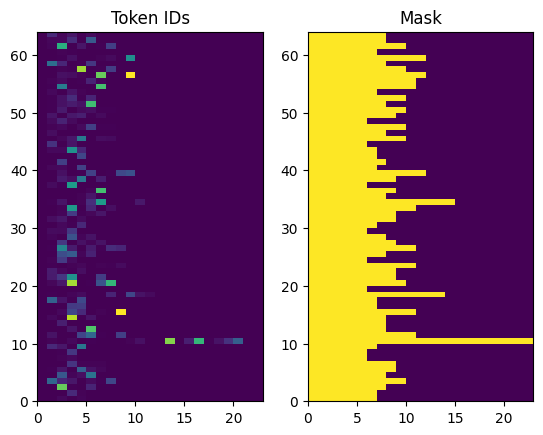

In [19]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

### Process the dataset



The `process_text` function below converts the `Datasets` of strings, into  0-padded tensors of token IDs. It also converts from a `(context, target)` pair to an `((context, target_in), target_out)` pair for training with `keras.Model.fit`. Keras expects `(inputs, labels)` pairs, the inputs are the `(context, target_in)` and the labels are `target_out`. The difference between `target_in` and `target_out` is that they are shifted by one step relative to eachother, so that at each location the label is the next token.

In [20]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

Here is the first sequence of each, from the first batch:

In [21]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[  2 111  10 551  16 149 840   8  11 177]

[   2    9 1512   10  136  883    7  137  148    4]
[   9 1512   10  136  883    7  137  148    4    3]


## The encoder/decoder

The following diagrams shows an overview of the model. In both the encoder is on the left, the decoder is on the right. At each time-step the decoder's output is combined with the encoder's output, to predict the next word. 

The original [left] contains a few extra connections that are intentionally omitted from this tutorial's model [right], as they are generally unnecessary, and difficult to implement. Those missing connections are:

1. Feeding the state from the encoder's RNN to the decoder's RNN
2. Feeding the attention output back to the RNN's input.

<table>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg"/>
  </td>
  <td>
   <img width=380 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The original from <a href=https://arxiv.org/abs/1508.04025v5>Effective Approaches to Attention-based Neural Machine Translation</a></th>
  <th colspan=1>This tutorial's model</th>
<tr>
</table>


Before getting into it define constants for the model:

In [22]:
UNITS = 256

### The encoder

The goal of the encoder is to process the context sequence into a sequence of vectors that are useful for the decoder as it attempts to predict the next output for each timestep. Since the context sequence is constant, there is no restriction on how information can flow in the encoder, so use a bidirectional-RNN to do the processing:

<table>
<tr>
  <td>
   <img width=500 src="https://tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <th>A bidirectional RNN</th>
<tr>
</table>

The encoder:

1. Takes a list of token IDs (from `context_text_processor`).
3. Looks up an embedding vector for each token (Using a `layers.Embedding`).
4. Processes the embeddings into a new sequence (Using a bidirectional `layers.GRU`).
5. Returns the processed sequence. This will be passed to the attention head.

In [23]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

Try it out:

In [24]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 15)
Encoder output, shape (batch, s, units): (64, 15, 256)


### The attention layer

The attention layer lets the decoder access the information extracted by the encoder. It computes a vector from the entire context sequence, and adds that to the decoder's output. 

The simplest way you could calculate a single vector from the entire sequence would be to take the average across the sequence (`layers.GlobalAveragePooling1D`). An attention layer is similar, but calculates a **weighted** average across the context sequence. Where the weights are calculated from the combination of context and "query" vectors.

<table>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The attention layer</th>
<tr>
</table>

In [25]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [26]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 15, 256)
Target sequence, shape (batch, t, units): (64, 13, 256)
Attention result, shape (batch, t, units): (64, 13, 256)
Attention weights, shape (batch, t, s):    (64, 13, 15)


The attention weights will sum to `1` over the context sequence, at each location in the target sequence.

In [27]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([0.99999994, 1.        , 0.9999999 , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.9999999 , 1.        ,
       1.        , 1.        , 1.        ], dtype=float32)



Here are the attention weights across the context sequences at `t=0`:

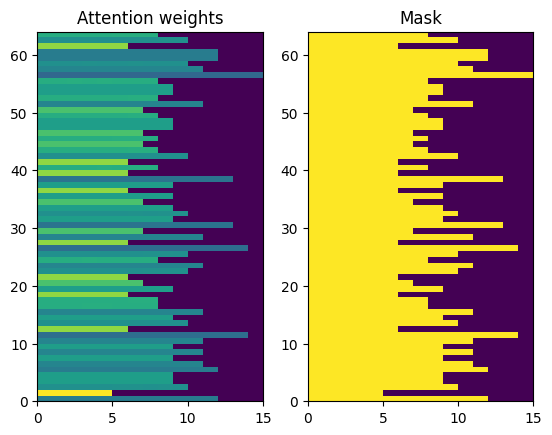

In [28]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


Because of the small-random initialization the attention weights are initially all close to `1/(sequence_length)`. The model will learn to make these less uniform as training progresses.

### The decoder

The decoder's job is to generate predictions for the next token at each location in the target sequence.

1. It looks up embeddings for each token in the target sequence.
2. It uses an RNN to process the target sequence, and keep track of what it has generated so far.
3. It uses RNN output as the "query" to the attention layer, when attending to the encoder's output.
4. At each location in the output it predicts the next token.

When training, the model predicts the next word at each location. So it's important that the information only flows in one direction through the model. The decoder uses a unidirectional (not bidirectional) RNN to process the target sequence.

When running inference with this model it produces one word at a time, and those are fed back into the model.

<table>
<tr>
  <td>
   <img width=500 src="https://tensorflow.org/images/tutorials/transformer/RNN.png"/>
  </td>
</tr>
<tr>
  <th>A unidirectional RNN</th>
<tr>
</table>

Here is the `Decoder` class' initializer. The initializer creates all the necessary layers.

In [29]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

#### Training

Next, the `call` method, takes 3 arguments:

* `inputs` -  a `context, x` pair where:
  * `context` - is the context from the encoder's output.
  * `x` - is the target sequence input.
* `state` - Optional, the previous `state` output from the decoder (the internal state of the decoder's RNN). Pass the state from a previous run to continue generating text where you left off.
* `return_state` - [Default: False] - Set this to `True` to return the RNN state. 

In [30]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

That will be sufficient for training. Create an instance of the decoder to test out:

In [31]:
decoder = Decoder(target_text_processor, UNITS)

In training you'll use the decoder like this:

Given the context and target tokens, for each target token it predicts the next target token. 

In [32]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 15, 256)
input target tokens shape: (batch, t) (64, 13)
logits shape shape: (batch, target_vocabulary_size) (64, 13, 5000)


#### Inference

To use it for inference you'll need a couple more methods:

In [33]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [34]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [35]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

With those extra functions, you can write a generation loop:

In [36]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'bowed strangely sore facing stalled russia art indeed wheres silence',
       b'when pregnant blocks shanghai afraid want settle neighbors neat mouth',
       b'loaded sailing content whereabouts battle worthless fireplace unknown tasted flu'],
      dtype=object)

Since the model's untrained, it outputs items from the vocabulary almost uniformly at random.

## The model

Now that you have all the model components, combine them to build the model for training:

In [37]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

During training the model will be used like this:

In [38]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 15)
Target tokens, shape: (batch, t) (64, 13)
logits, shape: (batch, t, target_vocabulary_size) (64, 13, 5000)


### Train

For training, you'll want to implement your own masked loss and accuracy functions:

In [39]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [40]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

Configure the model for training:

In [41]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

The model is randomly initialized, and should give roughly uniform output probabilities. So it's easy to predict what the initial values of the metrics should be:

In [42]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

That should roughly match the values returned by running a few steps of evaluation:

In [43]:
model.evaluate(val_ds, steps=20, return_dict=True)

 1/20 [>.............................] - ETA: 2:02 - loss: 8.5349 - masked_acc: 0.0000e+00 - masked_loss: 8.5349

 4/20 [=====>........................] - ETA: 0s - loss: 8.5385 - masked_acc: 0.0000e+00 - masked_loss: 8.5385  

 7/20 [=========>....................] - ETA: 0s - loss: 8.5390 - masked_acc: 0.0000e+00 - masked_loss: 8.5390

10/20 [==============>...............] - ETA: 0s - loss: 8.5397 - masked_acc: 0.0000e+00 - masked_loss: 8.5397

13/20 [==================>...........] - ETA: 0s - loss: 8.5405 - masked_acc: 0.0000e+00 - masked_loss: 8.5405

16/20 [=======================>......] - ETA: 0s - loss: 8.5400 - masked_acc: 1.1004e-04 - masked_loss: 8.5400

19/20 [===========================>..] - ETA: 0s - loss: 8.5403 - masked_acc: 9.2661e-05 - masked_loss: 8.5403

20/20 [==============================] - 7s 19ms/step - loss: 8.5404 - masked_acc: 8.8028e-05 - masked_loss: 8.5404


{'loss': 8.540373802185059,
 'masked_acc': 8.802816591924056e-05,
 'masked_loss': 8.540373802185059}

In [44]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100


2022-11-08 12:10:53.201646: W tensorflow/core/common_runtime/forward_type_inference.cc:332] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT8
    }
  }
}

	while inferring type of node 'cond_41/output/_22'


  1/100 [..............................] - ETA: 16:47 - loss: 8.5431 - masked_acc: 0.0000e+00 - masked_loss: 8.5431

  3/100 [..............................] - ETA: 2s - loss: 8.3331 - masked_acc: 0.1237 - masked_loss: 8.3331       

  5/100 [>.............................] - ETA: 2s - loss: 8.0372 - masked_acc: 0.1575 - masked_loss: 8.0372

  7/100 [=>............................] - ETA: 2s - loss: 7.7253 - masked_acc: 0.1514 - masked_loss: 7.7253

  9/100 [=>............................] - ETA: 2s - loss: 7.4259 - masked_acc: 0.1416 - masked_loss: 7.4259

 11/100 [==>...........................] - ETA: 2s - loss: 7.1679 - masked_acc: 0.1341 - masked_loss: 7.1679

 13/100 [==>...........................] - ETA: 2s - loss: 6.9540 - masked_acc: 0.1373 - masked_loss: 6.9540

 15/100 [===>..........................] - ETA: 2s - loss: 6.7756 - masked_acc: 0.1488 - masked_loss: 6.7756

 17/100 [====>.........................] - ETA: 2s - loss: 6.6253 - masked_acc: 0.1457 - masked_loss: 6.6253

 19/100 [====>.........................] - ETA: 2s - loss: 6.5176 - masked_acc: 0.1423 - masked_loss: 6.5176

 21/100 [=====>........................] - ETA: 2s - loss: 6.4281 - masked_acc: 0.1399 - masked_loss: 6.4281

 23/100 [=====>........................] - ETA: 2s - loss: 6.3418 - masked_acc: 0.1401 - masked_loss: 6.3418

 25/100 [======>.......................] - ETA: 2s - loss: 6.2653 - masked_acc: 0.1431 - masked_loss: 6.2653

 27/100 [=======>......................] - ETA: 1s - loss: 6.1892 - masked_acc: 0.1471 - masked_loss: 6.1892

 29/100 [=======>......................] - ETA: 1s - loss: 6.1330 - masked_acc: 0.1510 - masked_loss: 6.1330

 31/100 [========>.....................] - ETA: 1s - loss: 6.0809 - masked_acc: 0.1542 - masked_loss: 6.0809

 33/100 [========>.....................] - ETA: 1s - loss: 6.0382 - masked_acc: 0.1580 - masked_loss: 6.0382

 35/100 [=========>....................] - ETA: 1s - loss: 5.9896 - masked_acc: 0.1627 - masked_loss: 5.9896

 37/100 [==========>...................] - ETA: 1s - loss: 5.9444 - masked_acc: 0.1673 - masked_loss: 5.9444

 39/100 [==========>...................] - ETA: 1s - loss: 5.9029 - masked_acc: 0.1710 - masked_loss: 5.9029

 41/100 [===========>..................] - ETA: 1s - loss: 5.8641 - masked_acc: 0.1749 - masked_loss: 5.8641

 43/100 [===========>..................] - ETA: 1s - loss: 5.8229 - masked_acc: 0.1785 - masked_loss: 5.8229

 45/100 [============>.................] - ETA: 1s - loss: 5.7805 - masked_acc: 0.1818 - masked_loss: 5.7805

 47/100 [=============>................] - ETA: 1s - loss: 5.7376 - masked_acc: 0.1860 - masked_loss: 5.7376

 49/100 [=============>................] - ETA: 1s - loss: 5.6984 - masked_acc: 0.1897 - masked_loss: 5.6984

 51/100 [==============>...............] - ETA: 1s - loss: 5.6645 - masked_acc: 0.1932 - masked_loss: 5.6645

 53/100 [==============>...............] - ETA: 1s - loss: 5.6270 - masked_acc: 0.1974 - masked_loss: 5.6270

 55/100 [===============>..............] - ETA: 1s - loss: 5.5908 - masked_acc: 0.2011 - masked_loss: 5.5908

 57/100 [================>.............] - ETA: 1s - loss: 5.5609 - masked_acc: 0.2046 - masked_loss: 5.5609

 59/100 [================>.............] - ETA: 1s - loss: 5.5309 - masked_acc: 0.2076 - masked_loss: 5.5309

 61/100 [=================>............] - ETA: 1s - loss: 5.5035 - masked_acc: 0.2106 - masked_loss: 5.5035

 63/100 [=================>............] - ETA: 0s - loss: 5.4786 - masked_acc: 0.2132 - masked_loss: 5.4786

 65/100 [==================>...........] - ETA: 0s - loss: 5.4494 - masked_acc: 0.2165 - masked_loss: 5.4494

 67/100 [===================>..........] - ETA: 0s - loss: 5.4207 - masked_acc: 0.2194 - masked_loss: 5.4207

 69/100 [===================>..........] - ETA: 0s - loss: 5.3969 - masked_acc: 0.2217 - masked_loss: 5.3969

 72/100 [====================>.........] - ETA: 0s - loss: 5.3600 - masked_acc: 0.2262 - masked_loss: 5.3600

 74/100 [=====================>........] - ETA: 0s - loss: 5.3351 - masked_acc: 0.2291 - masked_loss: 5.3351

 76/100 [=====================>........] - ETA: 0s - loss: 5.3116 - masked_acc: 0.2317 - masked_loss: 5.3116

 78/100 [======================>.......] - ETA: 0s - loss: 5.2871 - masked_acc: 0.2343 - masked_loss: 5.2871

 80/100 [=======================>......] - ETA: 0s - loss: 5.2638 - masked_acc: 0.2366 - masked_loss: 5.2638

 82/100 [=======================>......] - ETA: 0s - loss: 5.2408 - masked_acc: 0.2391 - masked_loss: 5.2408

 84/100 [========================>.....] - ETA: 0s - loss: 5.2219 - masked_acc: 0.2411 - masked_loss: 5.2219

 86/100 [========================>.....] - ETA: 0s - loss: 5.1986 - masked_acc: 0.2435 - masked_loss: 5.1986

 88/100 [=========================>....] - ETA: 0s - loss: 5.1795 - masked_acc: 0.2453 - masked_loss: 5.1795

 90/100 [==========================>...] - ETA: 0s - loss: 5.1579 - masked_acc: 0.2476 - masked_loss: 5.1579

 92/100 [==========================>...] - ETA: 0s - loss: 5.1390 - masked_acc: 0.2497 - masked_loss: 5.1390

 94/100 [===========================>..] - ETA: 0s - loss: 5.1184 - masked_acc: 0.2517 - masked_loss: 5.1184

 96/100 [===========================>..] - ETA: 0s - loss: 5.0985 - masked_acc: 0.2534 - masked_loss: 5.0985

 98/100 [============================>.] - ETA: 0s - loss: 5.0805 - masked_acc: 0.2553 - masked_loss: 5.0805

100/100 [==============================] - ETA: 0s - loss: 5.0593 - masked_acc: 0.2573 - masked_loss: 5.0593

100/100 [==============================] - 13s 30ms/step - loss: 5.0593 - masked_acc: 0.2573 - masked_loss: 5.0593 - val_loss: 4.1197 - val_masked_acc: 0.3522 - val_masked_loss: 4.1197


Epoch 2/100


  1/100 [..............................] - ETA: 2s - loss: 4.0789 - masked_acc: 0.3653 - masked_loss: 4.0789

  3/100 [..............................] - ETA: 2s - loss: 4.1812 - masked_acc: 0.3374 - masked_loss: 4.1812

  5/100 [>.............................] - ETA: 2s - loss: 4.1369 - masked_acc: 0.3531 - masked_loss: 4.1369

  7/100 [=>............................] - ETA: 2s - loss: 4.1115 - masked_acc: 0.3555 - masked_loss: 4.1115

  9/100 [=>............................] - ETA: 2s - loss: 4.0833 - masked_acc: 0.3563 - masked_loss: 4.0833

 11/100 [==>...........................] - ETA: 2s - loss: 4.0487 - masked_acc: 0.3605 - masked_loss: 4.0487

 13/100 [==>...........................] - ETA: 2s - loss: 4.0268 - masked_acc: 0.3621 - masked_loss: 4.0268

 15/100 [===>..........................] - ETA: 2s - loss: 4.0234 - masked_acc: 0.3629 - masked_loss: 4.0234

 17/100 [====>.........................] - ETA: 2s - loss: 4.0084 - masked_acc: 0.3620 - masked_loss: 4.0084

 19/100 [====>.........................] - ETA: 2s - loss: 4.0086 - masked_acc: 0.3625 - masked_loss: 4.0086

 21/100 [=====>........................] - ETA: 2s - loss: 3.9997 - masked_acc: 0.3628 - masked_loss: 3.9997

 23/100 [=====>........................] - ETA: 2s - loss: 4.0009 - masked_acc: 0.3626 - masked_loss: 4.0009

 25/100 [======>.......................] - ETA: 1s - loss: 3.9929 - masked_acc: 0.3626 - masked_loss: 3.9929

 27/100 [=======>......................] - ETA: 1s - loss: 3.9870 - masked_acc: 0.3646 - masked_loss: 3.9870

 29/100 [=======>......................] - ETA: 1s - loss: 3.9838 - masked_acc: 0.3663 - masked_loss: 3.9838

 31/100 [========>.....................] - ETA: 1s - loss: 3.9718 - masked_acc: 0.3680 - masked_loss: 3.9718

 33/100 [========>.....................] - ETA: 1s - loss: 3.9623 - masked_acc: 0.3692 - masked_loss: 3.9623

 35/100 [=========>....................] - ETA: 1s - loss: 3.9557 - masked_acc: 0.3702 - masked_loss: 3.9557

 37/100 [==========>...................] - ETA: 1s - loss: 3.9523 - masked_acc: 0.3713 - masked_loss: 3.9523

 39/100 [==========>...................] - ETA: 1s - loss: 3.9483 - masked_acc: 0.3710 - masked_loss: 3.9483

 41/100 [===========>..................] - ETA: 1s - loss: 3.9340 - masked_acc: 0.3724 - masked_loss: 3.9340

 43/100 [===========>..................] - ETA: 1s - loss: 3.9254 - masked_acc: 0.3734 - masked_loss: 3.9254

 45/100 [============>.................] - ETA: 1s - loss: 3.9231 - masked_acc: 0.3732 - masked_loss: 3.9231

 47/100 [=============>................] - ETA: 1s - loss: 3.9145 - masked_acc: 0.3745 - masked_loss: 3.9145

 49/100 [=============>................] - ETA: 1s - loss: 3.9008 - masked_acc: 0.3760 - masked_loss: 3.9008

 51/100 [==============>...............] - ETA: 1s - loss: 3.8847 - masked_acc: 0.3780 - masked_loss: 3.8847

 53/100 [==============>...............] - ETA: 1s - loss: 3.8766 - masked_acc: 0.3787 - masked_loss: 3.8766

 55/100 [===============>..............] - ETA: 1s - loss: 3.8692 - masked_acc: 0.3792 - masked_loss: 3.8692

 57/100 [================>.............] - ETA: 1s - loss: 3.8658 - masked_acc: 0.3800 - masked_loss: 3.8658

 59/100 [================>.............] - ETA: 1s - loss: 3.8592 - masked_acc: 0.3804 - masked_loss: 3.8592

 61/100 [=================>............] - ETA: 1s - loss: 3.8513 - masked_acc: 0.3814 - masked_loss: 3.8513

 63/100 [=================>............] - ETA: 0s - loss: 3.8437 - masked_acc: 0.3828 - masked_loss: 3.8437

 65/100 [==================>...........] - ETA: 0s - loss: 3.8400 - masked_acc: 0.3833 - masked_loss: 3.8400

 67/100 [===================>..........] - ETA: 0s - loss: 3.8307 - masked_acc: 0.3845 - masked_loss: 3.8307

 69/100 [===================>..........] - ETA: 0s - loss: 3.8240 - masked_acc: 0.3851 - masked_loss: 3.8240

 71/100 [====================>.........] - ETA: 0s - loss: 3.8202 - masked_acc: 0.3857 - masked_loss: 3.8202

 73/100 [====================>.........] - ETA: 0s - loss: 3.8140 - masked_acc: 0.3871 - masked_loss: 3.8140

 75/100 [=====================>........] - ETA: 0s - loss: 3.8080 - masked_acc: 0.3884 - masked_loss: 3.8080

 77/100 [======================>.......] - ETA: 0s - loss: 3.8020 - masked_acc: 0.3890 - masked_loss: 3.8020

 79/100 [======================>.......] - ETA: 0s - loss: 3.7942 - masked_acc: 0.3899 - masked_loss: 3.7942

 81/100 [=======================>......] - ETA: 0s - loss: 3.7883 - masked_acc: 0.3906 - masked_loss: 3.7883

 83/100 [=======================>......] - ETA: 0s - loss: 3.7784 - masked_acc: 0.3918 - masked_loss: 3.7784

 85/100 [========================>.....] - ETA: 0s - loss: 3.7736 - masked_acc: 0.3925 - masked_loss: 3.7736

 87/100 [=========================>....] - ETA: 0s - loss: 3.7645 - masked_acc: 0.3936 - masked_loss: 3.7645

 89/100 [=========================>....] - ETA: 0s - loss: 3.7554 - masked_acc: 0.3945 - masked_loss: 3.7554

 91/100 [==========================>...] - ETA: 0s - loss: 3.7492 - masked_acc: 0.3956 - masked_loss: 3.7492

 93/100 [==========================>...] - ETA: 0s - loss: 3.7426 - masked_acc: 0.3962 - masked_loss: 3.7426

 95/100 [===========================>..] - ETA: 0s - loss: 3.7342 - masked_acc: 0.3969 - masked_loss: 3.7342

 97/100 [============================>.] - ETA: 0s - loss: 3.7292 - masked_acc: 0.3979 - masked_loss: 3.7292

 99/100 [============================>.] - ETA: 0s - loss: 3.7242 - masked_acc: 0.3982 - masked_loss: 3.7242

100/100 [==============================] - 3s 30ms/step - loss: 3.7190 - masked_acc: 0.3990 - masked_loss: 3.7190 - val_loss: 3.3374 - val_masked_acc: 0.4494 - val_masked_loss: 3.3374


Epoch 3/100


  1/100 [..............................] - ETA: 2s - loss: 3.4790 - masked_acc: 0.4319 - masked_loss: 3.4790

  3/100 [..............................] - ETA: 2s - loss: 3.3049 - masked_acc: 0.4567 - masked_loss: 3.3049

  5/100 [>.............................] - ETA: 2s - loss: 3.3879 - masked_acc: 0.4420 - masked_loss: 3.3879

  7/100 [=>............................] - ETA: 2s - loss: 3.3819 - masked_acc: 0.4435 - masked_loss: 3.3819

  9/100 [=>............................] - ETA: 2s - loss: 3.3648 - masked_acc: 0.4468 - masked_loss: 3.3648

 11/100 [==>...........................] - ETA: 2s - loss: 3.3675 - masked_acc: 0.4460 - masked_loss: 3.3675

 13/100 [==>...........................] - ETA: 2s - loss: 3.3657 - masked_acc: 0.4457 - masked_loss: 3.3657

 15/100 [===>..........................] - ETA: 2s - loss: 3.3653 - masked_acc: 0.4440 - masked_loss: 3.3653

 17/100 [====>.........................] - ETA: 2s - loss: 3.3632 - masked_acc: 0.4451 - masked_loss: 3.3632

 19/100 [====>.........................] - ETA: 2s - loss: 3.3475 - masked_acc: 0.4478 - masked_loss: 3.3475

 21/100 [=====>........................] - ETA: 2s - loss: 3.3327 - masked_acc: 0.4486 - masked_loss: 3.3327

 23/100 [=====>........................] - ETA: 2s - loss: 3.3196 - masked_acc: 0.4514 - masked_loss: 3.3196

 25/100 [======>.......................] - ETA: 1s - loss: 3.3190 - masked_acc: 0.4524 - masked_loss: 3.3190

 27/100 [=======>......................] - ETA: 1s - loss: 3.3139 - masked_acc: 0.4527 - masked_loss: 3.3139

 29/100 [=======>......................] - ETA: 1s - loss: 3.3029 - masked_acc: 0.4550 - masked_loss: 3.3029

 31/100 [========>.....................] - ETA: 1s - loss: 3.2976 - masked_acc: 0.4558 - masked_loss: 3.2976

 33/100 [========>.....................] - ETA: 1s - loss: 3.3005 - masked_acc: 0.4553 - masked_loss: 3.3005

 35/100 [=========>....................] - ETA: 1s - loss: 3.2989 - masked_acc: 0.4557 - masked_loss: 3.2989

 37/100 [==========>...................] - ETA: 1s - loss: 3.2922 - masked_acc: 0.4569 - masked_loss: 3.2922

 39/100 [==========>...................] - ETA: 1s - loss: 3.2820 - masked_acc: 0.4590 - masked_loss: 3.2820

 41/100 [===========>..................] - ETA: 1s - loss: 3.2805 - masked_acc: 0.4591 - masked_loss: 3.2805

 43/100 [===========>..................] - ETA: 1s - loss: 3.2743 - masked_acc: 0.4602 - masked_loss: 3.2743

 45/100 [============>.................] - ETA: 1s - loss: 3.2624 - masked_acc: 0.4614 - masked_loss: 3.2624

 47/100 [=============>................] - ETA: 1s - loss: 3.2512 - masked_acc: 0.4626 - masked_loss: 3.2512

 49/100 [=============>................] - ETA: 1s - loss: 3.2493 - masked_acc: 0.4629 - masked_loss: 3.2493

 51/100 [==============>...............] - ETA: 1s - loss: 3.2462 - masked_acc: 0.4633 - masked_loss: 3.2462

 53/100 [==============>...............] - ETA: 1s - loss: 3.2439 - masked_acc: 0.4637 - masked_loss: 3.2439

 55/100 [===============>..............] - ETA: 1s - loss: 3.2386 - masked_acc: 0.4642 - masked_loss: 3.2386

 57/100 [================>.............] - ETA: 1s - loss: 3.2338 - masked_acc: 0.4646 - masked_loss: 3.2338

 59/100 [================>.............] - ETA: 1s - loss: 3.2289 - masked_acc: 0.4650 - masked_loss: 3.2289

 61/100 [=================>............] - ETA: 1s - loss: 3.2214 - masked_acc: 0.4663 - masked_loss: 3.2214

 63/100 [=================>............] - ETA: 0s - loss: 3.2162 - masked_acc: 0.4670 - masked_loss: 3.2162

 65/100 [==================>...........] - ETA: 0s - loss: 3.2114 - masked_acc: 0.4679 - masked_loss: 3.2114

 67/100 [===================>..........] - ETA: 0s - loss: 3.2071 - masked_acc: 0.4687 - masked_loss: 3.2071

 69/100 [===================>..........] - ETA: 0s - loss: 3.2055 - masked_acc: 0.4693 - masked_loss: 3.2055

 71/100 [====================>.........] - ETA: 0s - loss: 3.1964 - masked_acc: 0.4703 - masked_loss: 3.1964

 73/100 [====================>.........] - ETA: 0s - loss: 3.1888 - masked_acc: 0.4716 - masked_loss: 3.1888

 75/100 [=====================>........] - ETA: 0s - loss: 3.1876 - masked_acc: 0.4720 - masked_loss: 3.1876

 77/100 [======================>.......] - ETA: 0s - loss: 3.1816 - masked_acc: 0.4722 - masked_loss: 3.1816

 79/100 [======================>.......] - ETA: 0s - loss: 3.1801 - masked_acc: 0.4726 - masked_loss: 3.1801

 81/100 [=======================>......] - ETA: 0s - loss: 3.1779 - masked_acc: 0.4730 - masked_loss: 3.1779

 83/100 [=======================>......] - ETA: 0s - loss: 3.1731 - masked_acc: 0.4735 - masked_loss: 3.1731

 85/100 [========================>.....] - ETA: 0s - loss: 3.1644 - masked_acc: 0.4747 - masked_loss: 3.1644

 87/100 [=========================>....] - ETA: 0s - loss: 3.1575 - masked_acc: 0.4755 - masked_loss: 3.1575

 89/100 [=========================>....] - ETA: 0s - loss: 3.1517 - masked_acc: 0.4763 - masked_loss: 3.1517

 91/100 [==========================>...] - ETA: 0s - loss: 3.1484 - masked_acc: 0.4769 - masked_loss: 3.1484

 93/100 [==========================>...] - ETA: 0s - loss: 3.1460 - masked_acc: 0.4773 - masked_loss: 3.1460

 95/100 [===========================>..] - ETA: 0s - loss: 3.1406 - masked_acc: 0.4779 - masked_loss: 3.1406

 97/100 [============================>.] - ETA: 0s - loss: 3.1410 - masked_acc: 0.4777 - masked_loss: 3.1410

 99/100 [============================>.] - ETA: 0s - loss: 3.1375 - masked_acc: 0.4782 - masked_loss: 3.1375

100/100 [==============================] - 3s 30ms/step - loss: 3.1347 - masked_acc: 0.4786 - masked_loss: 3.1347 - val_loss: 2.8942 - val_masked_acc: 0.5124 - val_masked_loss: 2.8942


Epoch 4/100


  1/100 [..............................] - ETA: 2s - loss: 2.9459 - masked_acc: 0.4930 - masked_loss: 2.9459

  3/100 [..............................] - ETA: 2s - loss: 2.9150 - masked_acc: 0.4995 - masked_loss: 2.9150

  5/100 [>.............................] - ETA: 2s - loss: 2.8207 - masked_acc: 0.5107 - masked_loss: 2.8207

  8/100 [=>............................] - ETA: 2s - loss: 2.8148 - masked_acc: 0.5179 - masked_loss: 2.8148

 10/100 [==>...........................] - ETA: 2s - loss: 2.8406 - masked_acc: 0.5135 - masked_loss: 2.8406

 12/100 [==>...........................] - ETA: 2s - loss: 2.8219 - masked_acc: 0.5195 - masked_loss: 2.8219

 14/100 [===>..........................] - ETA: 2s - loss: 2.8319 - masked_acc: 0.5220 - masked_loss: 2.8319

 16/100 [===>..........................] - ETA: 2s - loss: 2.8319 - masked_acc: 0.5212 - masked_loss: 2.8319

 18/100 [====>.........................] - ETA: 2s - loss: 2.8234 - masked_acc: 0.5222 - masked_loss: 2.8234

 20/100 [=====>........................] - ETA: 2s - loss: 2.8143 - masked_acc: 0.5227 - masked_loss: 2.8143

 22/100 [=====>........................] - ETA: 2s - loss: 2.8157 - masked_acc: 0.5228 - masked_loss: 2.8157

 24/100 [======>.......................] - ETA: 2s - loss: 2.8094 - masked_acc: 0.5226 - masked_loss: 2.8094

 26/100 [======>.......................] - ETA: 1s - loss: 2.8064 - masked_acc: 0.5234 - masked_loss: 2.8064

 28/100 [=======>......................] - ETA: 1s - loss: 2.8020 - masked_acc: 0.5228 - masked_loss: 2.8020

 30/100 [========>.....................] - ETA: 1s - loss: 2.8072 - masked_acc: 0.5228 - masked_loss: 2.8072

 32/100 [========>.....................] - ETA: 1s - loss: 2.8108 - masked_acc: 0.5231 - masked_loss: 2.8108

 34/100 [=========>....................] - ETA: 1s - loss: 2.8159 - masked_acc: 0.5217 - masked_loss: 2.8159

 36/100 [=========>....................] - ETA: 1s - loss: 2.8122 - masked_acc: 0.5226 - masked_loss: 2.8122

 38/100 [==========>...................] - ETA: 1s - loss: 2.8126 - masked_acc: 0.5228 - masked_loss: 2.8126

 40/100 [===========>..................] - ETA: 1s - loss: 2.8173 - masked_acc: 0.5218 - masked_loss: 2.8173

 42/100 [===========>..................] - ETA: 1s - loss: 2.8192 - masked_acc: 0.5218 - masked_loss: 2.8192

 44/100 [============>.................] - ETA: 1s - loss: 2.8107 - masked_acc: 0.5227 - masked_loss: 2.8107

 46/100 [============>.................] - ETA: 1s - loss: 2.7987 - masked_acc: 0.5249 - masked_loss: 2.7987

 49/100 [=============>................] - ETA: 1s - loss: 2.7916 - masked_acc: 0.5265 - masked_loss: 2.7916

 51/100 [==============>...............] - ETA: 1s - loss: 2.7934 - masked_acc: 0.5252 - masked_loss: 2.7934

 53/100 [==============>...............] - ETA: 1s - loss: 2.7967 - masked_acc: 0.5251 - masked_loss: 2.7967

 55/100 [===============>..............] - ETA: 1s - loss: 2.8013 - masked_acc: 0.5251 - masked_loss: 2.8013

 57/100 [================>.............] - ETA: 1s - loss: 2.7985 - masked_acc: 0.5257 - masked_loss: 2.7985

 59/100 [================>.............] - ETA: 1s - loss: 2.7955 - masked_acc: 0.5263 - masked_loss: 2.7955

 61/100 [=================>............] - ETA: 1s - loss: 2.7897 - masked_acc: 0.5269 - masked_loss: 2.7897

 63/100 [=================>............] - ETA: 0s - loss: 2.7891 - masked_acc: 0.5267 - masked_loss: 2.7891

 65/100 [==================>...........] - ETA: 0s - loss: 2.7867 - masked_acc: 0.5269 - masked_loss: 2.7867

 67/100 [===================>..........] - ETA: 0s - loss: 2.7896 - masked_acc: 0.5268 - masked_loss: 2.7896

 69/100 [===================>..........] - ETA: 0s - loss: 2.7833 - masked_acc: 0.5272 - masked_loss: 2.7833

 71/100 [====================>.........] - ETA: 0s - loss: 2.7783 - masked_acc: 0.5277 - masked_loss: 2.7783

 73/100 [====================>.........] - ETA: 0s - loss: 2.7718 - masked_acc: 0.5283 - masked_loss: 2.7718

 76/100 [=====================>........] - ETA: 0s - loss: 2.7681 - masked_acc: 0.5292 - masked_loss: 2.7681

 78/100 [======================>.......] - ETA: 0s - loss: 2.7619 - masked_acc: 0.5300 - masked_loss: 2.7619

 80/100 [=======================>......] - ETA: 0s - loss: 2.7551 - masked_acc: 0.5308 - masked_loss: 2.7551

 82/100 [=======================>......] - ETA: 0s - loss: 2.7538 - masked_acc: 0.5314 - masked_loss: 2.7538

 84/100 [========================>.....] - ETA: 0s - loss: 2.7512 - masked_acc: 0.5317 - masked_loss: 2.7512

 86/100 [========================>.....] - ETA: 0s - loss: 2.7478 - masked_acc: 0.5321 - masked_loss: 2.7478

 89/100 [=========================>....] - ETA: 0s - loss: 2.7420 - masked_acc: 0.5334 - masked_loss: 2.7420

 91/100 [==========================>...] - ETA: 0s - loss: 2.7396 - masked_acc: 0.5338 - masked_loss: 2.7396

 93/100 [==========================>...] - ETA: 0s - loss: 2.7390 - masked_acc: 0.5342 - masked_loss: 2.7390

 95/100 [===========================>..] - ETA: 0s - loss: 2.7293 - masked_acc: 0.5352 - masked_loss: 2.7293

 97/100 [============================>.] - ETA: 0s - loss: 2.7283 - masked_acc: 0.5352 - masked_loss: 2.7283

 99/100 [============================>.] - ETA: 0s - loss: 2.7279 - masked_acc: 0.5352 - masked_loss: 2.7279

100/100 [==============================] - 3s 30ms/step - loss: 2.7262 - masked_acc: 0.5355 - masked_loss: 2.7262 - val_loss: 2.5617 - val_masked_acc: 0.5548 - val_masked_loss: 2.5617


Epoch 5/100


  1/100 [..............................] - ETA: 2s - loss: 2.4125 - masked_acc: 0.5794 - masked_loss: 2.4125

  3/100 [..............................] - ETA: 2s - loss: 2.5720 - masked_acc: 0.5705 - masked_loss: 2.5720

  5/100 [>.............................] - ETA: 2s - loss: 2.5586 - masked_acc: 0.5656 - masked_loss: 2.5586

  7/100 [=>............................] - ETA: 2s - loss: 2.5768 - masked_acc: 0.5578 - masked_loss: 2.5768

  9/100 [=>............................] - ETA: 2s - loss: 2.5485 - masked_acc: 0.5626 - masked_loss: 2.5485

 11/100 [==>...........................] - ETA: 2s - loss: 2.5159 - masked_acc: 0.5669 - masked_loss: 2.5159

 14/100 [===>..........................] - ETA: 2s - loss: 2.5244 - masked_acc: 0.5653 - masked_loss: 2.5244

 16/100 [===>..........................] - ETA: 2s - loss: 2.5242 - masked_acc: 0.5655 - masked_loss: 2.5242

 18/100 [====>.........................] - ETA: 2s - loss: 2.5219 - masked_acc: 0.5661 - masked_loss: 2.5219

 20/100 [=====>........................] - ETA: 2s - loss: 2.5321 - masked_acc: 0.5639 - masked_loss: 2.5321

 22/100 [=====>........................] - ETA: 2s - loss: 2.5312 - masked_acc: 0.5631 - masked_loss: 2.5312

 24/100 [======>.......................] - ETA: 1s - loss: 2.5302 - masked_acc: 0.5635 - masked_loss: 2.5302

 26/100 [======>.......................] - ETA: 1s - loss: 2.5326 - masked_acc: 0.5628 - masked_loss: 2.5326

 28/100 [=======>......................] - ETA: 1s - loss: 2.5152 - masked_acc: 0.5658 - masked_loss: 2.5152

 30/100 [========>.....................] - ETA: 1s - loss: 2.5155 - masked_acc: 0.5653 - masked_loss: 2.5155

 32/100 [========>.....................] - ETA: 1s - loss: 2.5170 - masked_acc: 0.5658 - masked_loss: 2.5170

 34/100 [=========>....................] - ETA: 1s - loss: 2.5092 - masked_acc: 0.5668 - masked_loss: 2.5092

 36/100 [=========>....................] - ETA: 1s - loss: 2.5170 - masked_acc: 0.5652 - masked_loss: 2.5170

 38/100 [==========>...................] - ETA: 1s - loss: 2.5097 - masked_acc: 0.5662 - masked_loss: 2.5097

 40/100 [===========>..................] - ETA: 1s - loss: 2.5051 - masked_acc: 0.5672 - masked_loss: 2.5051

 43/100 [===========>..................] - ETA: 1s - loss: 2.4962 - masked_acc: 0.5685 - masked_loss: 2.4962

 45/100 [============>.................] - ETA: 1s - loss: 2.4885 - masked_acc: 0.5695 - masked_loss: 2.4885

 48/100 [=============>................] - ETA: 1s - loss: 2.4745 - masked_acc: 0.5719 - masked_loss: 2.4745

 50/100 [==============>...............] - ETA: 1s - loss: 2.4649 - masked_acc: 0.5729 - masked_loss: 2.4649

 52/100 [==============>...............] - ETA: 1s - loss: 2.4645 - masked_acc: 0.5728 - masked_loss: 2.4645

 54/100 [===============>..............] - ETA: 1s - loss: 2.4575 - masked_acc: 0.5744 - masked_loss: 2.4575

 56/100 [===============>..............] - ETA: 1s - loss: 2.4547 - masked_acc: 0.5746 - masked_loss: 2.4547

 58/100 [================>.............] - ETA: 1s - loss: 2.4535 - masked_acc: 0.5745 - masked_loss: 2.4535

 61/100 [=================>............] - ETA: 1s - loss: 2.4511 - masked_acc: 0.5748 - masked_loss: 2.4511

 63/100 [=================>............] - ETA: 0s - loss: 2.4558 - masked_acc: 0.5744 - masked_loss: 2.4558

 65/100 [==================>...........] - ETA: 0s - loss: 2.4593 - masked_acc: 0.5736 - masked_loss: 2.4593

 67/100 [===================>..........] - ETA: 0s - loss: 2.4544 - masked_acc: 0.5743 - masked_loss: 2.4544

 69/100 [===================>..........] - ETA: 0s - loss: 2.4559 - masked_acc: 0.5744 - masked_loss: 2.4559

 71/100 [====================>.........] - ETA: 0s - loss: 2.4600 - masked_acc: 0.5733 - masked_loss: 2.4600

 73/100 [====================>.........] - ETA: 0s - loss: 2.4577 - masked_acc: 0.5733 - masked_loss: 2.4577

 75/100 [=====================>........] - ETA: 0s - loss: 2.4531 - masked_acc: 0.5739 - masked_loss: 2.4531

 77/100 [======================>.......] - ETA: 0s - loss: 2.4496 - masked_acc: 0.5739 - masked_loss: 2.4496

 79/100 [======================>.......] - ETA: 0s - loss: 2.4488 - masked_acc: 0.5739 - masked_loss: 2.4488

 81/100 [=======================>......] - ETA: 0s - loss: 2.4478 - masked_acc: 0.5742 - masked_loss: 2.4478

 83/100 [=======================>......] - ETA: 0s - loss: 2.4391 - masked_acc: 0.5750 - masked_loss: 2.4391

 85/100 [========================>.....] - ETA: 0s - loss: 2.4375 - masked_acc: 0.5750 - masked_loss: 2.4375

 87/100 [=========================>....] - ETA: 0s - loss: 2.4365 - masked_acc: 0.5756 - masked_loss: 2.4365

 89/100 [=========================>....] - ETA: 0s - loss: 2.4328 - masked_acc: 0.5763 - masked_loss: 2.4328

 91/100 [==========================>...] - ETA: 0s - loss: 2.4313 - masked_acc: 0.5765 - masked_loss: 2.4313

 93/100 [==========================>...] - ETA: 0s - loss: 2.4255 - masked_acc: 0.5773 - masked_loss: 2.4255

 95/100 [===========================>..] - ETA: 0s - loss: 2.4214 - masked_acc: 0.5777 - masked_loss: 2.4214

 97/100 [============================>.] - ETA: 0s - loss: 2.4212 - masked_acc: 0.5778 - masked_loss: 2.4212

 99/100 [============================>.] - ETA: 0s - loss: 2.4196 - masked_acc: 0.5783 - masked_loss: 2.4196

100/100 [==============================] - 3s 30ms/step - loss: 2.4176 - masked_acc: 0.5786 - masked_loss: 2.4176 - val_loss: 2.2161 - val_masked_acc: 0.6093 - val_masked_loss: 2.2161


Epoch 6/100


  1/100 [..............................] - ETA: 2s - loss: 2.1573 - masked_acc: 0.6056 - masked_loss: 2.1573

  3/100 [..............................] - ETA: 2s - loss: 2.1902 - masked_acc: 0.6113 - masked_loss: 2.1902

  5/100 [>.............................] - ETA: 2s - loss: 2.2463 - masked_acc: 0.6028 - masked_loss: 2.2463

  7/100 [=>............................] - ETA: 2s - loss: 2.2960 - masked_acc: 0.5976 - masked_loss: 2.2960

  9/100 [=>............................] - ETA: 2s - loss: 2.2952 - masked_acc: 0.5959 - masked_loss: 2.2952

 11/100 [==>...........................] - ETA: 2s - loss: 2.3081 - masked_acc: 0.5935 - masked_loss: 2.3081

 13/100 [==>...........................] - ETA: 2s - loss: 2.3076 - masked_acc: 0.5958 - masked_loss: 2.3076

 16/100 [===>..........................] - ETA: 2s - loss: 2.3105 - masked_acc: 0.5939 - masked_loss: 2.3105

 18/100 [====>.........................] - ETA: 2s - loss: 2.3174 - masked_acc: 0.5931 - masked_loss: 2.3174

 20/100 [=====>........................] - ETA: 2s - loss: 2.3149 - masked_acc: 0.5940 - masked_loss: 2.3149

 22/100 [=====>........................] - ETA: 2s - loss: 2.3247 - masked_acc: 0.5939 - masked_loss: 2.3247

 24/100 [======>.......................] - ETA: 2s - loss: 2.3132 - masked_acc: 0.5945 - masked_loss: 2.3132

 26/100 [======>.......................] - ETA: 1s - loss: 2.3052 - masked_acc: 0.5945 - masked_loss: 2.3052

 28/100 [=======>......................] - ETA: 1s - loss: 2.3015 - masked_acc: 0.5950 - masked_loss: 2.3015

 30/100 [========>.....................] - ETA: 1s - loss: 2.2898 - masked_acc: 0.5977 - masked_loss: 2.2898

 32/100 [========>.....................] - ETA: 1s - loss: 2.2783 - masked_acc: 0.5987 - masked_loss: 2.2783

 34/100 [=========>....................] - ETA: 1s - loss: 2.2744 - masked_acc: 0.5998 - masked_loss: 2.2744

 36/100 [=========>....................] - ETA: 1s - loss: 2.2772 - masked_acc: 0.5987 - masked_loss: 2.2772

 38/100 [==========>...................] - ETA: 1s - loss: 2.2780 - masked_acc: 0.5986 - masked_loss: 2.2780

 40/100 [===========>..................] - ETA: 1s - loss: 2.2868 - masked_acc: 0.5967 - masked_loss: 2.2868

 42/100 [===========>..................] - ETA: 1s - loss: 2.2830 - masked_acc: 0.5978 - masked_loss: 2.2830

 44/100 [============>.................] - ETA: 1s - loss: 2.2740 - masked_acc: 0.5996 - masked_loss: 2.2740

 46/100 [============>.................] - ETA: 1s - loss: 2.2731 - masked_acc: 0.5997 - masked_loss: 2.2731

 48/100 [=============>................] - ETA: 1s - loss: 2.2752 - masked_acc: 0.5986 - masked_loss: 2.2752

 50/100 [==============>...............] - ETA: 1s - loss: 2.2770 - masked_acc: 0.5989 - masked_loss: 2.2770

 52/100 [==============>...............] - ETA: 1s - loss: 2.2787 - masked_acc: 0.5991 - masked_loss: 2.2787

 55/100 [===============>..............] - ETA: 1s - loss: 2.2734 - masked_acc: 0.6001 - masked_loss: 2.2734

 57/100 [================>.............] - ETA: 1s - loss: 2.2726 - masked_acc: 0.5997 - masked_loss: 2.2726

 59/100 [================>.............] - ETA: 1s - loss: 2.2672 - masked_acc: 0.6000 - masked_loss: 2.2672

 61/100 [=================>............] - ETA: 1s - loss: 2.2661 - masked_acc: 0.6002 - masked_loss: 2.2661

 63/100 [=================>............] - ETA: 0s - loss: 2.2611 - masked_acc: 0.6009 - masked_loss: 2.2611

 65/100 [==================>...........] - ETA: 0s - loss: 2.2560 - masked_acc: 0.6015 - masked_loss: 2.2560

 67/100 [===================>..........] - ETA: 0s - loss: 2.2521 - masked_acc: 0.6023 - masked_loss: 2.2521

 69/100 [===================>..........] - ETA: 0s - loss: 2.2557 - masked_acc: 0.6022 - masked_loss: 2.2557

 71/100 [====================>.........] - ETA: 0s - loss: 2.2558 - masked_acc: 0.6026 - masked_loss: 2.2558

 73/100 [====================>.........] - ETA: 0s - loss: 2.2521 - masked_acc: 0.6030 - masked_loss: 2.2521

 75/100 [=====================>........] - ETA: 0s - loss: 2.2499 - masked_acc: 0.6031 - masked_loss: 2.2499

 77/100 [======================>.......] - ETA: 0s - loss: 2.2495 - masked_acc: 0.6034 - masked_loss: 2.2495

 79/100 [======================>.......] - ETA: 0s - loss: 2.2488 - masked_acc: 0.6031 - masked_loss: 2.2488

 81/100 [=======================>......] - ETA: 0s - loss: 2.2434 - masked_acc: 0.6036 - masked_loss: 2.2434

 83/100 [=======================>......] - ETA: 0s - loss: 2.2388 - masked_acc: 0.6043 - masked_loss: 2.2388

 85/100 [========================>.....] - ETA: 0s - loss: 2.2348 - masked_acc: 0.6046 - masked_loss: 2.2348

 87/100 [=========================>....] - ETA: 0s - loss: 2.2303 - masked_acc: 0.6052 - masked_loss: 2.2303

 90/100 [==========================>...] - ETA: 0s - loss: 2.2243 - masked_acc: 0.6064 - masked_loss: 2.2243

 92/100 [==========================>...] - ETA: 0s - loss: 2.2196 - masked_acc: 0.6069 - masked_loss: 2.2196

 94/100 [===========================>..] - ETA: 0s - loss: 2.2170 - masked_acc: 0.6072 - masked_loss: 2.2170

 96/100 [===========================>..] - ETA: 0s - loss: 2.2125 - masked_acc: 0.6080 - masked_loss: 2.2125

 98/100 [============================>.] - ETA: 0s - loss: 2.2087 - masked_acc: 0.6084 - masked_loss: 2.2087

100/100 [==============================] - ETA: 0s - loss: 2.2097 - masked_acc: 0.6085 - masked_loss: 2.2097

100/100 [==============================] - 3s 30ms/step - loss: 2.2097 - masked_acc: 0.6085 - masked_loss: 2.2097 - val_loss: 2.0373 - val_masked_acc: 0.6282 - val_masked_loss: 2.0373


Epoch 7/100


  1/100 [..............................] - ETA: 2s - loss: 2.0102 - masked_acc: 0.6369 - masked_loss: 2.0102

  3/100 [..............................] - ETA: 2s - loss: 1.9684 - masked_acc: 0.6391 - masked_loss: 1.9684

  5/100 [>.............................] - ETA: 2s - loss: 1.9848 - masked_acc: 0.6409 - masked_loss: 1.9848

  7/100 [=>............................] - ETA: 2s - loss: 2.0516 - masked_acc: 0.6309 - masked_loss: 2.0516

  9/100 [=>............................] - ETA: 2s - loss: 2.0771 - masked_acc: 0.6286 - masked_loss: 2.0771

 11/100 [==>...........................] - ETA: 2s - loss: 2.0568 - masked_acc: 0.6303 - masked_loss: 2.0568

 13/100 [==>...........................] - ETA: 2s - loss: 2.0680 - masked_acc: 0.6292 - masked_loss: 2.0680

 15/100 [===>..........................] - ETA: 2s - loss: 2.0762 - masked_acc: 0.6304 - masked_loss: 2.0762

 17/100 [====>.........................] - ETA: 2s - loss: 2.0789 - masked_acc: 0.6291 - masked_loss: 2.0789

 19/100 [====>.........................] - ETA: 2s - loss: 2.0677 - masked_acc: 0.6306 - masked_loss: 2.0677

 21/100 [=====>........................] - ETA: 2s - loss: 2.0596 - masked_acc: 0.6315 - masked_loss: 2.0596

 23/100 [=====>........................] - ETA: 2s - loss: 2.0560 - masked_acc: 0.6322 - masked_loss: 2.0560

 25/100 [======>.......................] - ETA: 1s - loss: 2.0522 - masked_acc: 0.6328 - masked_loss: 2.0522

 27/100 [=======>......................] - ETA: 1s - loss: 2.0575 - masked_acc: 0.6320 - masked_loss: 2.0575

 29/100 [=======>......................] - ETA: 1s - loss: 2.0695 - masked_acc: 0.6291 - masked_loss: 2.0695

 31/100 [========>.....................] - ETA: 1s - loss: 2.0598 - masked_acc: 0.6308 - masked_loss: 2.0598

 33/100 [========>.....................] - ETA: 1s - loss: 2.0554 - masked_acc: 0.6321 - masked_loss: 2.0554

 35/100 [=========>....................] - ETA: 1s - loss: 2.0543 - masked_acc: 0.6309 - masked_loss: 2.0543

 37/100 [==========>...................] - ETA: 1s - loss: 2.0520 - masked_acc: 0.6312 - masked_loss: 2.0520

 39/100 [==========>...................] - ETA: 1s - loss: 2.0603 - masked_acc: 0.6305 - masked_loss: 2.0603

 42/100 [===========>..................] - ETA: 1s - loss: 2.0589 - masked_acc: 0.6303 - masked_loss: 2.0589

 45/100 [============>.................] - ETA: 1s - loss: 2.0497 - masked_acc: 0.6318 - masked_loss: 2.0497

 47/100 [=============>................] - ETA: 1s - loss: 2.0469 - masked_acc: 0.6319 - masked_loss: 2.0469

 49/100 [=============>................] - ETA: 1s - loss: 2.0433 - masked_acc: 0.6327 - masked_loss: 2.0433

 51/100 [==============>...............] - ETA: 1s - loss: 2.0465 - masked_acc: 0.6318 - masked_loss: 2.0465

 53/100 [==============>...............] - ETA: 1s - loss: 2.0397 - masked_acc: 0.6327 - masked_loss: 2.0397

 55/100 [===============>..............] - ETA: 1s - loss: 2.0398 - masked_acc: 0.6325 - masked_loss: 2.0398

 57/100 [================>.............] - ETA: 1s - loss: 2.0394 - masked_acc: 0.6329 - masked_loss: 2.0394

 59/100 [================>.............] - ETA: 1s - loss: 2.0369 - masked_acc: 0.6339 - masked_loss: 2.0369

 61/100 [=================>............] - ETA: 1s - loss: 2.0359 - masked_acc: 0.6336 - masked_loss: 2.0359

 63/100 [=================>............] - ETA: 0s - loss: 2.0359 - masked_acc: 0.6338 - masked_loss: 2.0359

 65/100 [==================>...........] - ETA: 0s - loss: 2.0415 - masked_acc: 0.6328 - masked_loss: 2.0415

 67/100 [===================>..........] - ETA: 0s - loss: 2.0460 - masked_acc: 0.6323 - masked_loss: 2.0460

 69/100 [===================>..........] - ETA: 0s - loss: 2.0433 - masked_acc: 0.6327 - masked_loss: 2.0433

 71/100 [====================>.........] - ETA: 0s - loss: 2.0431 - masked_acc: 0.6326 - masked_loss: 2.0431

 73/100 [====================>.........] - ETA: 0s - loss: 2.0409 - masked_acc: 0.6329 - masked_loss: 2.0409

 75/100 [=====================>........] - ETA: 0s - loss: 2.0395 - masked_acc: 0.6329 - masked_loss: 2.0395

 77/100 [======================>.......] - ETA: 0s - loss: 2.0350 - masked_acc: 0.6332 - masked_loss: 2.0350

 80/100 [=======================>......] - ETA: 0s - loss: 2.0326 - masked_acc: 0.6335 - masked_loss: 2.0326

 82/100 [=======================>......] - ETA: 0s - loss: 2.0294 - masked_acc: 0.6343 - masked_loss: 2.0294

 84/100 [========================>.....] - ETA: 0s - loss: 2.0265 - masked_acc: 0.6347 - masked_loss: 2.0265

 86/100 [========================>.....] - ETA: 0s - loss: 2.0268 - masked_acc: 0.6341 - masked_loss: 2.0268

 88/100 [=========================>....] - ETA: 0s - loss: 2.0227 - masked_acc: 0.6345 - masked_loss: 2.0227

 90/100 [==========================>...] - ETA: 0s - loss: 2.0156 - masked_acc: 0.6358 - masked_loss: 2.0156

 92/100 [==========================>...] - ETA: 0s - loss: 2.0133 - masked_acc: 0.6363 - masked_loss: 2.0133

 94/100 [===========================>..] - ETA: 0s - loss: 2.0111 - masked_acc: 0.6366 - masked_loss: 2.0111

 96/100 [===========================>..] - ETA: 0s - loss: 2.0098 - masked_acc: 0.6370 - masked_loss: 2.0098

 98/100 [============================>.] - ETA: 0s - loss: 2.0088 - masked_acc: 0.6373 - masked_loss: 2.0088

100/100 [==============================] - ETA: 0s - loss: 2.0069 - masked_acc: 0.6379 - masked_loss: 2.0069

100/100 [==============================] - 3s 30ms/step - loss: 2.0069 - masked_acc: 0.6379 - masked_loss: 2.0069 - val_loss: 2.0198 - val_masked_acc: 0.6315 - val_masked_loss: 2.0198


Epoch 8/100


  1/100 [..............................] - ETA: 2s - loss: 2.0810 - masked_acc: 0.6204 - masked_loss: 2.0810

  3/100 [..............................] - ETA: 2s - loss: 1.9874 - masked_acc: 0.6387 - masked_loss: 1.9874

  5/100 [>.............................] - ETA: 2s - loss: 1.9430 - masked_acc: 0.6457 - masked_loss: 1.9430

  7/100 [=>............................] - ETA: 2s - loss: 1.9233 - masked_acc: 0.6503 - masked_loss: 1.9233

  9/100 [=>............................] - ETA: 2s - loss: 1.9613 - masked_acc: 0.6455 - masked_loss: 1.9613

 11/100 [==>...........................] - ETA: 2s - loss: 1.9490 - masked_acc: 0.6474 - masked_loss: 1.9490

 13/100 [==>...........................] - ETA: 2s - loss: 1.9393 - masked_acc: 0.6458 - masked_loss: 1.9393

 15/100 [===>..........................] - ETA: 2s - loss: 1.9373 - masked_acc: 0.6455 - masked_loss: 1.9373

 17/100 [====>.........................] - ETA: 2s - loss: 1.9390 - masked_acc: 0.6456 - masked_loss: 1.9390

 19/100 [====>.........................] - ETA: 2s - loss: 1.9330 - masked_acc: 0.6469 - masked_loss: 1.9330

 21/100 [=====>........................] - ETA: 2s - loss: 1.9267 - masked_acc: 0.6493 - masked_loss: 1.9267

 23/100 [=====>........................] - ETA: 2s - loss: 1.9215 - masked_acc: 0.6491 - masked_loss: 1.9215

 25/100 [======>.......................] - ETA: 2s - loss: 1.9191 - masked_acc: 0.6483 - masked_loss: 1.9191

 27/100 [=======>......................] - ETA: 1s - loss: 1.9205 - masked_acc: 0.6485 - masked_loss: 1.9205

 29/100 [=======>......................] - ETA: 1s - loss: 1.9295 - masked_acc: 0.6467 - masked_loss: 1.9295

 31/100 [========>.....................] - ETA: 1s - loss: 1.9324 - masked_acc: 0.6473 - masked_loss: 1.9324

 33/100 [========>.....................] - ETA: 1s - loss: 1.9269 - masked_acc: 0.6484 - masked_loss: 1.9269

 35/100 [=========>....................] - ETA: 1s - loss: 1.9244 - masked_acc: 0.6488 - masked_loss: 1.9244

 37/100 [==========>...................] - ETA: 1s - loss: 1.9323 - masked_acc: 0.6487 - masked_loss: 1.9323

 39/100 [==========>...................] - ETA: 1s - loss: 1.9294 - masked_acc: 0.6500 - masked_loss: 1.9294

 41/100 [===========>..................] - ETA: 1s - loss: 1.9213 - masked_acc: 0.6517 - masked_loss: 1.9213

 43/100 [===========>..................] - ETA: 1s - loss: 1.9137 - masked_acc: 0.6523 - masked_loss: 1.9137

 45/100 [============>.................] - ETA: 1s - loss: 1.9096 - masked_acc: 0.6528 - masked_loss: 1.9096

 47/100 [=============>................] - ETA: 1s - loss: 1.9060 - masked_acc: 0.6535 - masked_loss: 1.9060

 49/100 [=============>................] - ETA: 1s - loss: 1.9037 - masked_acc: 0.6542 - masked_loss: 1.9037

 51/100 [==============>...............] - ETA: 1s - loss: 1.9064 - masked_acc: 0.6536 - masked_loss: 1.9064

 54/100 [===============>..............] - ETA: 1s - loss: 1.9087 - masked_acc: 0.6534 - masked_loss: 1.9087

 56/100 [===============>..............] - ETA: 1s - loss: 1.9075 - masked_acc: 0.6536 - masked_loss: 1.9075

 58/100 [================>.............] - ETA: 1s - loss: 1.9009 - masked_acc: 0.6547 - masked_loss: 1.9009

 60/100 [=================>............] - ETA: 1s - loss: 1.8979 - masked_acc: 0.6550 - masked_loss: 1.8979

 62/100 [=================>............] - ETA: 1s - loss: 1.9020 - masked_acc: 0.6541 - masked_loss: 1.9020

 64/100 [==================>...........] - ETA: 0s - loss: 1.8977 - masked_acc: 0.6551 - masked_loss: 1.8977

 66/100 [==================>...........] - ETA: 0s - loss: 1.8941 - masked_acc: 0.6553 - masked_loss: 1.8941

 69/100 [===================>..........] - ETA: 0s - loss: 1.8924 - masked_acc: 0.6553 - masked_loss: 1.8924

 71/100 [====================>.........] - ETA: 0s - loss: 1.8902 - masked_acc: 0.6560 - masked_loss: 1.8902

 73/100 [====================>.........] - ETA: 0s - loss: 1.8956 - masked_acc: 0.6555 - masked_loss: 1.8956

 75/100 [=====================>........] - ETA: 0s - loss: 1.8940 - masked_acc: 0.6560 - masked_loss: 1.8940

 77/100 [======================>.......] - ETA: 0s - loss: 1.8965 - masked_acc: 0.6553 - masked_loss: 1.8965

 79/100 [======================>.......] - ETA: 0s - loss: 1.8928 - masked_acc: 0.6559 - masked_loss: 1.8928

 81/100 [=======================>......] - ETA: 0s - loss: 1.8894 - masked_acc: 0.6561 - masked_loss: 1.8894

 83/100 [=======================>......] - ETA: 0s - loss: 1.8886 - masked_acc: 0.6562 - masked_loss: 1.8886

 85/100 [========================>.....] - ETA: 0s - loss: 1.8849 - masked_acc: 0.6569 - masked_loss: 1.8849

 87/100 [=========================>....] - ETA: 0s - loss: 1.8817 - masked_acc: 0.6572 - masked_loss: 1.8817

 89/100 [=========================>....] - ETA: 0s - loss: 1.8822 - masked_acc: 0.6572 - masked_loss: 1.8822

 91/100 [==========================>...] - ETA: 0s - loss: 1.8780 - masked_acc: 0.6577 - masked_loss: 1.8780

 93/100 [==========================>...] - ETA: 0s - loss: 1.8776 - masked_acc: 0.6581 - masked_loss: 1.8776

 95/100 [===========================>..] - ETA: 0s - loss: 1.8768 - masked_acc: 0.6583 - masked_loss: 1.8768

 97/100 [============================>.] - ETA: 0s - loss: 1.8738 - masked_acc: 0.6591 - masked_loss: 1.8738

 99/100 [============================>.] - ETA: 0s - loss: 1.8734 - masked_acc: 0.6595 - masked_loss: 1.8734

100/100 [==============================] - 3s 30ms/step - loss: 1.8713 - masked_acc: 0.6600 - masked_loss: 1.8713 - val_loss: 1.7739 - val_masked_acc: 0.6730 - val_masked_loss: 1.7739


Epoch 9/100


  1/100 [..............................] - ETA: 2s - loss: 1.7919 - masked_acc: 0.6594 - masked_loss: 1.7919

  3/100 [..............................] - ETA: 2s - loss: 1.8894 - masked_acc: 0.6516 - masked_loss: 1.8894

  5/100 [>.............................] - ETA: 2s - loss: 1.7971 - masked_acc: 0.6636 - masked_loss: 1.7971

  7/100 [=>............................] - ETA: 2s - loss: 1.8275 - masked_acc: 0.6590 - masked_loss: 1.8275

  9/100 [=>............................] - ETA: 2s - loss: 1.7782 - masked_acc: 0.6669 - masked_loss: 1.7782

 11/100 [==>...........................] - ETA: 2s - loss: 1.7735 - masked_acc: 0.6701 - masked_loss: 1.7735

 13/100 [==>...........................] - ETA: 2s - loss: 1.7823 - masked_acc: 0.6678 - masked_loss: 1.7823

 15/100 [===>..........................] - ETA: 2s - loss: 1.7832 - masked_acc: 0.6707 - masked_loss: 1.7832

 17/100 [====>.........................] - ETA: 2s - loss: 1.8024 - masked_acc: 0.6666 - masked_loss: 1.8024

 19/100 [====>.........................] - ETA: 2s - loss: 1.8037 - masked_acc: 0.6675 - masked_loss: 1.8037

 21/100 [=====>........................] - ETA: 2s - loss: 1.7999 - masked_acc: 0.6688 - masked_loss: 1.7999

 23/100 [=====>........................] - ETA: 2s - loss: 1.7958 - masked_acc: 0.6688 - masked_loss: 1.7958

 25/100 [======>.......................] - ETA: 2s - loss: 1.7901 - masked_acc: 0.6707 - masked_loss: 1.7901

 27/100 [=======>......................] - ETA: 1s - loss: 1.7827 - masked_acc: 0.6712 - masked_loss: 1.7827

 29/100 [=======>......................] - ETA: 1s - loss: 1.7894 - masked_acc: 0.6695 - masked_loss: 1.7894

 31/100 [========>.....................] - ETA: 1s - loss: 1.7746 - masked_acc: 0.6722 - masked_loss: 1.7746

 33/100 [========>.....................] - ETA: 1s - loss: 1.7663 - masked_acc: 0.6733 - masked_loss: 1.7663

 35/100 [=========>....................] - ETA: 1s - loss: 1.7802 - masked_acc: 0.6699 - masked_loss: 1.7802

 37/100 [==========>...................] - ETA: 1s - loss: 1.7797 - masked_acc: 0.6687 - masked_loss: 1.7797

 39/100 [==========>...................] - ETA: 1s - loss: 1.7847 - masked_acc: 0.6679 - masked_loss: 1.7847

 41/100 [===========>..................] - ETA: 1s - loss: 1.7738 - masked_acc: 0.6700 - masked_loss: 1.7738

 43/100 [===========>..................] - ETA: 1s - loss: 1.7774 - masked_acc: 0.6701 - masked_loss: 1.7774

 45/100 [============>.................] - ETA: 1s - loss: 1.7736 - masked_acc: 0.6704 - masked_loss: 1.7736

 47/100 [=============>................] - ETA: 1s - loss: 1.7671 - masked_acc: 0.6716 - masked_loss: 1.7671

 49/100 [=============>................] - ETA: 1s - loss: 1.7648 - masked_acc: 0.6717 - masked_loss: 1.7648

 51/100 [==============>...............] - ETA: 1s - loss: 1.7684 - masked_acc: 0.6713 - masked_loss: 1.7684

 53/100 [==============>...............] - ETA: 1s - loss: 1.7765 - masked_acc: 0.6702 - masked_loss: 1.7765

 55/100 [===============>..............] - ETA: 1s - loss: 1.7731 - masked_acc: 0.6705 - masked_loss: 1.7731

 57/100 [================>.............] - ETA: 1s - loss: 1.7752 - masked_acc: 0.6699 - masked_loss: 1.7752

 59/100 [================>.............] - ETA: 1s - loss: 1.7789 - masked_acc: 0.6697 - masked_loss: 1.7789

 61/100 [=================>............] - ETA: 1s - loss: 1.7746 - masked_acc: 0.6707 - masked_loss: 1.7746

 63/100 [=================>............] - ETA: 0s - loss: 1.7799 - masked_acc: 0.6700 - masked_loss: 1.7799

 65/100 [==================>...........] - ETA: 0s - loss: 1.7785 - masked_acc: 0.6702 - masked_loss: 1.7785

 67/100 [===================>..........] - ETA: 0s - loss: 1.7817 - masked_acc: 0.6699 - masked_loss: 1.7817

 69/100 [===================>..........] - ETA: 0s - loss: 1.7799 - masked_acc: 0.6700 - masked_loss: 1.7799

 71/100 [====================>.........] - ETA: 0s - loss: 1.7794 - masked_acc: 0.6698 - masked_loss: 1.7794

 73/100 [====================>.........] - ETA: 0s - loss: 1.7836 - masked_acc: 0.6689 - masked_loss: 1.7836

 75/100 [=====================>........] - ETA: 0s - loss: 1.7815 - masked_acc: 0.6691 - masked_loss: 1.7815

 77/100 [======================>.......] - ETA: 0s - loss: 1.7821 - masked_acc: 0.6688 - masked_loss: 1.7821

 79/100 [======================>.......] - ETA: 0s - loss: 1.7798 - masked_acc: 0.6691 - masked_loss: 1.7798

 81/100 [=======================>......] - ETA: 0s - loss: 1.7841 - masked_acc: 0.6684 - masked_loss: 1.7841

 83/100 [=======================>......] - ETA: 0s - loss: 1.7842 - masked_acc: 0.6685 - masked_loss: 1.7842

 85/100 [========================>.....] - ETA: 0s - loss: 1.7853 - masked_acc: 0.6685 - masked_loss: 1.7853

 87/100 [=========================>....] - ETA: 0s - loss: 1.7861 - masked_acc: 0.6681 - masked_loss: 1.7861

 89/100 [=========================>....] - ETA: 0s - loss: 1.7818 - masked_acc: 0.6687 - masked_loss: 1.7818

 91/100 [==========================>...] - ETA: 0s - loss: 1.7779 - masked_acc: 0.6693 - masked_loss: 1.7779

 93/100 [==========================>...] - ETA: 0s - loss: 1.7757 - masked_acc: 0.6696 - masked_loss: 1.7757

 95/100 [===========================>..] - ETA: 0s - loss: 1.7775 - masked_acc: 0.6698 - masked_loss: 1.7775

 97/100 [============================>.] - ETA: 0s - loss: 1.7748 - masked_acc: 0.6702 - masked_loss: 1.7748

 99/100 [============================>.] - ETA: 0s - loss: 1.7702 - masked_acc: 0.6710 - masked_loss: 1.7702

100/100 [==============================] - 3s 31ms/step - loss: 1.7712 - masked_acc: 0.6711 - masked_loss: 1.7712 - val_loss: 1.7156 - val_masked_acc: 0.6841 - val_masked_loss: 1.7156


Epoch 10/100


  1/100 [..............................] - ETA: 2s - loss: 1.8485 - masked_acc: 0.6710 - masked_loss: 1.8485

  3/100 [..............................] - ETA: 2s - loss: 1.7450 - masked_acc: 0.6853 - masked_loss: 1.7450

  5/100 [>.............................] - ETA: 2s - loss: 1.7108 - masked_acc: 0.6848 - masked_loss: 1.7108

  7/100 [=>............................] - ETA: 2s - loss: 1.7084 - masked_acc: 0.6814 - masked_loss: 1.7084

  9/100 [=>............................] - ETA: 2s - loss: 1.7242 - masked_acc: 0.6811 - masked_loss: 1.7242

 11/100 [==>...........................] - ETA: 2s - loss: 1.7479 - masked_acc: 0.6775 - masked_loss: 1.7479

 13/100 [==>...........................] - ETA: 2s - loss: 1.7114 - masked_acc: 0.6823 - masked_loss: 1.7114

 15/100 [===>..........................] - ETA: 2s - loss: 1.7108 - masked_acc: 0.6829 - masked_loss: 1.7108

 17/100 [====>.........................] - ETA: 2s - loss: 1.7081 - masked_acc: 0.6824 - masked_loss: 1.7081

 19/100 [====>.........................] - ETA: 2s - loss: 1.7151 - masked_acc: 0.6799 - masked_loss: 1.7151

 21/100 [=====>........................] - ETA: 2s - loss: 1.7149 - masked_acc: 0.6815 - masked_loss: 1.7149

 23/100 [=====>........................] - ETA: 2s - loss: 1.7142 - masked_acc: 0.6810 - masked_loss: 1.7142

 25/100 [======>.......................] - ETA: 2s - loss: 1.7119 - masked_acc: 0.6816 - masked_loss: 1.7119

 27/100 [=======>......................] - ETA: 1s - loss: 1.7066 - masked_acc: 0.6816 - masked_loss: 1.7066

 29/100 [=======>......................] - ETA: 1s - loss: 1.6999 - masked_acc: 0.6842 - masked_loss: 1.6999

 31/100 [========>.....................] - ETA: 1s - loss: 1.6992 - masked_acc: 0.6842 - masked_loss: 1.6992

 33/100 [========>.....................] - ETA: 1s - loss: 1.6990 - masked_acc: 0.6846 - masked_loss: 1.6990

 35/100 [=========>....................] - ETA: 1s - loss: 1.6920 - masked_acc: 0.6860 - masked_loss: 1.6920

 37/100 [==========>...................] - ETA: 1s - loss: 1.6904 - masked_acc: 0.6857 - masked_loss: 1.6904

 39/100 [==========>...................] - ETA: 1s - loss: 1.6927 - masked_acc: 0.6847 - masked_loss: 1.6927

 41/100 [===========>..................] - ETA: 1s - loss: 1.6985 - masked_acc: 0.6838 - masked_loss: 1.6985

 43/100 [===========>..................] - ETA: 1s - loss: 1.6917 - masked_acc: 0.6847 - masked_loss: 1.6917

 45/100 [============>.................] - ETA: 1s - loss: 1.6866 - masked_acc: 0.6855 - masked_loss: 1.6866

 47/100 [=============>................] - ETA: 1s - loss: 1.6884 - masked_acc: 0.6857 - masked_loss: 1.6884

 49/100 [=============>................] - ETA: 1s - loss: 1.6888 - masked_acc: 0.6859 - masked_loss: 1.6888

 51/100 [==============>...............] - ETA: 1s - loss: 1.6914 - masked_acc: 0.6857 - masked_loss: 1.6914

 53/100 [==============>...............] - ETA: 1s - loss: 1.6945 - masked_acc: 0.6849 - masked_loss: 1.6945

 55/100 [===============>..............] - ETA: 1s - loss: 1.6940 - masked_acc: 0.6854 - masked_loss: 1.6940

 57/100 [================>.............] - ETA: 1s - loss: 1.6918 - masked_acc: 0.6855 - masked_loss: 1.6918

 59/100 [================>.............] - ETA: 1s - loss: 1.6939 - masked_acc: 0.6857 - masked_loss: 1.6939

 61/100 [=================>............] - ETA: 1s - loss: 1.7001 - masked_acc: 0.6842 - masked_loss: 1.7001

 63/100 [=================>............] - ETA: 0s - loss: 1.6982 - masked_acc: 0.6847 - masked_loss: 1.6982

 65/100 [==================>...........] - ETA: 0s - loss: 1.7012 - masked_acc: 0.6842 - masked_loss: 1.7012

 67/100 [===================>..........] - ETA: 0s - loss: 1.6974 - masked_acc: 0.6847 - masked_loss: 1.6974

 69/100 [===================>..........] - ETA: 0s - loss: 1.6930 - masked_acc: 0.6850 - masked_loss: 1.6930

 71/100 [====================>.........] - ETA: 0s - loss: 1.6964 - masked_acc: 0.6847 - masked_loss: 1.6964

 73/100 [====================>.........] - ETA: 0s - loss: 1.6992 - masked_acc: 0.6848 - masked_loss: 1.6992

 75/100 [=====================>........] - ETA: 0s - loss: 1.6958 - masked_acc: 0.6852 - masked_loss: 1.6958

 77/100 [======================>.......] - ETA: 0s - loss: 1.6932 - masked_acc: 0.6860 - masked_loss: 1.6932

 79/100 [======================>.......] - ETA: 0s - loss: 1.6969 - masked_acc: 0.6851 - masked_loss: 1.6969

 81/100 [=======================>......] - ETA: 0s - loss: 1.6945 - masked_acc: 0.6853 - masked_loss: 1.6945

 83/100 [=======================>......] - ETA: 0s - loss: 1.6933 - masked_acc: 0.6856 - masked_loss: 1.6933

 85/100 [========================>.....] - ETA: 0s - loss: 1.6930 - masked_acc: 0.6856 - masked_loss: 1.6930

 87/100 [=========================>....] - ETA: 0s - loss: 1.6911 - masked_acc: 0.6857 - masked_loss: 1.6911

 89/100 [=========================>....] - ETA: 0s - loss: 1.6920 - masked_acc: 0.6858 - masked_loss: 1.6920

 91/100 [==========================>...] - ETA: 0s - loss: 1.6917 - masked_acc: 0.6853 - masked_loss: 1.6917

 93/100 [==========================>...] - ETA: 0s - loss: 1.6914 - masked_acc: 0.6852 - masked_loss: 1.6914

 95/100 [===========================>..] - ETA: 0s - loss: 1.6924 - masked_acc: 0.6850 - masked_loss: 1.6924

 97/100 [============================>.] - ETA: 0s - loss: 1.6908 - masked_acc: 0.6850 - masked_loss: 1.6908

 99/100 [============================>.] - ETA: 0s - loss: 1.6902 - masked_acc: 0.6852 - masked_loss: 1.6902

100/100 [==============================] - 3s 30ms/step - loss: 1.6916 - masked_acc: 0.6850 - masked_loss: 1.6916 - val_loss: 1.6921 - val_masked_acc: 0.6847 - val_masked_loss: 1.6921


Epoch 11/100


  1/100 [..............................] - ETA: 2s - loss: 1.6664 - masked_acc: 0.6955 - masked_loss: 1.6664

  3/100 [..............................] - ETA: 2s - loss: 1.6197 - masked_acc: 0.6975 - masked_loss: 1.6197

  5/100 [>.............................] - ETA: 2s - loss: 1.5809 - masked_acc: 0.7008 - masked_loss: 1.5809

  7/100 [=>............................] - ETA: 2s - loss: 1.5863 - masked_acc: 0.6997 - masked_loss: 1.5863

  9/100 [=>............................] - ETA: 2s - loss: 1.5557 - masked_acc: 0.7064 - masked_loss: 1.5557

 11/100 [==>...........................] - ETA: 2s - loss: 1.5568 - masked_acc: 0.7059 - masked_loss: 1.5568

 13/100 [==>...........................] - ETA: 2s - loss: 1.5754 - masked_acc: 0.7034 - masked_loss: 1.5754

 15/100 [===>..........................] - ETA: 2s - loss: 1.5865 - masked_acc: 0.7025 - masked_loss: 1.5865

 17/100 [====>.........................] - ETA: 2s - loss: 1.6048 - masked_acc: 0.6997 - masked_loss: 1.6048

 19/100 [====>.........................] - ETA: 2s - loss: 1.6042 - masked_acc: 0.6993 - masked_loss: 1.6042

 21/100 [=====>........................] - ETA: 2s - loss: 1.6092 - masked_acc: 0.6982 - masked_loss: 1.6092

 23/100 [=====>........................] - ETA: 2s - loss: 1.6056 - masked_acc: 0.6994 - masked_loss: 1.6056

 25/100 [======>.......................] - ETA: 2s - loss: 1.6124 - masked_acc: 0.6970 - masked_loss: 1.6124

 27/100 [=======>......................] - ETA: 2s - loss: 1.6146 - masked_acc: 0.6965 - masked_loss: 1.6146

 29/100 [=======>......................] - ETA: 1s - loss: 1.6231 - masked_acc: 0.6951 - masked_loss: 1.6231

 31/100 [========>.....................] - ETA: 1s - loss: 1.6185 - masked_acc: 0.6948 - masked_loss: 1.6185

 33/100 [========>.....................] - ETA: 1s - loss: 1.6336 - masked_acc: 0.6924 - masked_loss: 1.6336

 35/100 [=========>....................] - ETA: 1s - loss: 1.6283 - masked_acc: 0.6928 - masked_loss: 1.6283

 37/100 [==========>...................] - ETA: 1s - loss: 1.6273 - masked_acc: 0.6921 - masked_loss: 1.6273

 39/100 [==========>...................] - ETA: 1s - loss: 1.6286 - masked_acc: 0.6920 - masked_loss: 1.6286

 41/100 [===========>..................] - ETA: 1s - loss: 1.6360 - masked_acc: 0.6910 - masked_loss: 1.6360

 43/100 [===========>..................] - ETA: 1s - loss: 1.6261 - masked_acc: 0.6917 - masked_loss: 1.6261

 45/100 [============>.................] - ETA: 1s - loss: 1.6238 - masked_acc: 0.6927 - masked_loss: 1.6238

 47/100 [=============>................] - ETA: 1s - loss: 1.6261 - masked_acc: 0.6932 - masked_loss: 1.6261

 49/100 [=============>................] - ETA: 1s - loss: 1.6215 - masked_acc: 0.6941 - masked_loss: 1.6215

 51/100 [==============>...............] - ETA: 1s - loss: 1.6220 - masked_acc: 0.6940 - masked_loss: 1.6220

 53/100 [==============>...............] - ETA: 1s - loss: 1.6325 - masked_acc: 0.6929 - masked_loss: 1.6325

 55/100 [===============>..............] - ETA: 1s - loss: 1.6269 - masked_acc: 0.6937 - masked_loss: 1.6269

 57/100 [================>.............] - ETA: 1s - loss: 1.6199 - masked_acc: 0.6948 - masked_loss: 1.6199

 59/100 [================>.............] - ETA: 1s - loss: 1.6188 - masked_acc: 0.6947 - masked_loss: 1.6188

 61/100 [=================>............] - ETA: 1s - loss: 1.6181 - masked_acc: 0.6946 - masked_loss: 1.6181

 63/100 [=================>............] - ETA: 1s - loss: 1.6192 - masked_acc: 0.6943 - masked_loss: 1.6192

 65/100 [==================>...........] - ETA: 0s - loss: 1.6197 - masked_acc: 0.6940 - masked_loss: 1.6197

 67/100 [===================>..........] - ETA: 0s - loss: 1.6132 - masked_acc: 0.6943 - masked_loss: 1.6132

 69/100 [===================>..........] - ETA: 0s - loss: 1.6083 - masked_acc: 0.6951 - masked_loss: 1.6083

 71/100 [====================>.........] - ETA: 0s - loss: 1.6116 - masked_acc: 0.6944 - masked_loss: 1.6116

 73/100 [====================>.........] - ETA: 0s - loss: 1.6113 - masked_acc: 0.6949 - masked_loss: 1.6113

 75/100 [=====================>........] - ETA: 0s - loss: 1.6118 - masked_acc: 0.6948 - masked_loss: 1.6118

 77/100 [======================>.......] - ETA: 0s - loss: 1.6097 - masked_acc: 0.6949 - masked_loss: 1.6097

 79/100 [======================>.......] - ETA: 0s - loss: 1.6104 - masked_acc: 0.6951 - masked_loss: 1.6104

 81/100 [=======================>......] - ETA: 0s - loss: 1.6070 - masked_acc: 0.6957 - masked_loss: 1.6070

 83/100 [=======================>......] - ETA: 0s - loss: 1.6045 - masked_acc: 0.6961 - masked_loss: 1.6045

 85/100 [========================>.....] - ETA: 0s - loss: 1.6028 - masked_acc: 0.6960 - masked_loss: 1.6028

 87/100 [=========================>....] - ETA: 0s - loss: 1.6034 - masked_acc: 0.6960 - masked_loss: 1.6034

 89/100 [=========================>....] - ETA: 0s - loss: 1.6014 - masked_acc: 0.6963 - masked_loss: 1.6014

 91/100 [==========================>...] - ETA: 0s - loss: 1.6044 - masked_acc: 0.6960 - masked_loss: 1.6044

 93/100 [==========================>...] - ETA: 0s - loss: 1.6038 - masked_acc: 0.6959 - masked_loss: 1.6038

 95/100 [===========================>..] - ETA: 0s - loss: 1.6024 - masked_acc: 0.6960 - masked_loss: 1.6024

 97/100 [============================>.] - ETA: 0s - loss: 1.6026 - masked_acc: 0.6957 - masked_loss: 1.6026

 99/100 [============================>.] - ETA: 0s - loss: 1.6044 - masked_acc: 0.6955 - masked_loss: 1.6044

100/100 [==============================] - 3s 31ms/step - loss: 1.6042 - masked_acc: 0.6957 - masked_loss: 1.6042 - val_loss: 1.6207 - val_masked_acc: 0.6888 - val_masked_loss: 1.6207


Epoch 12/100


  1/100 [..............................] - ETA: 2s - loss: 1.4558 - masked_acc: 0.7196 - masked_loss: 1.4558

  3/100 [..............................] - ETA: 2s - loss: 1.5657 - masked_acc: 0.6958 - masked_loss: 1.5657

  5/100 [>.............................] - ETA: 2s - loss: 1.6517 - masked_acc: 0.6921 - masked_loss: 1.6517

  7/100 [=>............................] - ETA: 2s - loss: 1.6776 - masked_acc: 0.6838 - masked_loss: 1.6776

  9/100 [=>............................] - ETA: 2s - loss: 1.6417 - masked_acc: 0.6879 - masked_loss: 1.6417

 11/100 [==>...........................] - ETA: 2s - loss: 1.6387 - masked_acc: 0.6918 - masked_loss: 1.6387

 13/100 [==>...........................] - ETA: 2s - loss: 1.6289 - masked_acc: 0.6933 - masked_loss: 1.6289

 15/100 [===>..........................] - ETA: 2s - loss: 1.6135 - masked_acc: 0.6961 - masked_loss: 1.6135

 17/100 [====>.........................] - ETA: 2s - loss: 1.6236 - masked_acc: 0.6934 - masked_loss: 1.6236

 19/100 [====>.........................] - ETA: 2s - loss: 1.6180 - masked_acc: 0.6942 - masked_loss: 1.6180

 21/100 [=====>........................] - ETA: 2s - loss: 1.6071 - masked_acc: 0.6954 - masked_loss: 1.6071

 23/100 [=====>........................] - ETA: 2s - loss: 1.5923 - masked_acc: 0.6975 - masked_loss: 1.5923

 25/100 [======>.......................] - ETA: 2s - loss: 1.5902 - masked_acc: 0.6978 - masked_loss: 1.5902

 27/100 [=======>......................] - ETA: 1s - loss: 1.5903 - masked_acc: 0.6987 - masked_loss: 1.5903

 29/100 [=======>......................] - ETA: 1s - loss: 1.5920 - masked_acc: 0.6988 - masked_loss: 1.5920

 31/100 [========>.....................] - ETA: 1s - loss: 1.5877 - masked_acc: 0.6995 - masked_loss: 1.5877

 33/100 [========>.....................] - ETA: 1s - loss: 1.5810 - masked_acc: 0.7002 - masked_loss: 1.5810

 35/100 [=========>....................] - ETA: 1s - loss: 1.5794 - masked_acc: 0.7013 - masked_loss: 1.5794

 37/100 [==========>...................] - ETA: 1s - loss: 1.5768 - masked_acc: 0.7014 - masked_loss: 1.5768

 39/100 [==========>...................] - ETA: 1s - loss: 1.5777 - masked_acc: 0.7018 - masked_loss: 1.5777

 41/100 [===========>..................] - ETA: 1s - loss: 1.5730 - masked_acc: 0.7016 - masked_loss: 1.5730

 43/100 [===========>..................] - ETA: 1s - loss: 1.5710 - masked_acc: 0.7013 - masked_loss: 1.5710

 45/100 [============>.................] - ETA: 1s - loss: 1.5634 - masked_acc: 0.7020 - masked_loss: 1.5634

 47/100 [=============>................] - ETA: 1s - loss: 1.5619 - masked_acc: 0.7019 - masked_loss: 1.5619

 49/100 [=============>................] - ETA: 1s - loss: 1.5672 - masked_acc: 0.7003 - masked_loss: 1.5672

 51/100 [==============>...............] - ETA: 1s - loss: 1.5608 - masked_acc: 0.7015 - masked_loss: 1.5608

 53/100 [==============>...............] - ETA: 1s - loss: 1.5684 - masked_acc: 0.7005 - masked_loss: 1.5684

 55/100 [===============>..............] - ETA: 1s - loss: 1.5691 - masked_acc: 0.6997 - masked_loss: 1.5691

 57/100 [================>.............] - ETA: 1s - loss: 1.5658 - masked_acc: 0.7005 - masked_loss: 1.5658

 59/100 [================>.............] - ETA: 1s - loss: 1.5590 - masked_acc: 0.7016 - masked_loss: 1.5590

 61/100 [=================>............] - ETA: 1s - loss: 1.5585 - masked_acc: 0.7014 - masked_loss: 1.5585

 63/100 [=================>............] - ETA: 0s - loss: 1.5579 - masked_acc: 0.7012 - masked_loss: 1.5579

 65/100 [==================>...........] - ETA: 0s - loss: 1.5564 - masked_acc: 0.7008 - masked_loss: 1.5564

 67/100 [===================>..........] - ETA: 0s - loss: 1.5593 - masked_acc: 0.7004 - masked_loss: 1.5593

 69/100 [===================>..........] - ETA: 0s - loss: 1.5665 - masked_acc: 0.6996 - masked_loss: 1.5665

 71/100 [====================>.........] - ETA: 0s - loss: 1.5656 - masked_acc: 0.6999 - masked_loss: 1.5656

 73/100 [====================>.........] - ETA: 0s - loss: 1.5657 - masked_acc: 0.6999 - masked_loss: 1.5657

 75/100 [=====================>........] - ETA: 0s - loss: 1.5631 - masked_acc: 0.7001 - masked_loss: 1.5631

 77/100 [======================>.......] - ETA: 0s - loss: 1.5649 - masked_acc: 0.7002 - masked_loss: 1.5649

 79/100 [======================>.......] - ETA: 0s - loss: 1.5643 - masked_acc: 0.7006 - masked_loss: 1.5643

 81/100 [=======================>......] - ETA: 0s - loss: 1.5651 - masked_acc: 0.7001 - masked_loss: 1.5651

 83/100 [=======================>......] - ETA: 0s - loss: 1.5660 - masked_acc: 0.7000 - masked_loss: 1.5660

 85/100 [========================>.....] - ETA: 0s - loss: 1.5640 - masked_acc: 0.7005 - masked_loss: 1.5640

 87/100 [=========================>....] - ETA: 0s - loss: 1.5627 - masked_acc: 0.7006 - masked_loss: 1.5627

 89/100 [=========================>....] - ETA: 0s - loss: 1.5591 - masked_acc: 0.7010 - masked_loss: 1.5591

 91/100 [==========================>...] - ETA: 0s - loss: 1.5588 - masked_acc: 0.7014 - masked_loss: 1.5588

 93/100 [==========================>...] - ETA: 0s - loss: 1.5535 - masked_acc: 0.7020 - masked_loss: 1.5535

 95/100 [===========================>..] - ETA: 0s - loss: 1.5458 - masked_acc: 0.7033 - masked_loss: 1.5458

 97/100 [============================>.] - ETA: 0s - loss: 1.5413 - masked_acc: 0.7041 - masked_loss: 1.5413

 99/100 [============================>.] - ETA: 0s - loss: 1.5412 - masked_acc: 0.7041 - masked_loss: 1.5412

100/100 [==============================] - 3s 31ms/step - loss: 1.5406 - masked_acc: 0.7041 - masked_loss: 1.5406 - val_loss: 1.5735 - val_masked_acc: 0.7020 - val_masked_loss: 1.5735


Epoch 13/100


  1/100 [..............................] - ETA: 2s - loss: 1.8244 - masked_acc: 0.6732 - masked_loss: 1.8244

  3/100 [..............................] - ETA: 2s - loss: 1.6530 - masked_acc: 0.6931 - masked_loss: 1.6530

  5/100 [>.............................] - ETA: 2s - loss: 1.6068 - masked_acc: 0.7005 - masked_loss: 1.6068

  7/100 [=>............................] - ETA: 2s - loss: 1.5393 - masked_acc: 0.7116 - masked_loss: 1.5393

  9/100 [=>............................] - ETA: 2s - loss: 1.5293 - masked_acc: 0.7088 - masked_loss: 1.5293

 11/100 [==>...........................] - ETA: 2s - loss: 1.5238 - masked_acc: 0.7089 - masked_loss: 1.5238

 13/100 [==>...........................] - ETA: 2s - loss: 1.5424 - masked_acc: 0.7069 - masked_loss: 1.5424

 15/100 [===>..........................] - ETA: 2s - loss: 1.5389 - masked_acc: 0.7057 - masked_loss: 1.5389

 17/100 [====>.........................] - ETA: 2s - loss: 1.5248 - masked_acc: 0.7084 - masked_loss: 1.5248

 19/100 [====>.........................] - ETA: 2s - loss: 1.5341 - masked_acc: 0.7064 - masked_loss: 1.5341

 21/100 [=====>........................] - ETA: 2s - loss: 1.5389 - masked_acc: 0.7064 - masked_loss: 1.5389

 23/100 [=====>........................] - ETA: 2s - loss: 1.5369 - masked_acc: 0.7043 - masked_loss: 1.5369

 25/100 [======>.......................] - ETA: 2s - loss: 1.5441 - masked_acc: 0.7023 - masked_loss: 1.5441

 27/100 [=======>......................] - ETA: 1s - loss: 1.5479 - masked_acc: 0.7011 - masked_loss: 1.5479

 29/100 [=======>......................] - ETA: 1s - loss: 1.5478 - masked_acc: 0.7012 - masked_loss: 1.5478

 31/100 [========>.....................] - ETA: 1s - loss: 1.5405 - masked_acc: 0.7027 - masked_loss: 1.5405

 33/100 [========>.....................] - ETA: 1s - loss: 1.5471 - masked_acc: 0.7012 - masked_loss: 1.5471

 35/100 [=========>....................] - ETA: 1s - loss: 1.5521 - masked_acc: 0.7013 - masked_loss: 1.5521

 37/100 [==========>...................] - ETA: 1s - loss: 1.5513 - masked_acc: 0.7021 - masked_loss: 1.5513

 39/100 [==========>...................] - ETA: 1s - loss: 1.5496 - masked_acc: 0.7026 - masked_loss: 1.5496

 41/100 [===========>..................] - ETA: 1s - loss: 1.5516 - masked_acc: 0.7025 - masked_loss: 1.5516

 43/100 [===========>..................] - ETA: 1s - loss: 1.5582 - masked_acc: 0.7021 - masked_loss: 1.5582

 45/100 [============>.................] - ETA: 1s - loss: 1.5470 - masked_acc: 0.7034 - masked_loss: 1.5470

 47/100 [=============>................] - ETA: 1s - loss: 1.5508 - masked_acc: 0.7026 - masked_loss: 1.5508

 49/100 [=============>................] - ETA: 1s - loss: 1.5516 - masked_acc: 0.7023 - masked_loss: 1.5516

 51/100 [==============>...............] - ETA: 1s - loss: 1.5509 - masked_acc: 0.7021 - masked_loss: 1.5509

 53/100 [==============>...............] - ETA: 1s - loss: 1.5494 - masked_acc: 0.7022 - masked_loss: 1.5494

 55/100 [===============>..............] - ETA: 1s - loss: 1.5549 - masked_acc: 0.7016 - masked_loss: 1.5549

 57/100 [================>.............] - ETA: 1s - loss: 1.5507 - masked_acc: 0.7020 - masked_loss: 1.5507

 59/100 [================>.............] - ETA: 1s - loss: 1.5541 - masked_acc: 0.7006 - masked_loss: 1.5541

 61/100 [=================>............] - ETA: 1s - loss: 1.5513 - masked_acc: 0.7012 - masked_loss: 1.5513

 63/100 [=================>............] - ETA: 1s - loss: 1.5512 - masked_acc: 0.7010 - masked_loss: 1.5512

 65/100 [==================>...........] - ETA: 0s - loss: 1.5507 - masked_acc: 0.7010 - masked_loss: 1.5507

 67/100 [===================>..........] - ETA: 0s - loss: 1.5492 - masked_acc: 0.7008 - masked_loss: 1.5492

 69/100 [===================>..........] - ETA: 0s - loss: 1.5504 - masked_acc: 0.7004 - masked_loss: 1.5504

 71/100 [====================>.........] - ETA: 0s - loss: 1.5565 - masked_acc: 0.6990 - masked_loss: 1.5565

 73/100 [====================>.........] - ETA: 0s - loss: 1.5591 - masked_acc: 0.6986 - masked_loss: 1.5591

 75/100 [=====================>........] - ETA: 0s - loss: 1.5614 - masked_acc: 0.6985 - masked_loss: 1.5614

 77/100 [======================>.......] - ETA: 0s - loss: 1.5584 - masked_acc: 0.6991 - masked_loss: 1.5584

 79/100 [======================>.......] - ETA: 0s - loss: 1.5586 - masked_acc: 0.6992 - masked_loss: 1.5586

 81/100 [=======================>......] - ETA: 0s - loss: 1.5559 - masked_acc: 0.6996 - masked_loss: 1.5559

 83/100 [=======================>......] - ETA: 0s - loss: 1.5542 - masked_acc: 0.7004 - masked_loss: 1.5542

 85/100 [========================>.....] - ETA: 0s - loss: 1.5527 - masked_acc: 0.7008 - masked_loss: 1.5527

 87/100 [=========================>....] - ETA: 0s - loss: 1.5531 - masked_acc: 0.7006 - masked_loss: 1.5531

 89/100 [=========================>....] - ETA: 0s - loss: 1.5519 - masked_acc: 0.7004 - masked_loss: 1.5519

 91/100 [==========================>...] - ETA: 0s - loss: 1.5521 - masked_acc: 0.7003 - masked_loss: 1.5521

 93/100 [==========================>...] - ETA: 0s - loss: 1.5481 - masked_acc: 0.7011 - masked_loss: 1.5481

 95/100 [===========================>..] - ETA: 0s - loss: 1.5438 - masked_acc: 0.7017 - masked_loss: 1.5438

 97/100 [============================>.] - ETA: 0s - loss: 1.5414 - masked_acc: 0.7022 - masked_loss: 1.5414

 99/100 [============================>.] - ETA: 0s - loss: 1.5380 - masked_acc: 0.7025 - masked_loss: 1.5380

100/100 [==============================] - 3s 30ms/step - loss: 1.5387 - masked_acc: 0.7024 - masked_loss: 1.5387 - val_loss: 1.4561 - val_masked_acc: 0.7157 - val_masked_loss: 1.4561


Epoch 14/100


  1/100 [..............................] - ETA: 2s - loss: 1.4692 - masked_acc: 0.7111 - masked_loss: 1.4692

  3/100 [..............................] - ETA: 2s - loss: 1.4706 - masked_acc: 0.7107 - masked_loss: 1.4706

  5/100 [>.............................] - ETA: 2s - loss: 1.4179 - masked_acc: 0.7170 - masked_loss: 1.4179

  7/100 [=>............................] - ETA: 2s - loss: 1.4562 - masked_acc: 0.7149 - masked_loss: 1.4562

  9/100 [=>............................] - ETA: 2s - loss: 1.4820 - masked_acc: 0.7106 - masked_loss: 1.4820

 11/100 [==>...........................] - ETA: 2s - loss: 1.5027 - masked_acc: 0.7070 - masked_loss: 1.5027

 13/100 [==>...........................] - ETA: 2s - loss: 1.5009 - masked_acc: 0.7083 - masked_loss: 1.5009

 15/100 [===>..........................] - ETA: 2s - loss: 1.5006 - masked_acc: 0.7075 - masked_loss: 1.5006

 17/100 [====>.........................] - ETA: 2s - loss: 1.5038 - masked_acc: 0.7053 - masked_loss: 1.5038

 19/100 [====>.........................] - ETA: 2s - loss: 1.5027 - masked_acc: 0.7036 - masked_loss: 1.5027

 21/100 [=====>........................] - ETA: 2s - loss: 1.5084 - masked_acc: 0.7027 - masked_loss: 1.5084

 23/100 [=====>........................] - ETA: 2s - loss: 1.5177 - masked_acc: 0.7015 - masked_loss: 1.5177

 25/100 [======>.......................] - ETA: 2s - loss: 1.5300 - masked_acc: 0.6997 - masked_loss: 1.5300

 27/100 [=======>......................] - ETA: 2s - loss: 1.5319 - masked_acc: 0.7000 - masked_loss: 1.5319

 29/100 [=======>......................] - ETA: 1s - loss: 1.5301 - masked_acc: 0.7005 - masked_loss: 1.5301

 31/100 [========>.....................] - ETA: 1s - loss: 1.5248 - masked_acc: 0.7019 - masked_loss: 1.5248

 33/100 [========>.....................] - ETA: 1s - loss: 1.5137 - masked_acc: 0.7038 - masked_loss: 1.5137

 35/100 [=========>....................] - ETA: 1s - loss: 1.5234 - masked_acc: 0.7033 - masked_loss: 1.5234

 37/100 [==========>...................] - ETA: 1s - loss: 1.5271 - masked_acc: 0.7020 - masked_loss: 1.5271

 39/100 [==========>...................] - ETA: 1s - loss: 1.5250 - masked_acc: 0.7032 - masked_loss: 1.5250

 41/100 [===========>..................] - ETA: 1s - loss: 1.5232 - masked_acc: 0.7032 - masked_loss: 1.5232

 43/100 [===========>..................] - ETA: 1s - loss: 1.5280 - masked_acc: 0.7031 - masked_loss: 1.5280

 45/100 [============>.................] - ETA: 1s - loss: 1.5236 - masked_acc: 0.7041 - masked_loss: 1.5236

 47/100 [=============>................] - ETA: 1s - loss: 1.5240 - masked_acc: 0.7033 - masked_loss: 1.5240

 49/100 [=============>................] - ETA: 1s - loss: 1.5192 - masked_acc: 0.7036 - masked_loss: 1.5192

 51/100 [==============>...............] - ETA: 1s - loss: 1.5179 - masked_acc: 0.7041 - masked_loss: 1.5179

 53/100 [==============>...............] - ETA: 1s - loss: 1.5155 - masked_acc: 0.7040 - masked_loss: 1.5155

 55/100 [===============>..............] - ETA: 1s - loss: 1.5170 - masked_acc: 0.7037 - masked_loss: 1.5170

 57/100 [================>.............] - ETA: 1s - loss: 1.5150 - masked_acc: 0.7040 - masked_loss: 1.5150

 59/100 [================>.............] - ETA: 1s - loss: 1.5143 - masked_acc: 0.7041 - masked_loss: 1.5143

 61/100 [=================>............] - ETA: 1s - loss: 1.5056 - masked_acc: 0.7055 - masked_loss: 1.5056

 63/100 [=================>............] - ETA: 1s - loss: 1.5057 - masked_acc: 0.7057 - masked_loss: 1.5057

 65/100 [==================>...........] - ETA: 0s - loss: 1.5004 - masked_acc: 0.7069 - masked_loss: 1.5004

 67/100 [===================>..........] - ETA: 0s - loss: 1.5000 - masked_acc: 0.7071 - masked_loss: 1.5000

 69/100 [===================>..........] - ETA: 0s - loss: 1.4950 - masked_acc: 0.7076 - masked_loss: 1.4950

 71/100 [====================>.........] - ETA: 0s - loss: 1.4896 - masked_acc: 0.7083 - masked_loss: 1.4896

 73/100 [====================>.........] - ETA: 0s - loss: 1.4881 - masked_acc: 0.7085 - masked_loss: 1.4881

 75/100 [=====================>........] - ETA: 0s - loss: 1.4887 - masked_acc: 0.7085 - masked_loss: 1.4887

 77/100 [======================>.......] - ETA: 0s - loss: 1.4884 - masked_acc: 0.7088 - masked_loss: 1.4884

 79/100 [======================>.......] - ETA: 0s - loss: 1.4893 - masked_acc: 0.7088 - masked_loss: 1.4893

 81/100 [=======================>......] - ETA: 0s - loss: 1.4887 - masked_acc: 0.7091 - masked_loss: 1.4887

 83/100 [=======================>......] - ETA: 0s - loss: 1.4877 - masked_acc: 0.7093 - masked_loss: 1.4877

 85/100 [========================>.....] - ETA: 0s - loss: 1.4903 - masked_acc: 0.7088 - masked_loss: 1.4903

 87/100 [=========================>....] - ETA: 0s - loss: 1.4889 - masked_acc: 0.7091 - masked_loss: 1.4889

 89/100 [=========================>....] - ETA: 0s - loss: 1.4865 - masked_acc: 0.7096 - masked_loss: 1.4865

 91/100 [==========================>...] - ETA: 0s - loss: 1.4839 - masked_acc: 0.7101 - masked_loss: 1.4839

 93/100 [==========================>...] - ETA: 0s - loss: 1.4812 - masked_acc: 0.7107 - masked_loss: 1.4812

 95/100 [===========================>..] - ETA: 0s - loss: 1.4807 - masked_acc: 0.7108 - masked_loss: 1.4807

 97/100 [============================>.] - ETA: 0s - loss: 1.4814 - masked_acc: 0.7104 - masked_loss: 1.4814

 99/100 [============================>.] - ETA: 0s - loss: 1.4792 - masked_acc: 0.7105 - masked_loss: 1.4792

100/100 [==============================] - 3s 30ms/step - loss: 1.4799 - masked_acc: 0.7105 - masked_loss: 1.4799 - val_loss: 1.4196 - val_masked_acc: 0.7177 - val_masked_loss: 1.4196


Epoch 15/100


  1/100 [..............................] - ETA: 2s - loss: 1.3820 - masked_acc: 0.7186 - masked_loss: 1.3820

  3/100 [..............................] - ETA: 2s - loss: 1.4510 - masked_acc: 0.7084 - masked_loss: 1.4510

  5/100 [>.............................] - ETA: 2s - loss: 1.4728 - masked_acc: 0.7051 - masked_loss: 1.4728

  7/100 [=>............................] - ETA: 2s - loss: 1.4287 - masked_acc: 0.7110 - masked_loss: 1.4287

  9/100 [=>............................] - ETA: 2s - loss: 1.4340 - masked_acc: 0.7123 - masked_loss: 1.4340

 11/100 [==>...........................] - ETA: 2s - loss: 1.4302 - masked_acc: 0.7150 - masked_loss: 1.4302

 13/100 [==>...........................] - ETA: 2s - loss: 1.4186 - masked_acc: 0.7164 - masked_loss: 1.4186

 15/100 [===>..........................] - ETA: 2s - loss: 1.4149 - masked_acc: 0.7191 - masked_loss: 1.4149

 17/100 [====>.........................] - ETA: 2s - loss: 1.4137 - masked_acc: 0.7189 - masked_loss: 1.4137

 19/100 [====>.........................] - ETA: 2s - loss: 1.4111 - masked_acc: 0.7218 - masked_loss: 1.4111

 21/100 [=====>........................] - ETA: 2s - loss: 1.4032 - masked_acc: 0.7232 - masked_loss: 1.4032

 23/100 [=====>........................] - ETA: 2s - loss: 1.4090 - masked_acc: 0.7213 - masked_loss: 1.4090

 25/100 [======>.......................] - ETA: 2s - loss: 1.4232 - masked_acc: 0.7197 - masked_loss: 1.4232

 27/100 [=======>......................] - ETA: 1s - loss: 1.4253 - masked_acc: 0.7200 - masked_loss: 1.4253

 29/100 [=======>......................] - ETA: 1s - loss: 1.4225 - masked_acc: 0.7214 - masked_loss: 1.4225

 31/100 [========>.....................] - ETA: 1s - loss: 1.4305 - masked_acc: 0.7200 - masked_loss: 1.4305

 33/100 [========>.....................] - ETA: 1s - loss: 1.4339 - masked_acc: 0.7195 - masked_loss: 1.4339

 35/100 [=========>....................] - ETA: 1s - loss: 1.4233 - masked_acc: 0.7224 - masked_loss: 1.4233

 37/100 [==========>...................] - ETA: 1s - loss: 1.4271 - masked_acc: 0.7215 - masked_loss: 1.4271

 39/100 [==========>...................] - ETA: 1s - loss: 1.4295 - masked_acc: 0.7215 - masked_loss: 1.4295

 41/100 [===========>..................] - ETA: 1s - loss: 1.4426 - masked_acc: 0.7196 - masked_loss: 1.4426

 43/100 [===========>..................] - ETA: 1s - loss: 1.4412 - masked_acc: 0.7200 - masked_loss: 1.4412

 45/100 [============>.................] - ETA: 1s - loss: 1.4534 - masked_acc: 0.7179 - masked_loss: 1.4534

 47/100 [=============>................] - ETA: 1s - loss: 1.4503 - masked_acc: 0.7176 - masked_loss: 1.4503

 49/100 [=============>................] - ETA: 1s - loss: 1.4439 - masked_acc: 0.7182 - masked_loss: 1.4439

 51/100 [==============>...............] - ETA: 1s - loss: 1.4467 - masked_acc: 0.7176 - masked_loss: 1.4467

 53/100 [==============>...............] - ETA: 1s - loss: 1.4434 - masked_acc: 0.7180 - masked_loss: 1.4434

 55/100 [===============>..............] - ETA: 1s - loss: 1.4360 - masked_acc: 0.7190 - masked_loss: 1.4360

 57/100 [================>.............] - ETA: 1s - loss: 1.4337 - masked_acc: 0.7191 - masked_loss: 1.4337

 59/100 [================>.............] - ETA: 1s - loss: 1.4288 - masked_acc: 0.7196 - masked_loss: 1.4288

 61/100 [=================>............] - ETA: 1s - loss: 1.4287 - masked_acc: 0.7203 - masked_loss: 1.4287

 63/100 [=================>............] - ETA: 0s - loss: 1.4311 - masked_acc: 0.7199 - masked_loss: 1.4311

 65/100 [==================>...........] - ETA: 0s - loss: 1.4339 - masked_acc: 0.7194 - masked_loss: 1.4339

 67/100 [===================>..........] - ETA: 0s - loss: 1.4322 - masked_acc: 0.7196 - masked_loss: 1.4322

 69/100 [===================>..........] - ETA: 0s - loss: 1.4324 - masked_acc: 0.7199 - masked_loss: 1.4324

 71/100 [====================>.........] - ETA: 0s - loss: 1.4297 - masked_acc: 0.7201 - masked_loss: 1.4297

 73/100 [====================>.........] - ETA: 0s - loss: 1.4295 - masked_acc: 0.7204 - masked_loss: 1.4295

 75/100 [=====================>........] - ETA: 0s - loss: 1.4303 - masked_acc: 0.7199 - masked_loss: 1.4303

 77/100 [======================>.......] - ETA: 0s - loss: 1.4296 - masked_acc: 0.7197 - masked_loss: 1.4296

 79/100 [======================>.......] - ETA: 0s - loss: 1.4308 - masked_acc: 0.7193 - masked_loss: 1.4308

 81/100 [=======================>......] - ETA: 0s - loss: 1.4318 - masked_acc: 0.7192 - masked_loss: 1.4318

 83/100 [=======================>......] - ETA: 0s - loss: 1.4296 - masked_acc: 0.7192 - masked_loss: 1.4296

 85/100 [========================>.....] - ETA: 0s - loss: 1.4293 - masked_acc: 0.7192 - masked_loss: 1.4293

 87/100 [=========================>....] - ETA: 0s - loss: 1.4283 - masked_acc: 0.7195 - masked_loss: 1.4283

 89/100 [=========================>....] - ETA: 0s - loss: 1.4236 - masked_acc: 0.7202 - masked_loss: 1.4234

 91/100 [==========================>...] - ETA: 0s - loss: 1.4181 - masked_acc: 0.7207 - masked_loss: 1.4179

 93/100 [==========================>...] - ETA: 0s - loss: 1.4141 - masked_acc: 0.7214 - masked_loss: 1.4139

 95/100 [===========================>..] - ETA: 0s - loss: 1.4102 - masked_acc: 0.7216 - masked_loss: 1.4100

 97/100 [============================>.] - ETA: 0s - loss: 1.4051 - masked_acc: 0.7223 - masked_loss: 1.4049

 99/100 [============================>.] - ETA: 0s - loss: 1.4000 - masked_acc: 0.7230 - masked_loss: 1.3998

100/100 [==============================] - 3s 31ms/step - loss: 1.3975 - masked_acc: 0.7233 - masked_loss: 1.3973 - val_loss: 1.4177 - val_masked_acc: 0.7246 - val_masked_loss: 1.4177


Epoch 16/100


  1/100 [..............................] - ETA: 2s - loss: 1.2231 - masked_acc: 0.7459 - masked_loss: 1.2231

  3/100 [..............................] - ETA: 2s - loss: 1.2621 - masked_acc: 0.7380 - masked_loss: 1.2621

  5/100 [>.............................] - ETA: 2s - loss: 1.2477 - masked_acc: 0.7344 - masked_loss: 1.2477

  7/100 [=>............................] - ETA: 2s - loss: 1.2210 - masked_acc: 0.7384 - masked_loss: 1.2210

  9/100 [=>............................] - ETA: 2s - loss: 1.2101 - masked_acc: 0.7425 - masked_loss: 1.2101

 11/100 [==>...........................] - ETA: 2s - loss: 1.2081 - masked_acc: 0.7419 - masked_loss: 1.2081

 13/100 [==>...........................] - ETA: 2s - loss: 1.2357 - masked_acc: 0.7382 - masked_loss: 1.2357

 15/100 [===>..........................] - ETA: 2s - loss: 1.2298 - masked_acc: 0.7406 - masked_loss: 1.2298

 17/100 [====>.........................] - ETA: 2s - loss: 1.2207 - masked_acc: 0.7436 - masked_loss: 1.2207

 19/100 [====>.........................] - ETA: 2s - loss: 1.2132 - masked_acc: 0.7449 - masked_loss: 1.2132

 21/100 [=====>........................] - ETA: 2s - loss: 1.2104 - masked_acc: 0.7449 - masked_loss: 1.2104

 23/100 [=====>........................] - ETA: 2s - loss: 1.2186 - masked_acc: 0.7433 - masked_loss: 1.2186

 25/100 [======>.......................] - ETA: 2s - loss: 1.2184 - masked_acc: 0.7434 - masked_loss: 1.2184

 27/100 [=======>......................] - ETA: 1s - loss: 1.2169 - masked_acc: 0.7433 - masked_loss: 1.2169

 29/100 [=======>......................] - ETA: 1s - loss: 1.2119 - masked_acc: 0.7445 - masked_loss: 1.2119

 31/100 [========>.....................] - ETA: 1s - loss: 1.2135 - masked_acc: 0.7451 - masked_loss: 1.2135

 33/100 [========>.....................] - ETA: 1s - loss: 1.2074 - masked_acc: 0.7462 - masked_loss: 1.2074

 35/100 [=========>....................] - ETA: 1s - loss: 1.2135 - masked_acc: 0.7451 - masked_loss: 1.2135

 37/100 [==========>...................] - ETA: 1s - loss: 1.2141 - masked_acc: 0.7443 - masked_loss: 1.2141

 39/100 [==========>...................] - ETA: 1s - loss: 1.2153 - masked_acc: 0.7448 - masked_loss: 1.2153

 41/100 [===========>..................] - ETA: 1s - loss: 1.2103 - masked_acc: 0.7458 - masked_loss: 1.2103

 43/100 [===========>..................] - ETA: 1s - loss: 1.2065 - masked_acc: 0.7460 - masked_loss: 1.2065

 45/100 [============>.................] - ETA: 1s - loss: 1.2015 - masked_acc: 0.7469 - masked_loss: 1.2015

 47/100 [=============>................] - ETA: 1s - loss: 1.2013 - masked_acc: 0.7471 - masked_loss: 1.2013

 49/100 [=============>................] - ETA: 1s - loss: 1.2013 - masked_acc: 0.7468 - masked_loss: 1.2013

 51/100 [==============>...............] - ETA: 1s - loss: 1.2016 - masked_acc: 0.7464 - masked_loss: 1.2016

 53/100 [==============>...............] - ETA: 1s - loss: 1.1999 - masked_acc: 0.7472 - masked_loss: 1.1999

 55/100 [===============>..............] - ETA: 1s - loss: 1.1982 - masked_acc: 0.7476 - masked_loss: 1.1982

 57/100 [================>.............] - ETA: 1s - loss: 1.1971 - masked_acc: 0.7478 - masked_loss: 1.1971

 59/100 [================>.............] - ETA: 1s - loss: 1.1987 - masked_acc: 0.7470 - masked_loss: 1.1987

 61/100 [=================>............] - ETA: 1s - loss: 1.1962 - masked_acc: 0.7475 - masked_loss: 1.1962

 63/100 [=================>............] - ETA: 0s - loss: 1.1991 - masked_acc: 0.7473 - masked_loss: 1.1991

 65/100 [==================>...........] - ETA: 0s - loss: 1.2056 - masked_acc: 0.7464 - masked_loss: 1.2056

 67/100 [===================>..........] - ETA: 0s - loss: 1.2084 - masked_acc: 0.7465 - masked_loss: 1.2084

 69/100 [===================>..........] - ETA: 0s - loss: 1.2069 - masked_acc: 0.7470 - masked_loss: 1.2069

 71/100 [====================>.........] - ETA: 0s - loss: 1.2127 - masked_acc: 0.7464 - masked_loss: 1.2127

 73/100 [====================>.........] - ETA: 0s - loss: 1.2122 - masked_acc: 0.7464 - masked_loss: 1.2122

 75/100 [=====================>........] - ETA: 0s - loss: 1.2093 - masked_acc: 0.7472 - masked_loss: 1.2093

 77/100 [======================>.......] - ETA: 0s - loss: 1.2088 - masked_acc: 0.7471 - masked_loss: 1.2088

 79/100 [======================>.......] - ETA: 0s - loss: 1.2070 - masked_acc: 0.7475 - masked_loss: 1.2070

 81/100 [=======================>......] - ETA: 0s - loss: 1.2098 - masked_acc: 0.7472 - masked_loss: 1.2098

 84/100 [========================>.....] - ETA: 0s - loss: 1.2068 - masked_acc: 0.7474 - masked_loss: 1.2068

 87/100 [=========================>....] - ETA: 0s - loss: 1.2062 - masked_acc: 0.7474 - masked_loss: 1.2062

 89/100 [=========================>....] - ETA: 0s - loss: 1.2066 - masked_acc: 0.7471 - masked_loss: 1.2066

 91/100 [==========================>...] - ETA: 0s - loss: 1.2080 - masked_acc: 0.7467 - masked_loss: 1.2080

 93/100 [==========================>...] - ETA: 0s - loss: 1.2072 - masked_acc: 0.7467 - masked_loss: 1.2072

 95/100 [===========================>..] - ETA: 0s - loss: 1.2037 - masked_acc: 0.7476 - masked_loss: 1.2037

 97/100 [============================>.] - ETA: 0s - loss: 1.2023 - masked_acc: 0.7476 - masked_loss: 1.2023

 99/100 [============================>.] - ETA: 0s - loss: 1.2021 - masked_acc: 0.7474 - masked_loss: 1.2021

100/100 [==============================] - 3s 30ms/step - loss: 1.2012 - masked_acc: 0.7478 - masked_loss: 1.2012 - val_loss: 1.3759 - val_masked_acc: 0.7303 - val_masked_loss: 1.3759


Epoch 17/100


  1/100 [..............................] - ETA: 2s - loss: 1.2468 - masked_acc: 0.7394 - masked_loss: 1.2468

  3/100 [..............................] - ETA: 2s - loss: 1.2971 - masked_acc: 0.7294 - masked_loss: 1.2971

  5/100 [>.............................] - ETA: 2s - loss: 1.2944 - masked_acc: 0.7305 - masked_loss: 1.2944

  7/100 [=>............................] - ETA: 2s - loss: 1.2508 - masked_acc: 0.7415 - masked_loss: 1.2508

  9/100 [=>............................] - ETA: 2s - loss: 1.2437 - masked_acc: 0.7423 - masked_loss: 1.2437

 11/100 [==>...........................] - ETA: 2s - loss: 1.2387 - masked_acc: 0.7414 - masked_loss: 1.2387

 13/100 [==>...........................] - ETA: 2s - loss: 1.2288 - masked_acc: 0.7456 - masked_loss: 1.2288

 15/100 [===>..........................] - ETA: 2s - loss: 1.2310 - masked_acc: 0.7448 - masked_loss: 1.2310

 17/100 [====>.........................] - ETA: 2s - loss: 1.2348 - masked_acc: 0.7431 - masked_loss: 1.2348

 19/100 [====>.........................] - ETA: 2s - loss: 1.2293 - masked_acc: 0.7446 - masked_loss: 1.2293

 21/100 [=====>........................] - ETA: 2s - loss: 1.2164 - masked_acc: 0.7457 - masked_loss: 1.2164

 23/100 [=====>........................] - ETA: 2s - loss: 1.2251 - masked_acc: 0.7451 - masked_loss: 1.2251

 25/100 [======>.......................] - ETA: 2s - loss: 1.2226 - masked_acc: 0.7450 - masked_loss: 1.2226

 27/100 [=======>......................] - ETA: 1s - loss: 1.2231 - masked_acc: 0.7437 - masked_loss: 1.2231

 29/100 [=======>......................] - ETA: 1s - loss: 1.2125 - masked_acc: 0.7456 - masked_loss: 1.2125

 31/100 [========>.....................] - ETA: 1s - loss: 1.2161 - masked_acc: 0.7447 - masked_loss: 1.2161

 33/100 [========>.....................] - ETA: 1s - loss: 1.2115 - masked_acc: 0.7456 - masked_loss: 1.2115

 35/100 [=========>....................] - ETA: 1s - loss: 1.2144 - masked_acc: 0.7453 - masked_loss: 1.2144

 37/100 [==========>...................] - ETA: 1s - loss: 1.2085 - masked_acc: 0.7470 - masked_loss: 1.2085

 39/100 [==========>...................] - ETA: 1s - loss: 1.2062 - masked_acc: 0.7477 - masked_loss: 1.2062

 42/100 [===========>..................] - ETA: 1s - loss: 1.1991 - masked_acc: 0.7483 - masked_loss: 1.1991

 44/100 [============>.................] - ETA: 1s - loss: 1.1983 - masked_acc: 0.7488 - masked_loss: 1.1983

 46/100 [============>.................] - ETA: 1s - loss: 1.2016 - masked_acc: 0.7480 - masked_loss: 1.2016

 48/100 [=============>................] - ETA: 1s - loss: 1.1985 - masked_acc: 0.7487 - masked_loss: 1.1985

 50/100 [==============>...............] - ETA: 1s - loss: 1.2023 - masked_acc: 0.7485 - masked_loss: 1.2023

 52/100 [==============>...............] - ETA: 1s - loss: 1.2010 - masked_acc: 0.7492 - masked_loss: 1.2010

 54/100 [===============>..............] - ETA: 1s - loss: 1.2062 - masked_acc: 0.7487 - masked_loss: 1.2062

 56/100 [===============>..............] - ETA: 1s - loss: 1.2023 - masked_acc: 0.7493 - masked_loss: 1.2023

 58/100 [================>.............] - ETA: 1s - loss: 1.2000 - masked_acc: 0.7491 - masked_loss: 1.2000

 60/100 [=================>............] - ETA: 1s - loss: 1.2006 - masked_acc: 0.7488 - masked_loss: 1.2006

 62/100 [=================>............] - ETA: 1s - loss: 1.1990 - masked_acc: 0.7486 - masked_loss: 1.1990

 64/100 [==================>...........] - ETA: 0s - loss: 1.2011 - masked_acc: 0.7484 - masked_loss: 1.2011

 66/100 [==================>...........] - ETA: 0s - loss: 1.2004 - masked_acc: 0.7485 - masked_loss: 1.2004

 68/100 [===================>..........] - ETA: 0s - loss: 1.1985 - masked_acc: 0.7490 - masked_loss: 1.1985

 70/100 [====================>.........] - ETA: 0s - loss: 1.2026 - masked_acc: 0.7484 - masked_loss: 1.2026

 72/100 [====================>.........] - ETA: 0s - loss: 1.2010 - masked_acc: 0.7486 - masked_loss: 1.2010

 74/100 [=====================>........] - ETA: 0s - loss: 1.2023 - masked_acc: 0.7485 - masked_loss: 1.2023

 76/100 [=====================>........] - ETA: 0s - loss: 1.2013 - masked_acc: 0.7488 - masked_loss: 1.2013

 78/100 [======================>.......] - ETA: 0s - loss: 1.1996 - masked_acc: 0.7490 - masked_loss: 1.1996

 80/100 [=======================>......] - ETA: 0s - loss: 1.1970 - masked_acc: 0.7491 - masked_loss: 1.1970

 82/100 [=======================>......] - ETA: 0s - loss: 1.1952 - masked_acc: 0.7496 - masked_loss: 1.1952

 84/100 [========================>.....] - ETA: 0s - loss: 1.1949 - masked_acc: 0.7495 - masked_loss: 1.1949

 86/100 [========================>.....] - ETA: 0s - loss: 1.1957 - masked_acc: 0.7492 - masked_loss: 1.1957

 88/100 [=========================>....] - ETA: 0s - loss: 1.1935 - masked_acc: 0.7497 - masked_loss: 1.1935

 90/100 [==========================>...] - ETA: 0s - loss: 1.1936 - masked_acc: 0.7493 - masked_loss: 1.1936

 92/100 [==========================>...] - ETA: 0s - loss: 1.1944 - masked_acc: 0.7491 - masked_loss: 1.1944

 94/100 [===========================>..] - ETA: 0s - loss: 1.1934 - masked_acc: 0.7493 - masked_loss: 1.1934

 96/100 [===========================>..] - ETA: 0s - loss: 1.1956 - masked_acc: 0.7495 - masked_loss: 1.1956

 98/100 [============================>.] - ETA: 0s - loss: 1.1963 - masked_acc: 0.7493 - masked_loss: 1.1963

100/100 [==============================] - ETA: 0s - loss: 1.1987 - masked_acc: 0.7492 - masked_loss: 1.1987

100/100 [==============================] - 3s 30ms/step - loss: 1.1987 - masked_acc: 0.7492 - masked_loss: 1.1987 - val_loss: 1.4043 - val_masked_acc: 0.7190 - val_masked_loss: 1.4043


Epoch 18/100


  1/100 [..............................] - ETA: 2s - loss: 1.3523 - masked_acc: 0.7205 - masked_loss: 1.3523

  3/100 [..............................] - ETA: 2s - loss: 1.2412 - masked_acc: 0.7355 - masked_loss: 1.2412

  5/100 [>.............................] - ETA: 2s - loss: 1.2174 - masked_acc: 0.7416 - masked_loss: 1.2174

  7/100 [=>............................] - ETA: 2s - loss: 1.1992 - masked_acc: 0.7459 - masked_loss: 1.1992

  9/100 [=>............................] - ETA: 2s - loss: 1.1850 - masked_acc: 0.7489 - masked_loss: 1.1850

 11/100 [==>...........................] - ETA: 2s - loss: 1.1953 - masked_acc: 0.7476 - masked_loss: 1.1953

 13/100 [==>...........................] - ETA: 2s - loss: 1.1956 - masked_acc: 0.7500 - masked_loss: 1.1956

 15/100 [===>..........................] - ETA: 2s - loss: 1.2148 - masked_acc: 0.7467 - masked_loss: 1.2148

 17/100 [====>.........................] - ETA: 2s - loss: 1.2194 - masked_acc: 0.7459 - masked_loss: 1.2194

 19/100 [====>.........................] - ETA: 2s - loss: 1.2305 - masked_acc: 0.7434 - masked_loss: 1.2305

 21/100 [=====>........................] - ETA: 2s - loss: 1.2384 - masked_acc: 0.7405 - masked_loss: 1.2384

 23/100 [=====>........................] - ETA: 2s - loss: 1.2388 - masked_acc: 0.7397 - masked_loss: 1.2388

 25/100 [======>.......................] - ETA: 2s - loss: 1.2279 - masked_acc: 0.7412 - masked_loss: 1.2279

 27/100 [=======>......................] - ETA: 1s - loss: 1.2343 - masked_acc: 0.7400 - masked_loss: 1.2343

 29/100 [=======>......................] - ETA: 1s - loss: 1.2270 - masked_acc: 0.7420 - masked_loss: 1.2270

 31/100 [========>.....................] - ETA: 1s - loss: 1.2251 - masked_acc: 0.7422 - masked_loss: 1.2251

 33/100 [========>.....................] - ETA: 1s - loss: 1.2121 - masked_acc: 0.7449 - masked_loss: 1.2121

 35/100 [=========>....................] - ETA: 1s - loss: 1.2034 - masked_acc: 0.7466 - masked_loss: 1.2034

 37/100 [==========>...................] - ETA: 1s - loss: 1.2015 - masked_acc: 0.7464 - masked_loss: 1.2015

 39/100 [==========>...................] - ETA: 1s - loss: 1.2071 - masked_acc: 0.7458 - masked_loss: 1.2071

 41/100 [===========>..................] - ETA: 1s - loss: 1.2073 - masked_acc: 0.7458 - masked_loss: 1.2073

 43/100 [===========>..................] - ETA: 1s - loss: 1.2036 - masked_acc: 0.7467 - masked_loss: 1.2036

 45/100 [============>.................] - ETA: 1s - loss: 1.2062 - masked_acc: 0.7467 - masked_loss: 1.2062

 47/100 [=============>................] - ETA: 1s - loss: 1.2066 - masked_acc: 0.7468 - masked_loss: 1.2066

 49/100 [=============>................] - ETA: 1s - loss: 1.2034 - masked_acc: 0.7470 - masked_loss: 1.2034

 51/100 [==============>...............] - ETA: 1s - loss: 1.1990 - masked_acc: 0.7476 - masked_loss: 1.1990

 53/100 [==============>...............] - ETA: 1s - loss: 1.1974 - masked_acc: 0.7478 - masked_loss: 1.1974

 55/100 [===============>..............] - ETA: 1s - loss: 1.1961 - masked_acc: 0.7481 - masked_loss: 1.1961

 57/100 [================>.............] - ETA: 1s - loss: 1.1980 - masked_acc: 0.7472 - masked_loss: 1.1980

 59/100 [================>.............] - ETA: 1s - loss: 1.1944 - masked_acc: 0.7483 - masked_loss: 1.1944

 61/100 [=================>............] - ETA: 1s - loss: 1.1957 - masked_acc: 0.7482 - masked_loss: 1.1957

 63/100 [=================>............] - ETA: 0s - loss: 1.1968 - masked_acc: 0.7480 - masked_loss: 1.1968

 65/100 [==================>...........] - ETA: 0s - loss: 1.1942 - masked_acc: 0.7484 - masked_loss: 1.1942

 67/100 [===================>..........] - ETA: 0s - loss: 1.1956 - masked_acc: 0.7482 - masked_loss: 1.1956

 69/100 [===================>..........] - ETA: 0s - loss: 1.1981 - masked_acc: 0.7480 - masked_loss: 1.1981

 71/100 [====================>.........] - ETA: 0s - loss: 1.1975 - masked_acc: 0.7485 - masked_loss: 1.1975

 73/100 [====================>.........] - ETA: 0s - loss: 1.1996 - masked_acc: 0.7483 - masked_loss: 1.1996

 75/100 [=====================>........] - ETA: 0s - loss: 1.2014 - masked_acc: 0.7481 - masked_loss: 1.2014

 77/100 [======================>.......] - ETA: 0s - loss: 1.2018 - masked_acc: 0.7477 - masked_loss: 1.2018

 80/100 [=======================>......] - ETA: 0s - loss: 1.2059 - masked_acc: 0.7467 - masked_loss: 1.2059

 82/100 [=======================>......] - ETA: 0s - loss: 1.2070 - masked_acc: 0.7462 - masked_loss: 1.2070

 84/100 [========================>.....] - ETA: 0s - loss: 1.2083 - masked_acc: 0.7462 - masked_loss: 1.2083

 86/100 [========================>.....] - ETA: 0s - loss: 1.2055 - masked_acc: 0.7464 - masked_loss: 1.2055

 88/100 [=========================>....] - ETA: 0s - loss: 1.1999 - masked_acc: 0.7476 - masked_loss: 1.1999

 90/100 [==========================>...] - ETA: 0s - loss: 1.2015 - masked_acc: 0.7477 - masked_loss: 1.2015

 92/100 [==========================>...] - ETA: 0s - loss: 1.2012 - masked_acc: 0.7477 - masked_loss: 1.2012

 95/100 [===========================>..] - ETA: 0s - loss: 1.2035 - masked_acc: 0.7471 - masked_loss: 1.2035

 97/100 [============================>.] - ETA: 0s - loss: 1.2040 - masked_acc: 0.7471 - masked_loss: 1.2040

 99/100 [============================>.] - ETA: 0s - loss: 1.2049 - masked_acc: 0.7470 - masked_loss: 1.2049

100/100 [==============================] - 3s 30ms/step - loss: 1.2035 - masked_acc: 0.7471 - masked_loss: 1.2035 - val_loss: 1.3639 - val_masked_acc: 0.7328 - val_masked_loss: 1.3639


Epoch 19/100


  1/100 [..............................] - ETA: 2s - loss: 1.1516 - masked_acc: 0.7464 - masked_loss: 1.1516

  3/100 [..............................] - ETA: 2s - loss: 1.1757 - masked_acc: 0.7442 - masked_loss: 1.1757

  5/100 [>.............................] - ETA: 2s - loss: 1.2340 - masked_acc: 0.7384 - masked_loss: 1.2340

  7/100 [=>............................] - ETA: 2s - loss: 1.2055 - masked_acc: 0.7444 - masked_loss: 1.2055

  9/100 [=>............................] - ETA: 2s - loss: 1.1989 - masked_acc: 0.7465 - masked_loss: 1.1989

 11/100 [==>...........................] - ETA: 2s - loss: 1.2178 - masked_acc: 0.7414 - masked_loss: 1.2178

 13/100 [==>...........................] - ETA: 2s - loss: 1.2074 - masked_acc: 0.7427 - masked_loss: 1.2074

 15/100 [===>..........................] - ETA: 2s - loss: 1.2030 - masked_acc: 0.7428 - masked_loss: 1.2030

 17/100 [====>.........................] - ETA: 2s - loss: 1.2113 - masked_acc: 0.7399 - masked_loss: 1.2113

 19/100 [====>.........................] - ETA: 2s - loss: 1.2143 - masked_acc: 0.7415 - masked_loss: 1.2143

 21/100 [=====>........................] - ETA: 2s - loss: 1.2203 - masked_acc: 0.7414 - masked_loss: 1.2203

 23/100 [=====>........................] - ETA: 2s - loss: 1.2193 - masked_acc: 0.7418 - masked_loss: 1.2193

 25/100 [======>.......................] - ETA: 2s - loss: 1.2185 - masked_acc: 0.7413 - masked_loss: 1.2185

 27/100 [=======>......................] - ETA: 1s - loss: 1.2299 - masked_acc: 0.7395 - masked_loss: 1.2299

 29/100 [=======>......................] - ETA: 1s - loss: 1.2353 - masked_acc: 0.7386 - masked_loss: 1.2353

 31/100 [========>.....................] - ETA: 1s - loss: 1.2355 - masked_acc: 0.7388 - masked_loss: 1.2355

 33/100 [========>.....................] - ETA: 1s - loss: 1.2474 - masked_acc: 0.7362 - masked_loss: 1.2474

 35/100 [=========>....................] - ETA: 1s - loss: 1.2414 - masked_acc: 0.7374 - masked_loss: 1.2414

 37/100 [==========>...................] - ETA: 1s - loss: 1.2354 - masked_acc: 0.7390 - masked_loss: 1.2354

 39/100 [==========>...................] - ETA: 1s - loss: 1.2403 - masked_acc: 0.7379 - masked_loss: 1.2403

 41/100 [===========>..................] - ETA: 1s - loss: 1.2385 - masked_acc: 0.7383 - masked_loss: 1.2385

 43/100 [===========>..................] - ETA: 1s - loss: 1.2390 - masked_acc: 0.7382 - masked_loss: 1.2390

 46/100 [============>.................] - ETA: 1s - loss: 1.2355 - masked_acc: 0.7379 - masked_loss: 1.2355

 48/100 [=============>................] - ETA: 1s - loss: 1.2321 - masked_acc: 0.7383 - masked_loss: 1.2321

 50/100 [==============>...............] - ETA: 1s - loss: 1.2326 - masked_acc: 0.7387 - masked_loss: 1.2326

 52/100 [==============>...............] - ETA: 1s - loss: 1.2262 - masked_acc: 0.7401 - masked_loss: 1.2262

 55/100 [===============>..............] - ETA: 1s - loss: 1.2249 - masked_acc: 0.7404 - masked_loss: 1.2249

 57/100 [================>.............] - ETA: 1s - loss: 1.2211 - masked_acc: 0.7408 - masked_loss: 1.2211

 59/100 [================>.............] - ETA: 1s - loss: 1.2180 - masked_acc: 0.7412 - masked_loss: 1.2180

 61/100 [=================>............] - ETA: 1s - loss: 1.2215 - masked_acc: 0.7414 - masked_loss: 1.2215

 63/100 [=================>............] - ETA: 0s - loss: 1.2200 - masked_acc: 0.7421 - masked_loss: 1.2200

 65/100 [==================>...........] - ETA: 0s - loss: 1.2193 - masked_acc: 0.7425 - masked_loss: 1.2193

 67/100 [===================>..........] - ETA: 0s - loss: 1.2203 - masked_acc: 0.7424 - masked_loss: 1.2203

 69/100 [===================>..........] - ETA: 0s - loss: 1.2199 - masked_acc: 0.7423 - masked_loss: 1.2199

 71/100 [====================>.........] - ETA: 0s - loss: 1.2166 - masked_acc: 0.7428 - masked_loss: 1.2166

 73/100 [====================>.........] - ETA: 0s - loss: 1.2150 - masked_acc: 0.7430 - masked_loss: 1.2150

 75/100 [=====================>........] - ETA: 0s - loss: 1.2174 - masked_acc: 0.7431 - masked_loss: 1.2174

 77/100 [======================>.......] - ETA: 0s - loss: 1.2178 - masked_acc: 0.7430 - masked_loss: 1.2178

 79/100 [======================>.......] - ETA: 0s - loss: 1.2153 - masked_acc: 0.7439 - masked_loss: 1.2153

 81/100 [=======================>......] - ETA: 0s - loss: 1.2198 - masked_acc: 0.7432 - masked_loss: 1.2198

 83/100 [=======================>......] - ETA: 0s - loss: 1.2157 - masked_acc: 0.7439 - masked_loss: 1.2157

 85/100 [========================>.....] - ETA: 0s - loss: 1.2148 - masked_acc: 0.7442 - masked_loss: 1.2148

 87/100 [=========================>....] - ETA: 0s - loss: 1.2164 - masked_acc: 0.7441 - masked_loss: 1.2164

 89/100 [=========================>....] - ETA: 0s - loss: 1.2121 - masked_acc: 0.7447 - masked_loss: 1.2121

 91/100 [==========================>...] - ETA: 0s - loss: 1.2127 - masked_acc: 0.7449 - masked_loss: 1.2127

 93/100 [==========================>...] - ETA: 0s - loss: 1.2102 - masked_acc: 0.7453 - masked_loss: 1.2102

 95/100 [===========================>..] - ETA: 0s - loss: 1.2086 - masked_acc: 0.7457 - masked_loss: 1.2086

 97/100 [============================>.] - ETA: 0s - loss: 1.2086 - masked_acc: 0.7458 - masked_loss: 1.2086

 99/100 [============================>.] - ETA: 0s - loss: 1.2092 - masked_acc: 0.7456 - masked_loss: 1.2092

100/100 [==============================] - 3s 30ms/step - loss: 1.2078 - masked_acc: 0.7458 - masked_loss: 1.2078 - val_loss: 1.3259 - val_masked_acc: 0.7357 - val_masked_loss: 1.3259


Epoch 20/100


  1/100 [..............................] - ETA: 2s - loss: 1.1197 - masked_acc: 0.7559 - masked_loss: 1.1197

  3/100 [..............................] - ETA: 2s - loss: 1.2124 - masked_acc: 0.7427 - masked_loss: 1.2124

  5/100 [>.............................] - ETA: 2s - loss: 1.1903 - masked_acc: 0.7477 - masked_loss: 1.1903

  7/100 [=>............................] - ETA: 2s - loss: 1.2342 - masked_acc: 0.7424 - masked_loss: 1.2342

  9/100 [=>............................] - ETA: 2s - loss: 1.2508 - masked_acc: 0.7408 - masked_loss: 1.2508

 11/100 [==>...........................] - ETA: 2s - loss: 1.2493 - masked_acc: 0.7389 - masked_loss: 1.2493

 13/100 [==>...........................] - ETA: 2s - loss: 1.2581 - masked_acc: 0.7390 - masked_loss: 1.2581

 15/100 [===>..........................] - ETA: 2s - loss: 1.2533 - masked_acc: 0.7382 - masked_loss: 1.2533

 17/100 [====>.........................] - ETA: 2s - loss: 1.2434 - masked_acc: 0.7410 - masked_loss: 1.2434

 19/100 [====>.........................] - ETA: 2s - loss: 1.2336 - masked_acc: 0.7415 - masked_loss: 1.2336

 21/100 [=====>........................] - ETA: 2s - loss: 1.2243 - masked_acc: 0.7434 - masked_loss: 1.2243

 23/100 [=====>........................] - ETA: 2s - loss: 1.2304 - masked_acc: 0.7423 - masked_loss: 1.2304

 25/100 [======>.......................] - ETA: 2s - loss: 1.2177 - masked_acc: 0.7449 - masked_loss: 1.2177

 28/100 [=======>......................] - ETA: 1s - loss: 1.2059 - masked_acc: 0.7482 - masked_loss: 1.2059

 31/100 [========>.....................] - ETA: 1s - loss: 1.2030 - masked_acc: 0.7485 - masked_loss: 1.2030

 33/100 [========>.....................] - ETA: 1s - loss: 1.2027 - masked_acc: 0.7485 - masked_loss: 1.2027

 35/100 [=========>....................] - ETA: 1s - loss: 1.2048 - masked_acc: 0.7484 - masked_loss: 1.2048

 38/100 [==========>...................] - ETA: 1s - loss: 1.2034 - masked_acc: 0.7486 - masked_loss: 1.2034

 40/100 [===========>..................] - ETA: 1s - loss: 1.2038 - masked_acc: 0.7483 - masked_loss: 1.2038

 42/100 [===========>..................] - ETA: 1s - loss: 1.2096 - masked_acc: 0.7468 - masked_loss: 1.2096

 44/100 [============>.................] - ETA: 1s - loss: 1.2107 - masked_acc: 0.7462 - masked_loss: 1.2107

 46/100 [============>.................] - ETA: 1s - loss: 1.2042 - masked_acc: 0.7477 - masked_loss: 1.2042

 48/100 [=============>................] - ETA: 1s - loss: 1.2076 - masked_acc: 0.7468 - masked_loss: 1.2076

 50/100 [==============>...............] - ETA: 1s - loss: 1.2048 - masked_acc: 0.7474 - masked_loss: 1.2048

 52/100 [==============>...............] - ETA: 1s - loss: 1.2056 - masked_acc: 0.7474 - masked_loss: 1.2056

 54/100 [===============>..............] - ETA: 1s - loss: 1.2050 - masked_acc: 0.7479 - masked_loss: 1.2050

 56/100 [===============>..............] - ETA: 1s - loss: 1.2065 - masked_acc: 0.7477 - masked_loss: 1.2065

 58/100 [================>.............] - ETA: 1s - loss: 1.2036 - masked_acc: 0.7484 - masked_loss: 1.2036

 60/100 [=================>............] - ETA: 1s - loss: 1.2069 - masked_acc: 0.7473 - masked_loss: 1.2069

 62/100 [=================>............] - ETA: 1s - loss: 1.2064 - masked_acc: 0.7473 - masked_loss: 1.2064

 64/100 [==================>...........] - ETA: 0s - loss: 1.2011 - masked_acc: 0.7482 - masked_loss: 1.2011

 66/100 [==================>...........] - ETA: 0s - loss: 1.2019 - masked_acc: 0.7476 - masked_loss: 1.2019

 68/100 [===================>..........] - ETA: 0s - loss: 1.2005 - masked_acc: 0.7477 - masked_loss: 1.2005

 70/100 [====================>.........] - ETA: 0s - loss: 1.2010 - masked_acc: 0.7480 - masked_loss: 1.2010

 72/100 [====================>.........] - ETA: 0s - loss: 1.2042 - masked_acc: 0.7476 - masked_loss: 1.2042

 74/100 [=====================>........] - ETA: 0s - loss: 1.2023 - masked_acc: 0.7478 - masked_loss: 1.2023

 76/100 [=====================>........] - ETA: 0s - loss: 1.2043 - masked_acc: 0.7471 - masked_loss: 1.2043

 78/100 [======================>.......] - ETA: 0s - loss: 1.2077 - masked_acc: 0.7465 - masked_loss: 1.2077

 80/100 [=======================>......] - ETA: 0s - loss: 1.2083 - masked_acc: 0.7466 - masked_loss: 1.2083

 82/100 [=======================>......] - ETA: 0s - loss: 1.2079 - masked_acc: 0.7469 - masked_loss: 1.2079

 84/100 [========================>.....] - ETA: 0s - loss: 1.2109 - masked_acc: 0.7461 - masked_loss: 1.2109

 86/100 [========================>.....] - ETA: 0s - loss: 1.2094 - masked_acc: 0.7463 - masked_loss: 1.2094

 88/100 [=========================>....] - ETA: 0s - loss: 1.2077 - masked_acc: 0.7463 - masked_loss: 1.2077

 90/100 [==========================>...] - ETA: 0s - loss: 1.2042 - masked_acc: 0.7471 - masked_loss: 1.2042

 92/100 [==========================>...] - ETA: 0s - loss: 1.2029 - masked_acc: 0.7472 - masked_loss: 1.2029

 94/100 [===========================>..] - ETA: 0s - loss: 1.2035 - masked_acc: 0.7470 - masked_loss: 1.2035

 96/100 [===========================>..] - ETA: 0s - loss: 1.2010 - masked_acc: 0.7475 - masked_loss: 1.2010

 98/100 [============================>.] - ETA: 0s - loss: 1.2031 - masked_acc: 0.7474 - masked_loss: 1.2031

100/100 [==============================] - ETA: 0s - loss: 1.2025 - masked_acc: 0.7476 - masked_loss: 1.2025

100/100 [==============================] - 3s 30ms/step - loss: 1.2025 - masked_acc: 0.7476 - masked_loss: 1.2025 - val_loss: 1.3046 - val_masked_acc: 0.7381 - val_masked_loss: 1.3046


Epoch 21/100


  1/100 [..............................] - ETA: 2s - loss: 1.0789 - masked_acc: 0.7812 - masked_loss: 1.0789

  3/100 [..............................] - ETA: 2s - loss: 1.1456 - masked_acc: 0.7592 - masked_loss: 1.1456

  5/100 [>.............................] - ETA: 2s - loss: 1.2028 - masked_acc: 0.7529 - masked_loss: 1.2028

  7/100 [=>............................] - ETA: 2s - loss: 1.1737 - masked_acc: 0.7574 - masked_loss: 1.1737

  9/100 [=>............................] - ETA: 2s - loss: 1.1988 - masked_acc: 0.7525 - masked_loss: 1.1988

 11/100 [==>...........................] - ETA: 2s - loss: 1.1843 - masked_acc: 0.7546 - masked_loss: 1.1843

 13/100 [==>...........................] - ETA: 2s - loss: 1.1691 - masked_acc: 0.7546 - masked_loss: 1.1691

 15/100 [===>..........................] - ETA: 2s - loss: 1.1580 - masked_acc: 0.7558 - masked_loss: 1.1580

 17/100 [====>.........................] - ETA: 2s - loss: 1.1667 - masked_acc: 0.7559 - masked_loss: 1.1667

 19/100 [====>.........................] - ETA: 2s - loss: 1.1702 - masked_acc: 0.7554 - masked_loss: 1.1702

 21/100 [=====>........................] - ETA: 2s - loss: 1.1628 - masked_acc: 0.7549 - masked_loss: 1.1628

 24/100 [======>.......................] - ETA: 2s - loss: 1.1763 - masked_acc: 0.7528 - masked_loss: 1.1763

 26/100 [======>.......................] - ETA: 1s - loss: 1.1657 - masked_acc: 0.7555 - masked_loss: 1.1657

 28/100 [=======>......................] - ETA: 1s - loss: 1.1730 - masked_acc: 0.7538 - masked_loss: 1.1730

 30/100 [========>.....................] - ETA: 1s - loss: 1.1734 - masked_acc: 0.7538 - masked_loss: 1.1734

 32/100 [========>.....................] - ETA: 1s - loss: 1.1687 - masked_acc: 0.7550 - masked_loss: 1.1687

 34/100 [=========>....................] - ETA: 1s - loss: 1.1793 - masked_acc: 0.7525 - masked_loss: 1.1793

 36/100 [=========>....................] - ETA: 1s - loss: 1.1865 - masked_acc: 0.7520 - masked_loss: 1.1865

 38/100 [==========>...................] - ETA: 1s - loss: 1.1840 - masked_acc: 0.7523 - masked_loss: 1.1840

 40/100 [===========>..................] - ETA: 1s - loss: 1.1972 - masked_acc: 0.7503 - masked_loss: 1.1972

 42/100 [===========>..................] - ETA: 1s - loss: 1.2058 - masked_acc: 0.7489 - masked_loss: 1.2058

 44/100 [============>.................] - ETA: 1s - loss: 1.2067 - masked_acc: 0.7491 - masked_loss: 1.2067

 46/100 [============>.................] - ETA: 1s - loss: 1.2096 - masked_acc: 0.7485 - masked_loss: 1.2096

 48/100 [=============>................] - ETA: 1s - loss: 1.2079 - masked_acc: 0.7479 - masked_loss: 1.2079

 50/100 [==============>...............] - ETA: 1s - loss: 1.2037 - masked_acc: 0.7482 - masked_loss: 1.2037

 52/100 [==============>...............] - ETA: 1s - loss: 1.2022 - masked_acc: 0.7489 - masked_loss: 1.2022

 54/100 [===============>..............] - ETA: 1s - loss: 1.2023 - masked_acc: 0.7487 - masked_loss: 1.2023

 56/100 [===============>..............] - ETA: 1s - loss: 1.2050 - masked_acc: 0.7479 - masked_loss: 1.2050

 58/100 [================>.............] - ETA: 1s - loss: 1.2061 - masked_acc: 0.7478 - masked_loss: 1.2061

 60/100 [=================>............] - ETA: 1s - loss: 1.2067 - masked_acc: 0.7481 - masked_loss: 1.2067

 62/100 [=================>............] - ETA: 1s - loss: 1.2091 - masked_acc: 0.7475 - masked_loss: 1.2091

 64/100 [==================>...........] - ETA: 0s - loss: 1.2108 - masked_acc: 0.7470 - masked_loss: 1.2108

 66/100 [==================>...........] - ETA: 0s - loss: 1.2076 - masked_acc: 0.7475 - masked_loss: 1.2076

 68/100 [===================>..........] - ETA: 0s - loss: 1.2058 - masked_acc: 0.7474 - masked_loss: 1.2058

 70/100 [====================>.........] - ETA: 0s - loss: 1.2023 - masked_acc: 0.7482 - masked_loss: 1.2023

 72/100 [====================>.........] - ETA: 0s - loss: 1.1992 - masked_acc: 0.7485 - masked_loss: 1.1992

 74/100 [=====================>........] - ETA: 0s - loss: 1.2007 - masked_acc: 0.7485 - masked_loss: 1.2007

 76/100 [=====================>........] - ETA: 0s - loss: 1.1997 - masked_acc: 0.7490 - masked_loss: 1.1997

 78/100 [======================>.......] - ETA: 0s - loss: 1.1991 - masked_acc: 0.7493 - masked_loss: 1.1991

 80/100 [=======================>......] - ETA: 0s - loss: 1.2017 - masked_acc: 0.7490 - masked_loss: 1.2017

 82/100 [=======================>......] - ETA: 0s - loss: 1.2003 - masked_acc: 0.7494 - masked_loss: 1.2003

 84/100 [========================>.....] - ETA: 0s - loss: 1.1995 - masked_acc: 0.7495 - masked_loss: 1.1995

 86/100 [========================>.....] - ETA: 0s - loss: 1.1982 - masked_acc: 0.7497 - masked_loss: 1.1982

 88/100 [=========================>....] - ETA: 0s - loss: 1.1974 - masked_acc: 0.7499 - masked_loss: 1.1974

 90/100 [==========================>...] - ETA: 0s - loss: 1.1985 - masked_acc: 0.7496 - masked_loss: 1.1985

 92/100 [==========================>...] - ETA: 0s - loss: 1.1988 - masked_acc: 0.7496 - masked_loss: 1.1988

 94/100 [===========================>..] - ETA: 0s - loss: 1.2007 - masked_acc: 0.7492 - masked_loss: 1.2007

 96/100 [===========================>..] - ETA: 0s - loss: 1.1975 - masked_acc: 0.7497 - masked_loss: 1.1975

 98/100 [============================>.] - ETA: 0s - loss: 1.1982 - masked_acc: 0.7498 - masked_loss: 1.1982

100/100 [==============================] - ETA: 0s - loss: 1.1973 - masked_acc: 0.7500 - masked_loss: 1.1973

100/100 [==============================] - 3s 30ms/step - loss: 1.1973 - masked_acc: 0.7500 - masked_loss: 1.1973 - val_loss: 1.3034 - val_masked_acc: 0.7384 - val_masked_loss: 1.3034


Epoch 22/100


  1/100 [..............................] - ETA: 2s - loss: 1.0640 - masked_acc: 0.7741 - masked_loss: 1.0640

  3/100 [..............................] - ETA: 2s - loss: 1.0617 - masked_acc: 0.7664 - masked_loss: 1.0617

  6/100 [>.............................] - ETA: 2s - loss: 1.1505 - masked_acc: 0.7538 - masked_loss: 1.1505

  8/100 [=>............................] - ETA: 2s - loss: 1.1531 - masked_acc: 0.7559 - masked_loss: 1.1531

 10/100 [==>...........................] - ETA: 2s - loss: 1.1633 - masked_acc: 0.7547 - masked_loss: 1.1633

 12/100 [==>...........................] - ETA: 2s - loss: 1.1951 - masked_acc: 0.7516 - masked_loss: 1.1951

 14/100 [===>..........................] - ETA: 2s - loss: 1.1904 - masked_acc: 0.7512 - masked_loss: 1.1904

 16/100 [===>..........................] - ETA: 2s - loss: 1.1821 - masked_acc: 0.7539 - masked_loss: 1.1821

 18/100 [====>.........................] - ETA: 2s - loss: 1.1604 - masked_acc: 0.7582 - masked_loss: 1.1604

 20/100 [=====>........................] - ETA: 2s - loss: 1.1727 - masked_acc: 0.7547 - masked_loss: 1.1727

 22/100 [=====>........................] - ETA: 2s - loss: 1.1710 - masked_acc: 0.7545 - masked_loss: 1.1710

 24/100 [======>.......................] - ETA: 2s - loss: 1.1901 - masked_acc: 0.7517 - masked_loss: 1.1901

 26/100 [======>.......................] - ETA: 1s - loss: 1.1892 - masked_acc: 0.7521 - masked_loss: 1.1892

 28/100 [=======>......................] - ETA: 1s - loss: 1.1853 - masked_acc: 0.7523 - masked_loss: 1.1853

 30/100 [========>.....................] - ETA: 1s - loss: 1.1906 - masked_acc: 0.7503 - masked_loss: 1.1906

 32/100 [========>.....................] - ETA: 1s - loss: 1.1839 - masked_acc: 0.7509 - masked_loss: 1.1839

 34/100 [=========>....................] - ETA: 1s - loss: 1.1882 - masked_acc: 0.7507 - masked_loss: 1.1882

 36/100 [=========>....................] - ETA: 1s - loss: 1.1858 - masked_acc: 0.7517 - masked_loss: 1.1858

 38/100 [==========>...................] - ETA: 1s - loss: 1.1953 - masked_acc: 0.7502 - masked_loss: 1.1953

 40/100 [===========>..................] - ETA: 1s - loss: 1.1984 - masked_acc: 0.7497 - masked_loss: 1.1984

 42/100 [===========>..................] - ETA: 1s - loss: 1.1920 - masked_acc: 0.7505 - masked_loss: 1.1920

 44/100 [============>.................] - ETA: 1s - loss: 1.1890 - masked_acc: 0.7510 - masked_loss: 1.1890

 46/100 [============>.................] - ETA: 1s - loss: 1.1893 - masked_acc: 0.7514 - masked_loss: 1.1893

 49/100 [=============>................] - ETA: 1s - loss: 1.1966 - masked_acc: 0.7504 - masked_loss: 1.1966

 51/100 [==============>...............] - ETA: 1s - loss: 1.1931 - masked_acc: 0.7507 - masked_loss: 1.1931

 53/100 [==============>...............] - ETA: 1s - loss: 1.1885 - masked_acc: 0.7514 - masked_loss: 1.1885

 55/100 [===============>..............] - ETA: 1s - loss: 1.1833 - masked_acc: 0.7524 - masked_loss: 1.1833

 57/100 [================>.............] - ETA: 1s - loss: 1.1865 - masked_acc: 0.7512 - masked_loss: 1.1865

 59/100 [================>.............] - ETA: 1s - loss: 1.1862 - masked_acc: 0.7514 - masked_loss: 1.1862

 61/100 [=================>............] - ETA: 1s - loss: 1.1831 - masked_acc: 0.7515 - masked_loss: 1.1831

 64/100 [==================>...........] - ETA: 0s - loss: 1.1867 - masked_acc: 0.7508 - masked_loss: 1.1867

 66/100 [==================>...........] - ETA: 0s - loss: 1.1878 - masked_acc: 0.7505 - masked_loss: 1.1878

 68/100 [===================>..........] - ETA: 0s - loss: 1.1902 - masked_acc: 0.7502 - masked_loss: 1.1902

 70/100 [====================>.........] - ETA: 0s - loss: 1.1912 - masked_acc: 0.7500 - masked_loss: 1.1912

 72/100 [====================>.........] - ETA: 0s - loss: 1.1922 - masked_acc: 0.7503 - masked_loss: 1.1922

 74/100 [=====================>........] - ETA: 0s - loss: 1.1913 - masked_acc: 0.7504 - masked_loss: 1.1913

 76/100 [=====================>........] - ETA: 0s - loss: 1.1908 - masked_acc: 0.7504 - masked_loss: 1.1908

 78/100 [======================>.......] - ETA: 0s - loss: 1.1900 - masked_acc: 0.7505 - masked_loss: 1.1900

 80/100 [=======================>......] - ETA: 0s - loss: 1.1867 - masked_acc: 0.7509 - masked_loss: 1.1867

 82/100 [=======================>......] - ETA: 0s - loss: 1.1868 - masked_acc: 0.7513 - masked_loss: 1.1868

 84/100 [========================>.....] - ETA: 0s - loss: 1.1882 - masked_acc: 0.7512 - masked_loss: 1.1882

 86/100 [========================>.....] - ETA: 0s - loss: 1.1902 - masked_acc: 0.7507 - masked_loss: 1.1902

 88/100 [=========================>....] - ETA: 0s - loss: 1.1884 - masked_acc: 0.7507 - masked_loss: 1.1884

 91/100 [==========================>...] - ETA: 0s - loss: 1.1863 - masked_acc: 0.7507 - masked_loss: 1.1863

 93/100 [==========================>...] - ETA: 0s - loss: 1.1866 - masked_acc: 0.7503 - masked_loss: 1.1866

 95/100 [===========================>..] - ETA: 0s - loss: 1.1849 - masked_acc: 0.7505 - masked_loss: 1.1849

 97/100 [============================>.] - ETA: 0s - loss: 1.1843 - masked_acc: 0.7505 - masked_loss: 1.1843

 99/100 [============================>.] - ETA: 0s - loss: 1.1826 - masked_acc: 0.7504 - masked_loss: 1.1826

100/100 [==============================] - 3s 30ms/step - loss: 1.1831 - masked_acc: 0.7505 - masked_loss: 1.1831 - val_loss: 1.2915 - val_masked_acc: 0.7413 - val_masked_loss: 1.2915


Epoch 23/100


  1/100 [..............................] - ETA: 2s - loss: 1.2724 - masked_acc: 0.7532 - masked_loss: 1.2724

  3/100 [..............................] - ETA: 2s - loss: 1.2165 - masked_acc: 0.7483 - masked_loss: 1.2165

  5/100 [>.............................] - ETA: 2s - loss: 1.1633 - masked_acc: 0.7527 - masked_loss: 1.1633

  7/100 [=>............................] - ETA: 2s - loss: 1.1841 - masked_acc: 0.7497 - masked_loss: 1.1841

  9/100 [=>............................] - ETA: 2s - loss: 1.2048 - masked_acc: 0.7446 - masked_loss: 1.2048

 11/100 [==>...........................] - ETA: 2s - loss: 1.1812 - masked_acc: 0.7484 - masked_loss: 1.1812

 13/100 [==>...........................] - ETA: 2s - loss: 1.1846 - masked_acc: 0.7461 - masked_loss: 1.1846

 15/100 [===>..........................] - ETA: 2s - loss: 1.1907 - masked_acc: 0.7471 - masked_loss: 1.1907

 17/100 [====>.........................] - ETA: 2s - loss: 1.2028 - masked_acc: 0.7431 - masked_loss: 1.2028

 19/100 [====>.........................] - ETA: 2s - loss: 1.2085 - masked_acc: 0.7431 - masked_loss: 1.2085

 21/100 [=====>........................] - ETA: 2s - loss: 1.2177 - masked_acc: 0.7418 - masked_loss: 1.2177

 23/100 [=====>........................] - ETA: 2s - loss: 1.2104 - masked_acc: 0.7431 - masked_loss: 1.2104

 25/100 [======>.......................] - ETA: 1s - loss: 1.2044 - masked_acc: 0.7441 - masked_loss: 1.2044

 27/100 [=======>......................] - ETA: 1s - loss: 1.1938 - masked_acc: 0.7463 - masked_loss: 1.1938

 29/100 [=======>......................] - ETA: 1s - loss: 1.2001 - masked_acc: 0.7445 - masked_loss: 1.2001

 31/100 [========>.....................] - ETA: 1s - loss: 1.2033 - masked_acc: 0.7442 - masked_loss: 1.2033

 33/100 [========>.....................] - ETA: 1s - loss: 1.1956 - masked_acc: 0.7457 - masked_loss: 1.1956

 35/100 [=========>....................] - ETA: 1s - loss: 1.2001 - masked_acc: 0.7451 - masked_loss: 1.2001

 37/100 [==========>...................] - ETA: 1s - loss: 1.2049 - masked_acc: 0.7446 - masked_loss: 1.2049

 39/100 [==========>...................] - ETA: 1s - loss: 1.2043 - masked_acc: 0.7454 - masked_loss: 1.2043

 41/100 [===========>..................] - ETA: 1s - loss: 1.1965 - masked_acc: 0.7470 - masked_loss: 1.1965

 43/100 [===========>..................] - ETA: 1s - loss: 1.2037 - masked_acc: 0.7456 - masked_loss: 1.2037

 45/100 [============>.................] - ETA: 1s - loss: 1.2042 - masked_acc: 0.7450 - masked_loss: 1.2042

 47/100 [=============>................] - ETA: 1s - loss: 1.2009 - masked_acc: 0.7454 - masked_loss: 1.2009

 49/100 [=============>................] - ETA: 1s - loss: 1.1992 - masked_acc: 0.7455 - masked_loss: 1.1992

 51/100 [==============>...............] - ETA: 1s - loss: 1.2005 - masked_acc: 0.7460 - masked_loss: 1.2005

 53/100 [==============>...............] - ETA: 1s - loss: 1.1923 - masked_acc: 0.7477 - masked_loss: 1.1923

 55/100 [===============>..............] - ETA: 1s - loss: 1.1952 - masked_acc: 0.7473 - masked_loss: 1.1952

 57/100 [================>.............] - ETA: 1s - loss: 1.1917 - masked_acc: 0.7483 - masked_loss: 1.1917

 59/100 [================>.............] - ETA: 1s - loss: 1.1891 - masked_acc: 0.7483 - masked_loss: 1.1891

 61/100 [=================>............] - ETA: 1s - loss: 1.1891 - masked_acc: 0.7489 - masked_loss: 1.1891

 63/100 [=================>............] - ETA: 0s - loss: 1.1872 - masked_acc: 0.7491 - masked_loss: 1.1872

 65/100 [==================>...........] - ETA: 0s - loss: 1.1873 - masked_acc: 0.7488 - masked_loss: 1.1873

 67/100 [===================>..........] - ETA: 0s - loss: 1.1883 - masked_acc: 0.7486 - masked_loss: 1.1883

 69/100 [===================>..........] - ETA: 0s - loss: 1.1870 - masked_acc: 0.7488 - masked_loss: 1.1870

 71/100 [====================>.........] - ETA: 0s - loss: 1.1887 - masked_acc: 0.7488 - masked_loss: 1.1887

 73/100 [====================>.........] - ETA: 0s - loss: 1.1901 - masked_acc: 0.7490 - masked_loss: 1.1901

 75/100 [=====================>........] - ETA: 0s - loss: 1.1889 - masked_acc: 0.7492 - masked_loss: 1.1889

 77/100 [======================>.......] - ETA: 0s - loss: 1.1874 - masked_acc: 0.7494 - masked_loss: 1.1874

 79/100 [======================>.......] - ETA: 0s - loss: 1.1883 - masked_acc: 0.7493 - masked_loss: 1.1883

 81/100 [=======================>......] - ETA: 0s - loss: 1.1865 - masked_acc: 0.7496 - masked_loss: 1.1865

 83/100 [=======================>......] - ETA: 0s - loss: 1.1878 - masked_acc: 0.7495 - masked_loss: 1.1878

 85/100 [========================>.....] - ETA: 0s - loss: 1.1857 - masked_acc: 0.7500 - masked_loss: 1.1857

 87/100 [=========================>....] - ETA: 0s - loss: 1.1889 - masked_acc: 0.7493 - masked_loss: 1.1889

 89/100 [=========================>....] - ETA: 0s - loss: 1.1868 - masked_acc: 0.7495 - masked_loss: 1.1868

 91/100 [==========================>...] - ETA: 0s - loss: 1.1870 - masked_acc: 0.7497 - masked_loss: 1.1870

 94/100 [===========================>..] - ETA: 0s - loss: 1.1872 - masked_acc: 0.7493 - masked_loss: 1.1872

 96/100 [===========================>..] - ETA: 0s - loss: 1.1846 - masked_acc: 0.7499 - masked_loss: 1.1846

 98/100 [============================>.] - ETA: 0s - loss: 1.1837 - masked_acc: 0.7500 - masked_loss: 1.1837

100/100 [==============================] - ETA: 0s - loss: 1.1835 - masked_acc: 0.7501 - masked_loss: 1.1835

100/100 [==============================] - 3s 30ms/step - loss: 1.1835 - masked_acc: 0.7501 - masked_loss: 1.1835 - val_loss: 1.2497 - val_masked_acc: 0.7419 - val_masked_loss: 1.2497


Epoch 24/100


  1/100 [..............................] - ETA: 2s - loss: 1.0659 - masked_acc: 0.7780 - masked_loss: 1.0659

  3/100 [..............................] - ETA: 2s - loss: 1.1509 - masked_acc: 0.7560 - masked_loss: 1.1509

  5/100 [>.............................] - ETA: 2s - loss: 1.1652 - masked_acc: 0.7546 - masked_loss: 1.1652

  7/100 [=>............................] - ETA: 2s - loss: 1.1560 - masked_acc: 0.7603 - masked_loss: 1.1560

  9/100 [=>............................] - ETA: 2s - loss: 1.1326 - masked_acc: 0.7623 - masked_loss: 1.1326

 11/100 [==>...........................] - ETA: 2s - loss: 1.1274 - masked_acc: 0.7607 - masked_loss: 1.1274

 13/100 [==>...........................] - ETA: 2s - loss: 1.1662 - masked_acc: 0.7539 - masked_loss: 1.1662

 15/100 [===>..........................] - ETA: 2s - loss: 1.1651 - masked_acc: 0.7559 - masked_loss: 1.1651

 17/100 [====>.........................] - ETA: 2s - loss: 1.1762 - masked_acc: 0.7535 - masked_loss: 1.1762

 19/100 [====>.........................] - ETA: 2s - loss: 1.1762 - masked_acc: 0.7533 - masked_loss: 1.1762

 21/100 [=====>........................] - ETA: 2s - loss: 1.1538 - masked_acc: 0.7563 - masked_loss: 1.1538

 23/100 [=====>........................] - ETA: 2s - loss: 1.1548 - masked_acc: 0.7563 - masked_loss: 1.1548

 25/100 [======>.......................] - ETA: 2s - loss: 1.1565 - masked_acc: 0.7557 - masked_loss: 1.1565

 27/100 [=======>......................] - ETA: 1s - loss: 1.1709 - masked_acc: 0.7526 - masked_loss: 1.1709

 29/100 [=======>......................] - ETA: 1s - loss: 1.1659 - masked_acc: 0.7538 - masked_loss: 1.1659

 31/100 [========>.....................] - ETA: 1s - loss: 1.1635 - masked_acc: 0.7543 - masked_loss: 1.1635

 33/100 [========>.....................] - ETA: 1s - loss: 1.1646 - masked_acc: 0.7541 - masked_loss: 1.1646

 35/100 [=========>....................] - ETA: 1s - loss: 1.1594 - masked_acc: 0.7551 - masked_loss: 1.1594

 37/100 [==========>...................] - ETA: 1s - loss: 1.1668 - masked_acc: 0.7543 - masked_loss: 1.1668

 39/100 [==========>...................] - ETA: 1s - loss: 1.1708 - masked_acc: 0.7530 - masked_loss: 1.1708

 41/100 [===========>..................] - ETA: 1s - loss: 1.1737 - masked_acc: 0.7526 - masked_loss: 1.1737

 43/100 [===========>..................] - ETA: 1s - loss: 1.1765 - masked_acc: 0.7517 - masked_loss: 1.1765

 45/100 [============>.................] - ETA: 1s - loss: 1.1750 - masked_acc: 0.7523 - masked_loss: 1.1750

 47/100 [=============>................] - ETA: 1s - loss: 1.1794 - masked_acc: 0.7510 - masked_loss: 1.1794

 49/100 [=============>................] - ETA: 1s - loss: 1.1765 - masked_acc: 0.7515 - masked_loss: 1.1765

 51/100 [==============>...............] - ETA: 1s - loss: 1.1683 - masked_acc: 0.7537 - masked_loss: 1.1683

 53/100 [==============>...............] - ETA: 1s - loss: 1.1681 - masked_acc: 0.7532 - masked_loss: 1.1681

 55/100 [===============>..............] - ETA: 1s - loss: 1.1631 - masked_acc: 0.7545 - masked_loss: 1.1631

 57/100 [================>.............] - ETA: 1s - loss: 1.1617 - masked_acc: 0.7545 - masked_loss: 1.1617

 59/100 [================>.............] - ETA: 1s - loss: 1.1621 - masked_acc: 0.7540 - masked_loss: 1.1621

 61/100 [=================>............] - ETA: 1s - loss: 1.1612 - masked_acc: 0.7541 - masked_loss: 1.1612

 63/100 [=================>............] - ETA: 1s - loss: 1.1651 - masked_acc: 0.7536 - masked_loss: 1.1651

 65/100 [==================>...........] - ETA: 0s - loss: 1.1623 - masked_acc: 0.7541 - masked_loss: 1.1623

 67/100 [===================>..........] - ETA: 0s - loss: 1.1599 - masked_acc: 0.7546 - masked_loss: 1.1599

 69/100 [===================>..........] - ETA: 0s - loss: 1.1606 - masked_acc: 0.7546 - masked_loss: 1.1606

 71/100 [====================>.........] - ETA: 0s - loss: 1.1588 - masked_acc: 0.7547 - masked_loss: 1.1588

 73/100 [====================>.........] - ETA: 0s - loss: 1.1577 - masked_acc: 0.7553 - masked_loss: 1.1577

 75/100 [=====================>........] - ETA: 0s - loss: 1.1558 - masked_acc: 0.7557 - masked_loss: 1.1558

 77/100 [======================>.......] - ETA: 0s - loss: 1.1574 - masked_acc: 0.7553 - masked_loss: 1.1574

 79/100 [======================>.......] - ETA: 0s - loss: 1.1609 - masked_acc: 0.7545 - masked_loss: 1.1609

 81/100 [=======================>......] - ETA: 0s - loss: 1.1571 - masked_acc: 0.7555 - masked_loss: 1.1571

 83/100 [=======================>......] - ETA: 0s - loss: 1.1598 - masked_acc: 0.7549 - masked_loss: 1.1598

 85/100 [========================>.....] - ETA: 0s - loss: 1.1598 - masked_acc: 0.7552 - masked_loss: 1.1598

 87/100 [=========================>....] - ETA: 0s - loss: 1.1621 - masked_acc: 0.7547 - masked_loss: 1.1621

 89/100 [=========================>....] - ETA: 0s - loss: 1.1623 - masked_acc: 0.7544 - masked_loss: 1.1623

 91/100 [==========================>...] - ETA: 0s - loss: 1.1637 - masked_acc: 0.7541 - masked_loss: 1.1637

 93/100 [==========================>...] - ETA: 0s - loss: 1.1652 - masked_acc: 0.7539 - masked_loss: 1.1652

 95/100 [===========================>..] - ETA: 0s - loss: 1.1660 - masked_acc: 0.7538 - masked_loss: 1.1660

 98/100 [============================>.] - ETA: 0s - loss: 1.1659 - masked_acc: 0.7540 - masked_loss: 1.1659

100/100 [==============================] - ETA: 0s - loss: 1.1639 - masked_acc: 0.7542 - masked_loss: 1.1639

100/100 [==============================] - 3s 30ms/step - loss: 1.1639 - masked_acc: 0.7542 - masked_loss: 1.1639 - val_loss: 1.2594 - val_masked_acc: 0.7422 - val_masked_loss: 1.2594


Epoch 25/100


  1/100 [..............................] - ETA: 2s - loss: 0.9511 - masked_acc: 0.7886 - masked_loss: 0.9511

  3/100 [..............................] - ETA: 2s - loss: 1.0859 - masked_acc: 0.7698 - masked_loss: 1.0859

  5/100 [>.............................] - ETA: 2s - loss: 1.0871 - masked_acc: 0.7659 - masked_loss: 1.0871

  7/100 [=>............................] - ETA: 2s - loss: 1.1322 - masked_acc: 0.7605 - masked_loss: 1.1322

  9/100 [=>............................] - ETA: 2s - loss: 1.1249 - masked_acc: 0.7648 - masked_loss: 1.1249

 11/100 [==>...........................] - ETA: 2s - loss: 1.1389 - masked_acc: 0.7616 - masked_loss: 1.1389

 13/100 [==>...........................] - ETA: 2s - loss: 1.1585 - masked_acc: 0.7564 - masked_loss: 1.1585

 15/100 [===>..........................] - ETA: 2s - loss: 1.1613 - masked_acc: 0.7560 - masked_loss: 1.1613

 17/100 [====>.........................] - ETA: 2s - loss: 1.1741 - masked_acc: 0.7547 - masked_loss: 1.1741

 19/100 [====>.........................] - ETA: 2s - loss: 1.1767 - masked_acc: 0.7528 - masked_loss: 1.1767

 21/100 [=====>........................] - ETA: 2s - loss: 1.1807 - masked_acc: 0.7515 - masked_loss: 1.1807

 23/100 [=====>........................] - ETA: 2s - loss: 1.1706 - masked_acc: 0.7533 - masked_loss: 1.1706

 25/100 [======>.......................] - ETA: 2s - loss: 1.1691 - masked_acc: 0.7547 - masked_loss: 1.1691

 27/100 [=======>......................] - ETA: 1s - loss: 1.1632 - masked_acc: 0.7561 - masked_loss: 1.1632

 29/100 [=======>......................] - ETA: 1s - loss: 1.1612 - masked_acc: 0.7566 - masked_loss: 1.1612

 31/100 [========>.....................] - ETA: 1s - loss: 1.1605 - masked_acc: 0.7566 - masked_loss: 1.1605

 33/100 [========>.....................] - ETA: 1s - loss: 1.1599 - masked_acc: 0.7564 - masked_loss: 1.1599

 35/100 [=========>....................] - ETA: 1s - loss: 1.1634 - masked_acc: 0.7560 - masked_loss: 1.1634

 37/100 [==========>...................] - ETA: 1s - loss: 1.1612 - masked_acc: 0.7564 - masked_loss: 1.1612

 39/100 [==========>...................] - ETA: 1s - loss: 1.1569 - masked_acc: 0.7572 - masked_loss: 1.1569

 41/100 [===========>..................] - ETA: 1s - loss: 1.1572 - masked_acc: 0.7571 - masked_loss: 1.1572

 43/100 [===========>..................] - ETA: 1s - loss: 1.1614 - masked_acc: 0.7559 - masked_loss: 1.1614

 45/100 [============>.................] - ETA: 1s - loss: 1.1600 - masked_acc: 0.7560 - masked_loss: 1.1600

 47/100 [=============>................] - ETA: 1s - loss: 1.1657 - masked_acc: 0.7555 - masked_loss: 1.1657

 49/100 [=============>................] - ETA: 1s - loss: 1.1654 - masked_acc: 0.7551 - masked_loss: 1.1654

 51/100 [==============>...............] - ETA: 1s - loss: 1.1574 - masked_acc: 0.7564 - masked_loss: 1.1574

 53/100 [==============>...............] - ETA: 1s - loss: 1.1619 - masked_acc: 0.7559 - masked_loss: 1.1619

 55/100 [===============>..............] - ETA: 1s - loss: 1.1602 - masked_acc: 0.7558 - masked_loss: 1.1602

 57/100 [================>.............] - ETA: 1s - loss: 1.1615 - masked_acc: 0.7556 - masked_loss: 1.1615

 59/100 [================>.............] - ETA: 1s - loss: 1.1597 - masked_acc: 0.7565 - masked_loss: 1.1597

 61/100 [=================>............] - ETA: 1s - loss: 1.1564 - masked_acc: 0.7567 - masked_loss: 1.1564

 63/100 [=================>............] - ETA: 0s - loss: 1.1548 - masked_acc: 0.7577 - masked_loss: 1.1548

 65/100 [==================>...........] - ETA: 0s - loss: 1.1499 - masked_acc: 0.7584 - masked_loss: 1.1499

 67/100 [===================>..........] - ETA: 0s - loss: 1.1517 - masked_acc: 0.7581 - masked_loss: 1.1517

 69/100 [===================>..........] - ETA: 0s - loss: 1.1501 - masked_acc: 0.7584 - masked_loss: 1.1501

 71/100 [====================>.........] - ETA: 0s - loss: 1.1505 - masked_acc: 0.7584 - masked_loss: 1.1505

 73/100 [====================>.........] - ETA: 0s - loss: 1.1503 - masked_acc: 0.7585 - masked_loss: 1.1503

 75/100 [=====================>........] - ETA: 0s - loss: 1.1513 - masked_acc: 0.7586 - masked_loss: 1.1513

 77/100 [======================>.......] - ETA: 0s - loss: 1.1502 - masked_acc: 0.7585 - masked_loss: 1.1502

 79/100 [======================>.......] - ETA: 0s - loss: 1.1495 - masked_acc: 0.7585 - masked_loss: 1.1495

 81/100 [=======================>......] - ETA: 0s - loss: 1.1499 - masked_acc: 0.7582 - masked_loss: 1.1499

 83/100 [=======================>......] - ETA: 0s - loss: 1.1501 - masked_acc: 0.7584 - masked_loss: 1.1501

 85/100 [========================>.....] - ETA: 0s - loss: 1.1528 - masked_acc: 0.7582 - masked_loss: 1.1528

 87/100 [=========================>....] - ETA: 0s - loss: 1.1513 - masked_acc: 0.7586 - masked_loss: 1.1513

 89/100 [=========================>....] - ETA: 0s - loss: 1.1534 - masked_acc: 0.7585 - masked_loss: 1.1534

 91/100 [==========================>...] - ETA: 0s - loss: 1.1545 - masked_acc: 0.7583 - masked_loss: 1.1545

 93/100 [==========================>...] - ETA: 0s - loss: 1.1553 - masked_acc: 0.7582 - masked_loss: 1.1553

 95/100 [===========================>..] - ETA: 0s - loss: 1.1601 - masked_acc: 0.7578 - masked_loss: 1.1601

 97/100 [============================>.] - ETA: 0s - loss: 1.1593 - masked_acc: 0.7576 - masked_loss: 1.1593

 99/100 [============================>.] - ETA: 0s - loss: 1.1571 - masked_acc: 0.7580 - masked_loss: 1.1571

100/100 [==============================] - 3s 30ms/step - loss: 1.1579 - masked_acc: 0.7581 - masked_loss: 1.1579 - val_loss: 1.3001 - val_masked_acc: 0.7412 - val_masked_loss: 1.3001


Epoch 26/100


  1/100 [..............................] - ETA: 2s - loss: 1.2017 - masked_acc: 0.7435 - masked_loss: 1.2017

  3/100 [..............................] - ETA: 2s - loss: 1.2496 - masked_acc: 0.7208 - masked_loss: 1.2496

  5/100 [>.............................] - ETA: 2s - loss: 1.1877 - masked_acc: 0.7382 - masked_loss: 1.1877

  7/100 [=>............................] - ETA: 2s - loss: 1.1494 - masked_acc: 0.7494 - masked_loss: 1.1494

  9/100 [=>............................] - ETA: 2s - loss: 1.1790 - masked_acc: 0.7472 - masked_loss: 1.1790

 11/100 [==>...........................] - ETA: 2s - loss: 1.1895 - masked_acc: 0.7452 - masked_loss: 1.1895

 13/100 [==>...........................] - ETA: 2s - loss: 1.1790 - masked_acc: 0.7484 - masked_loss: 1.1790

 15/100 [===>..........................] - ETA: 2s - loss: 1.1864 - masked_acc: 0.7472 - masked_loss: 1.1864

 17/100 [====>.........................] - ETA: 2s - loss: 1.1687 - masked_acc: 0.7501 - masked_loss: 1.1687

 19/100 [====>.........................] - ETA: 2s - loss: 1.1602 - masked_acc: 0.7502 - masked_loss: 1.1602

 21/100 [=====>........................] - ETA: 2s - loss: 1.1527 - masked_acc: 0.7522 - masked_loss: 1.1527

 23/100 [=====>........................] - ETA: 2s - loss: 1.1639 - masked_acc: 0.7512 - masked_loss: 1.1639

 25/100 [======>.......................] - ETA: 2s - loss: 1.1697 - masked_acc: 0.7502 - masked_loss: 1.1697

 27/100 [=======>......................] - ETA: 1s - loss: 1.1821 - masked_acc: 0.7470 - masked_loss: 1.1821

 29/100 [=======>......................] - ETA: 1s - loss: 1.1790 - masked_acc: 0.7485 - masked_loss: 1.1790

 31/100 [========>.....................] - ETA: 1s - loss: 1.1853 - masked_acc: 0.7483 - masked_loss: 1.1853

 33/100 [========>.....................] - ETA: 1s - loss: 1.1958 - masked_acc: 0.7469 - masked_loss: 1.1958

 35/100 [=========>....................] - ETA: 1s - loss: 1.1837 - masked_acc: 0.7496 - masked_loss: 1.1837

 37/100 [==========>...................] - ETA: 1s - loss: 1.1816 - masked_acc: 0.7507 - masked_loss: 1.1816

 39/100 [==========>...................] - ETA: 1s - loss: 1.1743 - masked_acc: 0.7527 - masked_loss: 1.1743

 41/100 [===========>..................] - ETA: 1s - loss: 1.1781 - masked_acc: 0.7518 - masked_loss: 1.1781

 43/100 [===========>..................] - ETA: 1s - loss: 1.1753 - masked_acc: 0.7528 - masked_loss: 1.1753

 45/100 [============>.................] - ETA: 1s - loss: 1.1713 - masked_acc: 0.7534 - masked_loss: 1.1713

 47/100 [=============>................] - ETA: 1s - loss: 1.1671 - masked_acc: 0.7538 - masked_loss: 1.1671

 49/100 [=============>................] - ETA: 1s - loss: 1.1679 - masked_acc: 0.7546 - masked_loss: 1.1679

 51/100 [==============>...............] - ETA: 1s - loss: 1.1673 - masked_acc: 0.7548 - masked_loss: 1.1673

 53/100 [==============>...............] - ETA: 1s - loss: 1.1616 - masked_acc: 0.7555 - masked_loss: 1.1616

 55/100 [===============>..............] - ETA: 1s - loss: 1.1554 - masked_acc: 0.7563 - masked_loss: 1.1554

 57/100 [================>.............] - ETA: 1s - loss: 1.1605 - masked_acc: 0.7557 - masked_loss: 1.1605

 59/100 [================>.............] - ETA: 1s - loss: 1.1543 - masked_acc: 0.7563 - masked_loss: 1.1543

 61/100 [=================>............] - ETA: 1s - loss: 1.1535 - masked_acc: 0.7561 - masked_loss: 1.1535

 63/100 [=================>............] - ETA: 0s - loss: 1.1565 - masked_acc: 0.7559 - masked_loss: 1.1565

 65/100 [==================>...........] - ETA: 0s - loss: 1.1560 - masked_acc: 0.7560 - masked_loss: 1.1560

 68/100 [===================>..........] - ETA: 0s - loss: 1.1482 - masked_acc: 0.7572 - masked_loss: 1.1482

 70/100 [====================>.........] - ETA: 0s - loss: 1.1500 - masked_acc: 0.7567 - masked_loss: 1.1500

 72/100 [====================>.........] - ETA: 0s - loss: 1.1484 - masked_acc: 0.7567 - masked_loss: 1.1484

 74/100 [=====================>........] - ETA: 0s - loss: 1.1520 - masked_acc: 0.7560 - masked_loss: 1.1520

 77/100 [======================>.......] - ETA: 0s - loss: 1.1499 - masked_acc: 0.7568 - masked_loss: 1.1499

 79/100 [======================>.......] - ETA: 0s - loss: 1.1518 - masked_acc: 0.7566 - masked_loss: 1.1518

 81/100 [=======================>......] - ETA: 0s - loss: 1.1495 - masked_acc: 0.7569 - masked_loss: 1.1495

 83/100 [=======================>......] - ETA: 0s - loss: 1.1488 - masked_acc: 0.7573 - masked_loss: 1.1488

 85/100 [========================>.....] - ETA: 0s - loss: 1.1454 - masked_acc: 0.7578 - masked_loss: 1.1454

 87/100 [=========================>....] - ETA: 0s - loss: 1.1425 - masked_acc: 0.7579 - masked_loss: 1.1425

 89/100 [=========================>....] - ETA: 0s - loss: 1.1403 - masked_acc: 0.7582 - masked_loss: 1.1403

 91/100 [==========================>...] - ETA: 0s - loss: 1.1361 - masked_acc: 0.7589 - masked_loss: 1.1361

 93/100 [==========================>...] - ETA: 0s - loss: 1.1347 - masked_acc: 0.7589 - masked_loss: 1.1347

 95/100 [===========================>..] - ETA: 0s - loss: 1.1330 - masked_acc: 0.7591 - masked_loss: 1.1330

 97/100 [============================>.] - ETA: 0s - loss: 1.1348 - masked_acc: 0.7586 - masked_loss: 1.1348

 99/100 [============================>.] - ETA: 0s - loss: 1.1350 - masked_acc: 0.7587 - masked_loss: 1.1350

100/100 [==============================] - 3s 30ms/step - loss: 1.1340 - masked_acc: 0.7591 - masked_loss: 1.1340 - val_loss: 1.2835 - val_masked_acc: 0.7399 - val_masked_loss: 1.2835


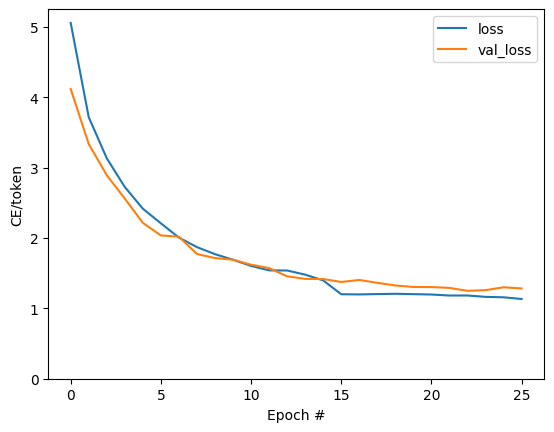

In [45]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

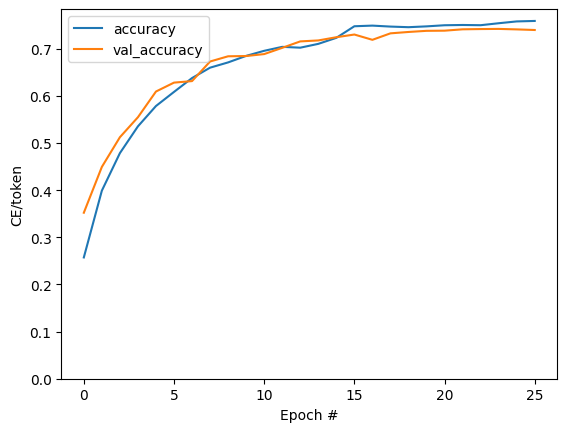

In [46]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

### Translate

Now that the model is trained, implement a function to execute the full `text => text` translation. This code is basically identical to the [inference example](#inference) in the [decoder section](#the_decoder), but this also captures the attention weights.

In [47]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

Here are the two helper methods, used above, to convert tokens to text, and to get the next token:

In [48]:
result = model.translate(['¿Todavía está en casa?']) # Are you still home
result[0].numpy().decode()

'is still at home ? '

Use that to generate the attention plot:

In [49]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

/tmpfs/tmp/ipykernel_10908/3355722706.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/tmpfs/tmp/ipykernel_10908/3355722706.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


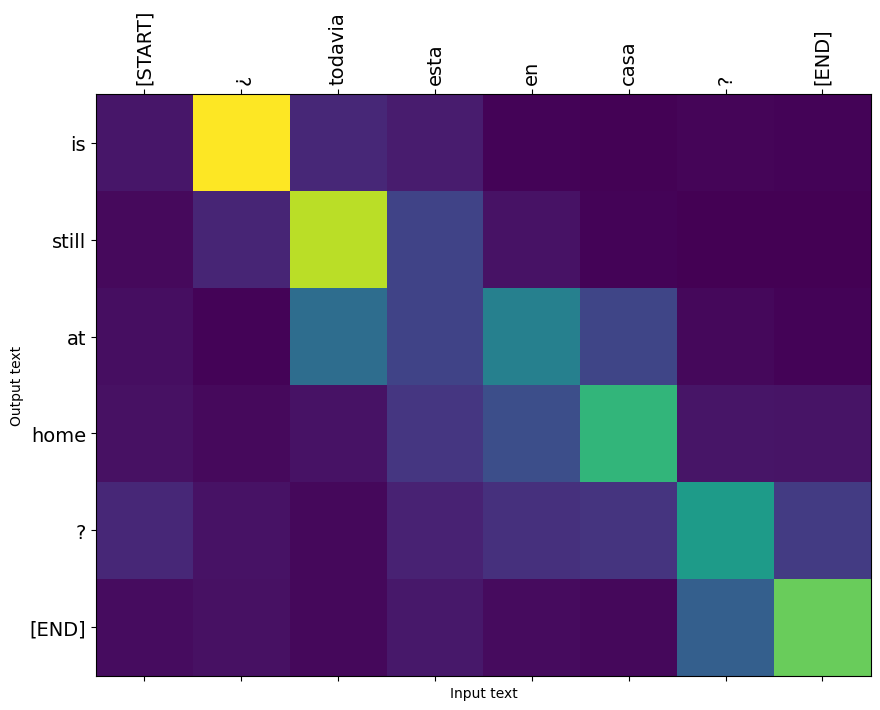

In [50]:
model.plot_attention('¿Todavía está en casa?') # Are you still home

Translate a few more sentences and plot them:

CPU times: user 236 ms, sys: 54.3 ms, total: 290 ms
Wall time: 185 ms


/tmpfs/tmp/ipykernel_10908/3355722706.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/tmpfs/tmp/ipykernel_10908/3355722706.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


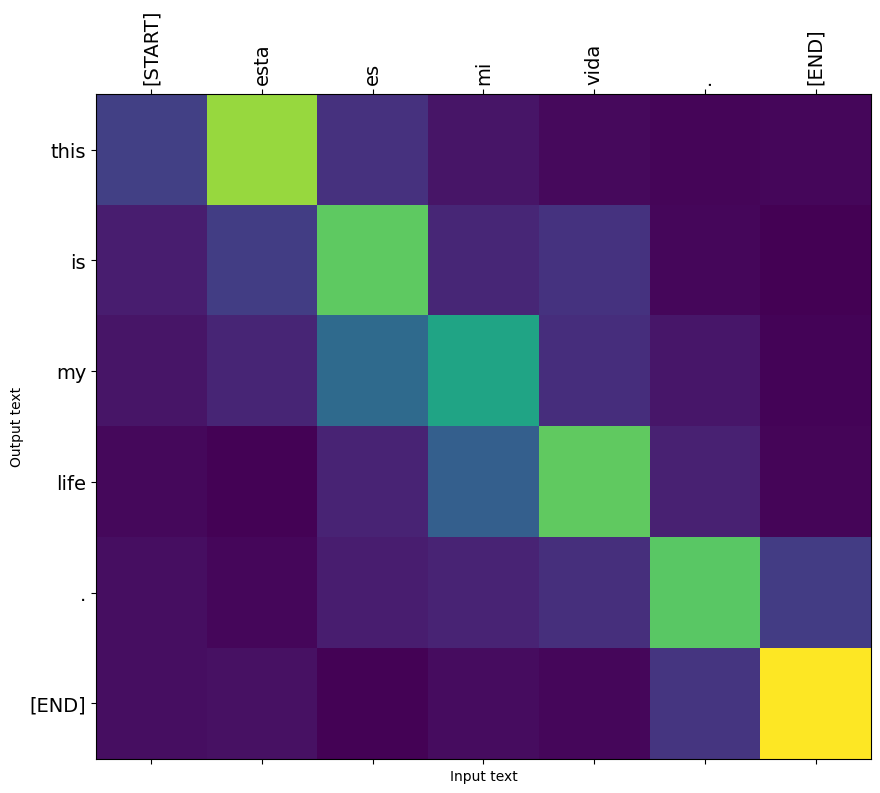

In [51]:
%%time
# This is my life.
model.plot_attention('Esta es mi vida.')

CPU times: user 244 ms, sys: 41.9 ms, total: 285 ms
Wall time: 189 ms


/tmpfs/tmp/ipykernel_10908/3355722706.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/tmpfs/tmp/ipykernel_10908/3355722706.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


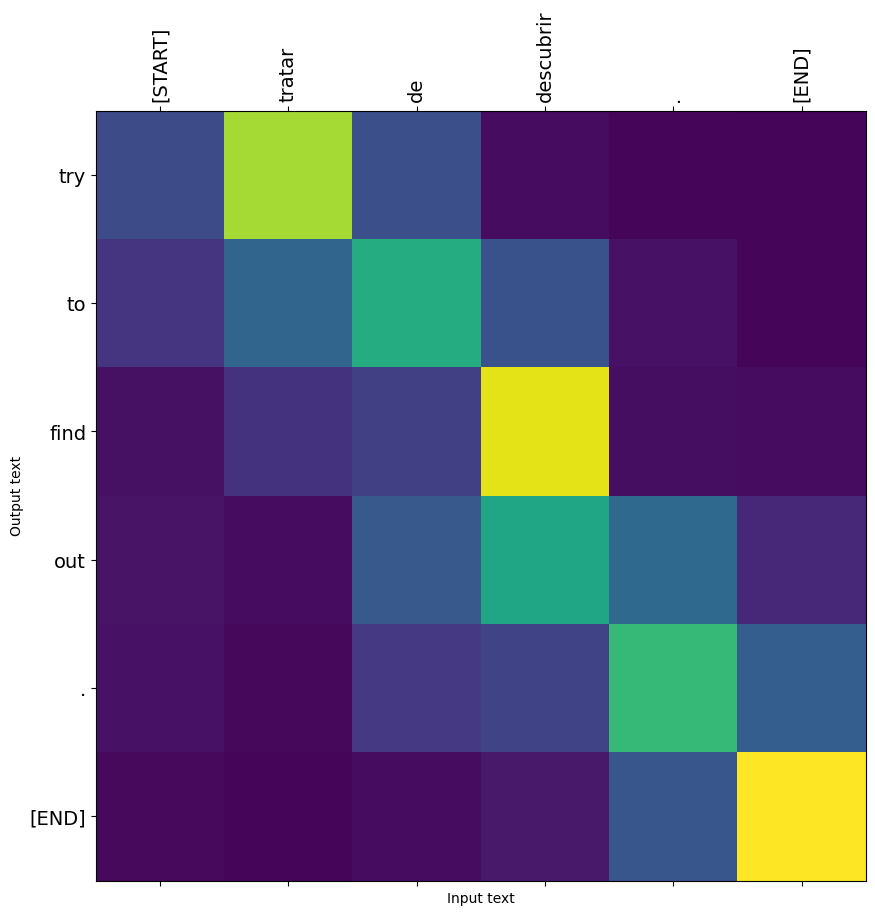

In [52]:
%%time
 # Try to find out.'
model.plot_attention('Tratar de descubrir.')

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:

1. The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions.
2. The model only has access to its previous output through the RNN state. If the RNN state looses track of where it was in the context sequence there's no way for the model to recover. [Transformers](transformer.ipynb) improve on this by letting the decoder look at what it has output so far.

The raw data is sorted by length, so try translating the longest sequence:

In [53]:
long_text = context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

Expected output:
 If you want to sound like a native speaker, you must be willing to
practice saying the same sentence over and over in the same way that
banjo players practice the same phrase over and over until they can
play it correctly and at the desired tempo.


/tmpfs/tmp/ipykernel_10908/3355722706.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/tmpfs/tmp/ipykernel_10908/3355722706.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


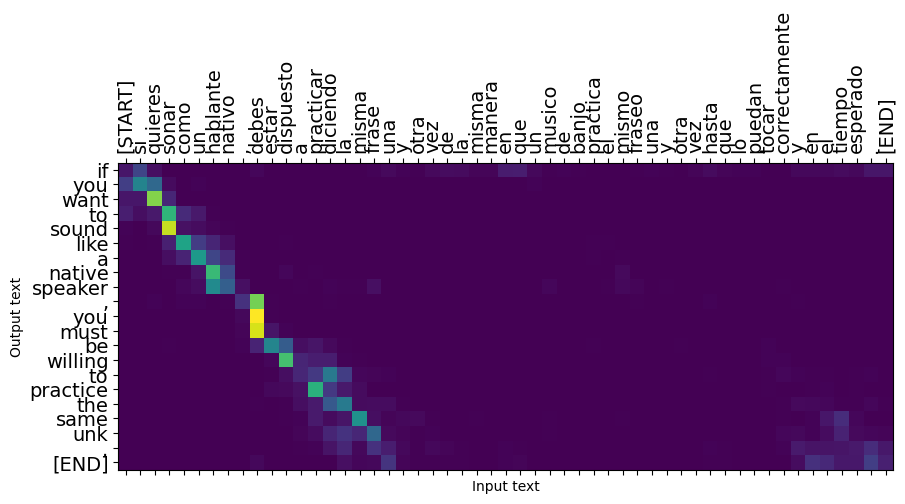

In [54]:
model.plot_attention(long_text)

The `translate` function works on batches, so if you have multiple texts to translate you can pass them all at once, which is much more efficient than translating them one at a time:

In [55]:
inputs = [
    'Hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life."
    'Su cuarto es un desastre.' # "His room is a mess"
]

In [56]:
%%time
for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()

its very cold here . 
this is my life . 


his room is a mess . 

CPU times: user 550 ms, sys: 0 ns, total: 550 ms
Wall time: 509 ms


In [57]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .  
this is my life .  
his room is a mess . 

CPU times: user 207 ms, sys: 8.41 ms, total: 215 ms
Wall time: 198 ms


So overall this text generation function mostly gets the job done, but so you've only used it here in python with eager execution. Let's try to export it next:

### Export

If you want to export this model you'll need to wrap the `translate` method in a `tf.function`. That implementation will get the job done:


In [58]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [59]:
export = Export(model)

Run the `tf.function` once to compile it:

In [60]:
%%time
_ = export.translate(tf.constant(inputs))

2022-11-08 12:13:04.868301: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16022044672 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-11-08 12:13:04.869228: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" fr

CPU times: user 59.2 s, sys: 235 ms, total: 59.4 s
Wall time: 58.7 s


In [61]:
%%time
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .                                             
this is my life .                                             
his room is a mess .                                            

CPU times: user 129 ms, sys: 5.72 ms, total: 135 ms
Wall time: 89.6 ms


Now that the function has been traced it can be exported using `saved_model.save`:

In [62]:
%%time
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets


CPU times: user 1min 17s, sys: 863 ms, total: 1min 18s
Wall time: 1min 18s


In [63]:
%%time
reloaded = tf.saved_model.load('translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

2022-11-08 12:14:38.410621: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:38.422681: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:38.958336: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:38.970495: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:39.018629: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:39.521302: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:41.784607: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:41.797227: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:42.528785: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:43.199230: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:43.533690: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:43.756862: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:43.817823: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:43.834233: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:43.846747: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:43.865539: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _ou

2022-11-08 12:14:44.234427: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:44.446789: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:45.342876: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:45.503927: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:45.981171: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:45.993119: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:46.129324: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:46.577120: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:47.020655: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:47.032465: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:47.283697: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:47.404648: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:47.644433: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:47.805200: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:48.106589: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:48.118356: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:48.137834: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:48.517495: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:48.736166: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:48.752535: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:48.763864: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:48.869391: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:49.074327: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:49.086239: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:49.204006: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:49.460310: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:49.471970: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:49.637986: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:49.649323: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:49.783177: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:49.794950: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:50.089308: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:50.101044: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:51.018474: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:51.030567: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:51.082598: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:51.104406: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:51.214724: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes at

2022-11-08 12:14:51.234558: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:51.246685: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:51.508610: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:51.520257: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:51.565111: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:51.576501: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:51.817986: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:51.913882: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:52.189218: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:52.201089: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:52.308976: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:52.320308: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:54.020517: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:54.032978: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:54.078512: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:54.090076: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:54.184724: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_sh

2022-11-08 12:14:54.534624: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:54.546418: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:54.561550: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:54.573523: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:54.797729: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:55.009607: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:55.023500: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:55.035526: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:55.143789: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:55.452089: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:55.465179: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:55.484961: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:55.551174: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:55.562631: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes at

2022-11-08 12:14:55.789353: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:55.801076: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:55.873204: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:55.892203: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:55.903493: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes at

2022-11-08 12:14:56.377362: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:56.678561: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:56.690843: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:56.703535: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:56.715044: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:56.977435: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:56.990606: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:57.346397: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:57.438608: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:57.449900: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:57.615874: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:57.657426: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:57.668814: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:57.701031: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:57.712319: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes at

2022-11-08 12:14:57.831532: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:58.054813: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:58.066806: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:58.100108: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:58.111887: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:58.242546: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_sh

2022-11-08 12:14:58.425244: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:58.437720: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:58.451043: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:58.462680: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:58.527625: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_sh

2022-11-08 12:14:58.737469: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:58.749568: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:58.769447: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:58.781737: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:58.823078: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes at

2022-11-08 12:14:58.953894: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:58.965844: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:59.189023: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:59.390916: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:59.403722: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:14:59.758665: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:59.770762: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:59.823970: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:14:59.835807: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:15:00.276508: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:15:00.288817: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:15:00.302175: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:15:00.313824: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:15:00.423345: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_sh

2022-11-08 12:15:00.481014: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:15:01.743244: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:15:01.763858: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-11-08 12:15:13.253445: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16022044672 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-11-08 12:15:13.254344: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" fr

CPU times: user 54.4 s, sys: 839 ms, total: 55.2 s
Wall time: 53.9 s


In [64]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .                                             
this is my life .                                             
his room is a mess .                                            

CPU times: user 115 ms, sys: 20.3 ms, total: 135 ms
Wall time: 89.8 ms


#### [Optional] Use a dynamic loop

It's worth noting that this initial implementation is not optimal. It uses a python loop:

```
for _ in range(max_length):
  ...
  if tf.executing_eagerly() and tf.reduce_all(done):
    break
```

The python loop is relatively simple but when `tf.function` converts this to a graph, it **statically unrolls** that loop. Unrolling the loop has two disadvantages:

1. It makes `max_length` copies of the loop body. So the generated graphs take longer to build, save and load.
1. You have to choose a fixed value for the `max_length`. 
1. You can't `break` from a statically unrolled loop. The `tf.function`
  version will run the full `max_length` iterations on every call.
  That's why the `break` only works with eager execution. This is
  still marginally faster than eager execution, but not as fast as it could be.


To fix these shortcomings, the `translate_dynamic` method, below, uses a tensorflow loop:

```
for t in tf.range(max_length):
  ...
  if tf.reduce_all(done):
      break
```

It looks like a python loop, but when you use a tensor as the input to a `for` loop (or the condition of a `while` loop) `tf.function` converts it to a dynamic loop using operations like `tf.while_loop`. 

There's no need for a `max_length` here it's just in case the model gets stuck generating a loop like: `the united states of the united states of the united states...`.

On the down side, to accumulate tokens from this dynamic loop you can't just append them to a python `list`, you need to use a `tf.TensorArray`:

```
tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
...
for t in tf.range(max_length):
    ...
    tokens = tokens.write(t, next_token) # next_token shape is (batch, 1)
  ...
  tokens = tokens.stack()
  tokens = einops.rearrange(tokens, 't batch 1 -> batch t')
```

This version of the code can be quite a bit more efficient:

In [65]:
#@title
@Translator.add_method
def translate(self,
              texts,
              *,
              max_length=500,
              temperature=tf.constant(0.0)):
  shape_checker = ShapeChecker()
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(context)[0]
  shape_checker(context, 'batch s units')

  next_token, done, state = self.decoder.get_initial_state(context)

  # initialize the accumulator
  tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)

  for t in tf.range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done, state, temperature)
    shape_checker(next_token, 'batch t1')

    # Collect the generated tokens
    tokens = tokens.write(t, next_token)

    # if all the sequences are done, break
    if tf.reduce_all(done):
      break

  # Convert the list of generated token ids to a list of strings.
  tokens = tokens.stack()
  shape_checker(tokens, 't batch t1')
  tokens = einops.rearrange(tokens, 't batch 1 -> batch t')
  shape_checker(tokens, 'batch t')

  text = self.decoder.tokens_to_text(tokens)
  shape_checker(text, 'batch')

  return text

With eager execution this implementation performs on par with the original:

In [66]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .  
this is my life .  
his room is a mess . 

CPU times: user 213 ms, sys: 3.75 ms, total: 216 ms
Wall time: 199 ms


But when you wrap it in a `tf.function` you'll notice two differences.

In [67]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [68]:
export = Export(model)

First, it's much quicker to trace, since it only creates one copy of the loop body:

In [69]:
%%time
_ = export.translate(inputs)

2022-11-08 12:15:32.250796: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16022044672 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


CPU times: user 4.09 s, sys: 0 ns, total: 4.09 s
Wall time: 4.02 s


The `tf.function` is much faster than running with eager execution, and on small inputs it's often several times faster than the unrolled version, because it can break out of the loop.

In [70]:
%%time
result = export.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .  
this is my life .  
his room is a mess . 

CPU times: user 54.6 ms, sys: 0 ns, total: 54.6 ms
Wall time: 34.8 ms


So save this version as well:

In [71]:
%%time
tf.saved_model.save(export, 'dynamic_translator',
                    signatures={'serving_default': export.translate})

INFO:tensorflow:Assets written to: dynamic_translator/assets


INFO:tensorflow:Assets written to: dynamic_translator/assets


CPU times: user 31.6 s, sys: 0 ns, total: 31.6 s
Wall time: 31.5 s


In [72]:
%%time
reloaded = tf.saved_model.load('dynamic_translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

2022-11-08 12:16:05.700079: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:05.712215: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:16:06.087626: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:16:07.115889: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-11-08 12:16:08.109533: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:08.121379: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:08.278308: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-11-08 12:16:08.622869: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:16:09.006041: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-11-08 12:16:09.237682: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:09.250207: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:09.278520: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:09.308432: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-11-08 12:16:09.516058: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-11-08 12:16:09.920398: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:10.112009: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-11-08 12:16:10.179601: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:10.191288: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:10.274615: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:10.285814: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:16:10.412541: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:10.568780: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:10.581489: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:10.592684: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-11-08 12:16:10.904205: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:10.916136: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:11.012852: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:11.079759: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:16:11.291243: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:11.375908: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:11.398121: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:11.409915: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-11-08 12:16:11.800750: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:11.812503: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:11.973427: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:11.985197: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-11-08 12:16:12.085766: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:12.097276: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:12.162372: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-11-08 12:16:12.322807: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:12.334891: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:12.386055: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:12.456713: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-11-08 12:16:14.908709: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-11-08 12:16:15.187498: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-08 12:16:15.200078: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-11-08 12:16:15.423207: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-11-08 12:16:15.642949: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-11-08 12:16:17.173689: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16022044672 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


CPU times: user 13.7 s, sys: 0 ns, total: 13.7 s
Wall time: 13.5 s


In [73]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .  
this is my life .  
his room is a mess . 

CPU times: user 37.5 ms, sys: 0 ns, total: 37.5 ms
Wall time: 19.5 ms


## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs.
* Try the [transformer tutorial](transformer.ipynb) which implements a similar translation task but uses transformer layers instead of RNNs. This version also uses a `text.BertTokenizer` to implement word-piece tokenization.
* Visit the [`tensorflow_addons.seq2seq` tutorial](https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt), which demonstrates a higher-level functionality for implementing this sort of sequence-to-sequence model, such as `seq2seq.BeamSearchDecoder`.